In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim
import glob2
from itertools import chain
import os
import numpy as np
import itertools
import cPickle as pickle
from  scipy.stats import rankdata
import copy
from openpyxl import Workbook
from openpyxl.compat import range
from openpyxl.utils import get_column_letter
from openpyxl import load_workbook
import pandas as pd
from scipy.stats import hmean
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


2018-03-20 18:12:03,719 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
# ignores everything except english alphabet and  
def only_alphabet(text):
    return ''.join(i for i in text if (ord(i)<123 and ord(i)>96) or (ord(i)<91 and ord(i)>64) or ord(i)==32) 

In [4]:
full_filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        full_filenames.append(filename)
            
filenames = []
x= ['LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt','LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt','LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt' ,'LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt', 'LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt']
for glob_filenames in x:
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        filenames.append(os.path.basename(filename))

en_stop = set(get_stop_words('en'))
ps = PorterStemmer()

# "yield" for each file return token list  i.e list of lists
def files_to_tokens(glob_filenames):
    glob_filenames = os.path.normpath(glob_filenames)
    for filename in sorted(glob2.glob(glob_filenames)):
        f = open(filename)
        # read the whole file as lowercase string
        string = only_alphabet(f.read()).lower()
        tokens = []
        # tokenize that string
        for word in word_tokenize(string):
            if word not in en_stop:
                tokens.append(ps.stem(word))

        yield tokens
        f.close()


        
# yields token list for files specific to courts; needed for creating dictionaries
class texts:
    def DCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/**/*.txt')
    def NCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt')
    def SCDRC(self):
        return files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt')
    def DelhiHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt')
    def JharkhandHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt')
    def JodhpurHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt')
    def KolkataHC(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt')
    def SupremeCourt(self):
        return files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt')

# yields bow for each file - tuples id,fq ; needed to train models   
class my_corpus:    
    def DCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/DCDRC/*.txt'):
            yield dictionary.doc2bow(text)
    def NCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/NCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)            
    def SCDRC(self):
        for text in files_to_tokens('LegalAdhocTask/ConsumerCourtAdhocdata/SCDRC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def DelhiHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/DelhiHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JharkhandHC(self):
        for text in files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JharkhandHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def JodhpurHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/JodhpurHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def KolkataHC(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/KolkataHC/**/*.txt'):
            yield dictionary.doc2bow(text)
    def SupremeCourt(self):
        for text in  files_to_tokens('LegalAdhocTask/SC-HCAdhocData/SupremeCourt/**/*.txt'):
            yield dictionary.doc2bow(text)
    def everything(self):
        return chain(self.DCDRC(), self.NCDRC(), self.SCDRC(), self.DelhiHC(),
                     self.JharkhandHC(), self.JodhpurHC(), self.KolkataHC(), self.SupremeCourt())
        
        

In [5]:
#################################### laod the dictinary
dictionary = corpora.Dictionary.load('stem100_dictionary')

2018-03-20 18:12:22,682 : INFO : loading Dictionary object from stem100_dictionary
2018-03-20 18:12:22,693 : INFO : loaded stem100_dictionary


In [6]:
######################################## load BOW
corpus = corpora.MmCorpus('stem100.mm')

2018-03-20 18:12:22,825 : INFO : loaded corpus index from stem100.mm.index
2018-03-20 18:12:22,825 : INFO : initializing corpus reader from stem100.mm
2018-03-20 18:12:22,826 : INFO : accepted corpus with 351985 documents, 40069 features, 92572684 non-zero entries


In [10]:
%%time
from gensim.models import ldamodel
lda_model = ldamodel.LdaModel(corpus, num_topics=100, alpha = 'auto', id2word = dictionary, passes =3,  minimum_probability =0.0)

2018-03-20 18:30:34,025 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
2018-03-20 18:30:34,027 : INFO : using symmetric eta at 2.49569492625e-05
2018-03-20 18:30:34,033 : INFO : using serial LDA version on this node
2018-03-20 18:31:13,943 : INFO : running online (multi-pass) LDA training, 100 topics, 3 passes over the supplied corpus of 351985 documents, updating model once every 2000 documents, 

2018-03-20 18:32:39,175 : INFO : optimized alpha [0.014076338764835722, 0.017090037288565063, 0.011515884829903456, 0.011709661474453632, 0.012478189949557799, 0.011905610359312382, 0.011618905411519371, 0.011587082993611013, 0.013325862331146623, 0.014006041561995784, 0.013385176438284026, 0.013496809327786352, 0.01896209044693925, 0.011235447592821288, 0.01631763092506398, 0.015257172987215491, 0.011318325664626006, 0.015020397635482779, 0.014559660117761469, 0.012468058983388866, 0.015562685939122961, 0.012304839985807291, 0.012579850030801877, 0.011684765564704757, 0.014189140797012816, 0.012344471171594353, 0.013180656431518537, 0.014005993709082046, 0.01173178425265663, 0.013207693602032706, 0.014080548099498484, 0.014572865503520851, 0.012386232371675967, 0.011945134735804233, 0.013847547703114851, 0.013723915034954688, 0.013640541857109183, 0.015197798140404914, 0.012978010632136541, 0.013158492805397251, 0.014379112749965169, 0.015610922950932275, 0.012794104120839089, 0.01425

2018-03-20 18:33:34,084 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:33:37,640 : INFO : topic #16 (0.011): 0.029*"complain" + 0.027*"crop" + 0.026*"yield" + 0.021*"dharwad" + 0.019*"complaint" + 0.016*"insur" + 0.013*"respect" + 0.013*"compens" + 0.012*"data" + 0.012*"produc"
2018-03-20 18:33:37,642 : INFO : topic #13 (0.011): 0.027*"complain" + 0.020*"semest" + 0.008*"mark" + 0.008*"cs" + 0.006*"u" + 0.006*"said" + 0.006*"examin" + 0.006*"mgroad" + 0.006*"parti" + 0.006*"produc"
2018-03-20 18:33:37,643 : INFO : topic #12 (0.025): 0.031*"complain" + 0.013*"respond" + 0.013*"op" + 0.011*"complaint" + 0.010*"thecomplain" + 0.010*"forum" + 0.008*"said" + 0.008*"file" + 0.007*"also" + 0.006*"servic"
2018-03-20 18:33:37,644 : INFO : topic #73 (0.036): 0.045*"sri" + 0.021*"complain" + 0.016*"nrupatunga" + 0.013*"road" + 0.012*"occ" + 0.012*"complaint" + 0.011*"circl" + 0.011*"file" + 0.011*"bhavan" + 0.011*"rs"
2018-03-20 18:33:37,645 : INFO : t

2018-03-20 18:34:30,401 : INFO : topic diff=1.587978, rho=0.377964
2018-03-20 18:34:33,061 : INFO : PROGRESS: pass 0, at document #16000/351985
2018-03-20 18:34:55,918 : INFO : optimized alpha [0.015532741479267132, 0.018364761422650616, 0.01333053679323817, 0.011621459245750861, 0.014073351040653914, 0.014196208092687821, 0.014450515610574508, 0.012973944699403139, 0.015731088810283608, 0.016603126211622798, 0.017477813478357616, 0.01465690303178039, 0.042537673580078435, 0.013304606407053126, 0.015940495812514794, 0.013216802799680422, 0.010571037439190217, 0.019296327102584575, 0.01730127498321209, 0.014418168111589809, 0.022343874684586987, 0.012774769200945153, 0.012162073303831832, 0.014048257066012444, 0.016675931648591737, 0.013019831041498229, 0.014774235755578265, 0.02539508963392843, 0.013370837286946225, 0.0173875794116711, 0.01897511255890982, 0.014652029122904642, 0.011473781109113283, 0.010805455685261896, 0.016530607715437788, 0.014229794679223666, 0.017173977924638959,

2018-03-20 18:36:29,927 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:36:32,276 : INFO : topic #16 (0.010): 0.048*"rain" + 0.025*"complain" + 0.024*"yield" + 0.022*"crop" + 0.017*"data" + 0.017*"complaint" + 0.016*"insur" + 0.015*"hobli" + 0.014*"dharwad" + 0.012*"compens"
2018-03-20 18:36:32,277 : INFO : topic #99 (0.011): 0.044*"complaint" + 0.037*"jawar" + 0.035*"complain" + 0.030*"dri" + 0.026*"region" + 0.023*"allow" + 0.020*"rangappa" + 0.020*"heir" + 0.018*"claim" + 0.017*"file"
2018-03-20 18:36:32,278 : INFO : topic #12 (0.053): 0.025*"complain" + 0.020*"thecomplain" + 0.011*"complaint" + 0.008*"forum" + 0.007*"also" + 0.007*"file" + 0.007*"ofth" + 0.006*"section" + 0.006*"act" + 0.006*"order"
2018-03-20 18:36:32,280 : INFO : topic #70 (0.054): 0.194*"op" + 0.045*"complain" + 0.029*"complaint" + 0.023*"rs" + 0.014*"member" + 0.014*"order" + 0.014*"servic" + 0.013*"amount" + 0.012*"file" + 0.010*"pay"
2018-03-20 18:36:32,281 : INFO :

2018-03-20 18:37:18,568 : INFO : topic diff=1.298901, rho=0.288675
2018-03-20 18:37:20,774 : INFO : PROGRESS: pass 0, at document #26000/351985
2018-03-20 18:37:43,346 : INFO : optimized alpha [0.014170410604400623, 0.016579239666276949, 0.012060074430620894, 0.010822922252498392, 0.015414134336661131, 0.016849904695853086, 0.016354130597055507, 0.015081531342779128, 0.017701904088193117, 0.021368096983170933, 0.020622138835133398, 0.014377314674129551, 0.062507420732843461, 0.016458672769974435, 0.017873724108824159, 0.014330383075317693, 0.010350944619975719, 0.025099271838050784, 0.023416595207319226, 0.01275813397342684, 0.028689123498674612, 0.013881936149635133, 0.013387233151657541, 0.015053616973238362, 0.021181344670621886, 0.011632998226351696, 0.013008091301692344, 0.042778231652111212, 0.015288572318635122, 0.017127898110107943, 0.022591286417343894, 0.014578653773808011, 0.012301350292999905, 0.011220239777214725, 0.021426716775445605, 0.014424338786100869, 0.0178877030147

2018-03-20 18:38:35,963 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:38:38,019 : INFO : topic #16 (0.010): 0.049*"rain" + 0.026*"consolid" + 0.024*"yield" + 0.021*"data" + 0.018*"crop" + 0.018*"complain" + 0.017*"respect" + 0.016*"area" + 0.015*"govern" + 0.015*"scheme"
2018-03-20 18:38:38,020 : INFO : topic #99 (0.011): 0.125*"region" + 0.050*"heir" + 0.042*"green" + 0.033*"complain" + 0.033*"complaint" + 0.028*"dri" + 0.028*"krishnappa" + 0.014*"entitl" + 0.014*"allow" + 0.014*"claim"
2018-03-20 18:38:38,021 : INFO : topic #69 (0.086): 0.224*"parti" + 0.224*"opposit" + 0.042*"complain" + 0.015*"date" + 0.014*"rs" + 0.009*"complaint" + 0.007*"amount" + 0.007*"order" + 0.007*"copi" + 0.006*"pay"
2018-03-20 18:38:38,022 : INFO : topic #12 (0.095): 0.031*"thecomplain" + 0.027*"complain" + 0.009*"oppositeparti" + 0.009*"complaint" + 0.009*"ofth" + 0.008*"forum" + 0.007*"servic" + 0.007*"file" + 0.006*"also" + 0.005*"toth"
2018-03-20 18:38:38,

2018-03-20 18:39:32,293 : INFO : topic diff=0.939108, rho=0.242536
2018-03-20 18:39:34,991 : INFO : PROGRESS: pass 0, at document #36000/351985
2018-03-20 18:40:06,095 : INFO : optimized alpha [0.013927437201938465, 0.017231884131370036, 0.011638795526632788, 0.011804966317293776, 0.016763314119854666, 0.019106988421506162, 0.017271716451711293, 0.016965848852719435, 0.019010068176963737, 0.032035070694990071, 0.032755622814896197, 0.01478850382899247, 0.16586923964757425, 0.019278678030726592, 0.017163637447085336, 0.014630753024372108, 0.010271782692722194, 0.027616578938663421, 0.024748738720508569, 0.012066979658876809, 0.028667291458087864, 0.022719457620260831, 0.013103284025740253, 0.016987303274040841, 0.01991719916836961, 0.011090522073362814, 0.012202433070779884, 0.043495392900166942, 0.017598639381025318, 0.017684008749630976, 0.022484378403839801, 0.016365149013689392, 0.014682911287348485, 0.012035731769624617, 0.024001546933521314, 0.015208809791120831, 0.019785006678592

2018-03-20 18:41:56,210 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:41:58,113 : INFO : topic #16 (0.010): 0.054*"rain" + 0.034*"flood" + 0.033*"consolid" + 0.028*"area" + 0.019*"necessari" + 0.018*"agenc" + 0.017*"data" + 0.016*"basi" + 0.016*"respect" + 0.016*"complain"
2018-03-20 18:41:58,115 : INFO : topic #25 (0.011): 0.040*"vfj" + 0.030*"ufc" + 0.026*"szjfdf" + 0.025*"tszfz" + 0.022*"gondia" + 0.021*"icomplaint" + 0.018*"sgl" + 0.015*"complain" + 0.014*"fdfjff" + 0.014*"lgjfz"
2018-03-20 18:41:58,116 : INFO : topic #69 (0.125): 0.241*"parti" + 0.234*"opposit" + 0.045*"complain" + 0.014*"date" + 0.014*"rs" + 0.009*"complaint" + 0.008*"copi" + 0.007*"amount" + 0.006*"order" + 0.006*"pay"
2018-03-20 18:41:58,117 : INFO : topic #73 (0.158): 0.046*"exh" + 0.034*"saurashtra" + 0.030*"moti" + 0.028*"road" + 0.025*"manag" + 0.018*"chowk" + 0.017*"complain" + 0.017*"nanal" + 0.017*"floor" + 0.016*"chamber"
2018-03-20 18:41:58,119 : INFO : top

2018-03-20 18:42:50,088 : INFO : topic diff=0.820682, rho=0.213201
2018-03-20 18:42:51,694 : INFO : PROGRESS: pass 0, at document #46000/351985
2018-03-20 18:43:13,795 : INFO : optimized alpha [0.015991137410984964, 0.020027303822293032, 0.011314088883179901, 0.011640825408767763, 0.0183543882765572, 0.021752412780841213, 0.017231551493914189, 0.018442025693393219, 0.020072714455722875, 0.03536393232397031, 0.031200038586561438, 0.015693290627776864, 0.28064981801313688, 0.022669833673734978, 0.01835087939027125, 0.017760789108737376, 0.010413878312554787, 0.030213025214503687, 0.028132384711126716, 0.011605496805215719, 0.03084753927759374, 0.022282151888250033, 0.015321357975169828, 0.017887948342223108, 0.020748359328384734, 0.010877961128028949, 0.011698924354690969, 0.045468522111257702, 0.019361777390510388, 0.01962883226283996, 0.024258968320169768, 0.019645050269285067, 0.014899736214420303, 0.013133211969421797, 0.031075849505245605, 0.017765722693778862, 0.02242688703566648, 

2018-03-20 18:44:05,473 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:44:07,306 : INFO : topic #25 (0.011): 0.027*"vfj" + 0.020*"ufc" + 0.020*"rm" + 0.019*"chittaranjan" + 0.017*"szjfdf" + 0.017*"tszfz" + 0.016*"annexa" + 0.015*"gondia" + 0.014*"cooch" + 0.014*"icomplaint"
2018-03-20 18:44:07,307 : INFO : topic #16 (0.011): 0.035*"yield" + 0.031*"area" + 0.029*"data" + 0.025*"depart" + 0.024*"per" + 0.023*"notifi" + 0.017*"podia" + 0.017*"averag" + 0.016*"season" + 0.015*"agenc"
2018-03-20 18:44:07,309 : INFO : topic #69 (0.124): 0.246*"parti" + 0.241*"opposit" + 0.040*"complain" + 0.016*"date" + 0.010*"rs" + 0.010*"copi" + 0.007*"complaint" + 0.007*"issu" + 0.006*"order" + 0.006*"per"
2018-03-20 18:44:07,311 : INFO : topic #73 (0.200): 0.058*"opno" + 0.027*"complt" + 0.020*"exh" + 0.019*"manag" + 0.018*"road" + 0.016*"sri" + 0.016*"ld" + 0.015*"saurashtra" + 0.015*"complain" + 0.014*"moti"
2018-03-20 18:44:07,313 : INFO : topic #12 (0.280)

2018-03-20 18:45:05,753 : INFO : topic diff=0.610946, rho=0.192450
2018-03-20 18:45:07,856 : INFO : PROGRESS: pass 0, at document #56000/351985
2018-03-20 18:45:31,496 : INFO : optimized alpha [0.017187192529575641, 0.02106349425757903, 0.011381076240351069, 0.011844632019162409, 0.019663614474095453, 0.02402879323204905, 0.01809389357227165, 0.019686399838693303, 0.021236333822258542, 0.040548292596892244, 0.031491859727632507, 0.017109703774405235, 0.35979710508361951, 0.027476841330349177, 0.018422801390104781, 0.019721826310238669, 0.011100193451838688, 0.034074055141439782, 0.033165760997981117, 0.011585629955849662, 0.033111410445836403, 0.025048794487102424, 0.018372721422922369, 0.019764656694695609, 0.022839700552617807, 0.011466179666773333, 0.013010285156809675, 0.04468948002206128, 0.023477779647615132, 0.024510466651298086, 0.027403438453284072, 0.021966624677617938, 0.015405407964149655, 0.01508517219345413, 0.03781981957302482, 0.019184744461330273, 0.0254438406189656, 0

2018-03-20 18:47:23,473 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:47:25,169 : INFO : topic #74 (0.011): 0.063*"crop" + 0.047*"insur" + 0.037*"experi" + 0.032*"yield" + 0.024*"cut" + 0.023*"propos" + 0.021*"premium" + 0.019*"odisha" + 0.019*"podia" + 0.017*"op"
2018-03-20 18:47:25,170 : INFO : topic #16 (0.011): 0.035*"yield" + 0.033*"area" + 0.030*"data" + 0.025*"depart" + 0.025*"per" + 0.023*"notifi" + 0.017*"averag" + 0.016*"agenc" + 0.016*"podia" + 0.016*"season"
2018-03-20 18:47:25,171 : INFO : topic #70 (0.185): 0.289*"op" + 0.044*"complain" + 0.019*"rs" + 0.017*"date" + 0.012*"member" + 0.012*"order" + 0.011*"file" + 0.011*"sri" + 0.010*"theop" + 0.009*"servic"
2018-03-20 18:47:25,172 : INFO : topic #73 (0.234): 0.045*"opno" + 0.036*"ld" + 0.019*"road" + 0.019*"manag" + 0.014*"complain" + 0.013*"complt" + 0.013*"sri" + 0.012*"floor" + 0.011*"ltd" + 0.010*"exh"
2018-03-20 18:47:25,173 : INFO : topic #12 (0.459): 0.030*"thecomplain"

2018-03-20 18:48:19,526 : INFO : topic diff=0.483542, rho=0.176777
2018-03-20 18:48:21,545 : INFO : PROGRESS: pass 0, at document #66000/351985
2018-03-20 18:48:46,697 : INFO : optimized alpha [0.0172817230237866, 0.024172615844552162, 0.011071513098102909, 0.01220251275016755, 0.020024408681872, 0.031389751016682427, 0.018760975677443534, 0.021197587964231251, 0.022489171358615632, 0.045537044735579228, 0.031320677413475453, 0.017928868867156791, 0.61793797412255402, 0.040980657749450998, 0.018659180912614527, 0.022198307536388222, 0.01133004548881952, 0.041157273578656957, 0.037520455493049089, 0.011973285129752575, 0.038644088537683655, 0.025711883006309364, 0.018557601984143534, 0.019883564201577882, 0.025555036283339775, 0.011669057203218883, 0.012561076215099165, 0.056445971468907882, 0.027768419861175595, 0.034879904961952847, 0.029782222594919361, 0.025534129793543747, 0.017139201825862614, 0.016556239428000073, 0.041873268515828108, 0.030814463512520835, 0.028193795433725542, 

2018-03-20 18:49:47,530 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:49:49,277 : INFO : topic #74 (0.011): 0.061*"crop" + 0.044*"insur" + 0.039*"cut" + 0.037*"experi" + 0.030*"yield" + 0.022*"propos" + 0.020*"premium" + 0.019*"level" + 0.017*"odisha" + 0.017*"podia"
2018-03-20 18:49:49,278 : INFO : topic #2 (0.011): 0.092*"insur" + 0.088*"crop" + 0.052*"scheme" + 0.044*"agricultur" + 0.041*"farmer" + 0.026*"yield" + 0.023*"kharif" + 0.020*"nai" + 0.018*"premium" + 0.018*"declar"
2018-03-20 18:49:49,279 : INFO : topic #70 (0.190): 0.305*"op" + 0.047*"complain" + 0.020*"rs" + 0.016*"date" + 0.013*"file" + 0.012*"order" + 0.011*"member" + 0.010*"theop" + 0.008*"servic" + 0.008*"also"
2018-03-20 18:49:49,280 : INFO : topic #73 (0.232): 0.037*"ld" + 0.027*"opno" + 0.018*"road" + 0.017*"manag" + 0.014*"complain" + 0.012*"vs" + 0.012*"jind" + 0.011*"ltd" + 0.011*"floor" + 0.010*"complaint"
2018-03-20 18:49:49,281 : INFO : topic #12 (0.689): 0.030

2018-03-20 18:50:45,641 : INFO : topic diff=0.444642, rho=0.164399
2018-03-20 18:50:47,517 : INFO : PROGRESS: pass 0, at document #76000/351985
2018-03-20 18:51:13,304 : INFO : optimized alpha [0.01927237574750643, 0.028467882157764742, 0.010844122082613136, 0.013632390894726926, 0.020397794045459033, 0.034813996201978538, 0.019103173902655687, 0.022748905503354851, 0.022772521120452398, 0.048173434818487779, 0.030466264539124505, 0.019171530346606021, 0.8425725667835593, 0.052591827759645576, 0.019381544622222514, 0.030024916206395916, 0.011541705364216819, 0.041584507812839566, 0.046416213079427573, 0.012284325708222913, 0.041541325706635934, 0.036367630383677726, 0.020725762320175971, 0.020593325337843846, 0.025724371274092817, 0.01295565051569993, 0.012369912615071697, 0.064171603642582994, 0.030190022898732616, 0.042290085531704574, 0.029636846531072375, 0.025964293058856731, 0.01789015119026538, 0.018738653735274113, 0.047096733672988451, 0.039278565475976406, 0.03387130745525542

2018-03-20 18:53:15,252 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:53:16,860 : INFO : topic #74 (0.010): 0.058*"cut" + 0.054*"crop" + 0.044*"experi" + 0.039*"insur" + 0.028*"propos" + 0.027*"yield" + 0.026*"level" + 0.018*"revenu" + 0.018*"premium" + 0.017*"failur"
2018-03-20 18:53:16,861 : INFO : topic #2 (0.011): 0.089*"insur" + 0.088*"crop" + 0.053*"scheme" + 0.049*"agricultur" + 0.043*"farmer" + 0.026*"yield" + 0.022*"kharif" + 0.019*"nai" + 0.018*"premium" + 0.018*"declar"
2018-03-20 18:53:16,862 : INFO : topic #98 (0.237): 0.028*"complain" + 0.022*"claim" + 0.020*"thecomplain" + 0.016*"date" + 0.013*"shimla" + 0.010*"copi" + 0.010*"ofth" + 0.008*"document" + 0.007*"letter" + 0.007*"dateof"
2018-03-20 18:53:16,864 : INFO : topic #73 (0.261): 0.025*"ld" + 0.020*"road" + 0.017*"manag" + 0.017*"opno" + 0.015*"exop" + 0.015*"hs" + 0.015*"kulwant" + 0.015*"complain" + 0.013*"ldcounsel" + 0.012*"vs"
2018-03-20 18:53:16,865 : INFO : topic 

2018-03-20 18:54:24,057 : INFO : topic diff=0.385945, rho=0.154303
2018-03-20 18:54:26,354 : INFO : PROGRESS: pass 0, at document #86000/351985
2018-03-20 18:54:51,676 : INFO : optimized alpha [0.020380135463214436, 0.033211918089936898, 0.010640275317281697, 0.014310049888027577, 0.021108765915192063, 0.037987510548489443, 0.021743690691665717, 0.024708671464411441, 0.023233296549189434, 0.055174346078756133, 0.031891963601426938, 0.020813989978266365, 0.98479522416219634, 0.070217503439494955, 0.020330067313781241, 0.031120110620687286, 0.011973490720625096, 0.042983107342352701, 0.053223629381496475, 0.013693966747295751, 0.049280938867686433, 0.035717019877844945, 0.022948385073362186, 0.021328067639074477, 0.026941054987300515, 0.012700593003766619, 0.012905978606948008, 0.068755557936433523, 0.033312371403094607, 0.051835328799283605, 0.029851697569473541, 0.037749591163230456, 0.01935155123454833, 0.021945875622867046, 0.052479811253341342, 0.040224328729662473, 0.03884290673352

2018-03-20 18:55:49,498 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:55:51,003 : INFO : topic #74 (0.010): 0.099*"cut" + 0.058*"level" + 0.045*"experi" + 0.043*"crop" + 0.028*"propos" + 0.028*"insur" + 0.021*"yield" + 0.020*"failur" + 0.019*"revenu" + 0.019*"declar"
2018-03-20 18:55:51,004 : INFO : topic #2 (0.011): 0.118*"crop" + 0.070*"agricultur" + 0.068*"insur" + 0.057*"farmer" + 0.048*"scheme" + 0.030*"yield" + 0.018*"govern" + 0.017*"nai" + 0.017*"per" + 0.016*"declar"
2018-03-20 18:55:51,006 : INFO : topic #73 (0.263): 0.032*"ld" + 0.021*"road" + 0.016*"exop" + 0.015*"manag" + 0.015*"complain" + 0.013*"ldcounsel" + 0.013*"opno" + 0.012*"chowk" + 0.011*"complaint" + 0.011*"vs"
2018-03-20 18:55:51,007 : INFO : topic #69 (0.284): 0.268*"parti" + 0.249*"opposit" + 0.049*"complain" + 0.016*"oppositeparti" + 0.016*"date" + 0.014*"theopposit" + 0.011*"complaint" + 0.010*"rs" + 0.008*"copi" + 0.008*"order"
2018-03-20 18:55:51,008 : INFO : t

2018-03-20 18:56:49,698 : INFO : topic diff=0.330568, rho=0.145865
2018-03-20 18:56:52,060 : INFO : PROGRESS: pass 0, at document #96000/351985
2018-03-20 18:57:16,996 : INFO : optimized alpha [0.021816806287084656, 0.035978152789500138, 0.010948683091600055, 0.014705109442207863, 0.022214996349797816, 0.042874766108893195, 0.025297740534462949, 0.026922881402700091, 0.023882631303298034, 0.064839431979001147, 0.033248930122986818, 0.023848509395606943, 1.0665448458338087, 0.084103659560190558, 0.020769867961932517, 0.033200805963915891, 0.012619100706464388, 0.043721022856943223, 0.065730782325958345, 0.014393044194316916, 0.056223465610555579, 0.035313308489073506, 0.025945971513680281, 0.023076404049865187, 0.028261873889859179, 0.012693676962869122, 0.012900993678152404, 0.072306231171715973, 0.035534801805110698, 0.060848942544308712, 0.030073299635010129, 0.059557583295541915, 0.020958872343317121, 0.025107085285966897, 0.062565008889524487, 0.03989954403756929, 0.040607126718382

2018-03-20 18:59:28,656 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 18:59:30,077 : INFO : topic #74 (0.011): 0.111*"cut" + 0.061*"level" + 0.036*"revenu" + 0.034*"experi" + 0.030*"extop" + 0.024*"failur" + 0.023*"crop" + 0.020*"bhikhi" + 0.020*"propos" + 0.019*"yield"
2018-03-20 18:59:30,078 : INFO : topic #2 (0.011): 0.153*"crop" + 0.116*"agricultur" + 0.073*"farmer" + 0.043*"scheme" + 0.040*"yield" + 0.030*"insur" + 0.019*"per" + 0.017*"govern" + 0.015*"claim" + 0.011*"complain"
2018-03-20 18:59:30,080 : INFO : topic #73 (0.281): 0.024*"warang" + 0.018*"reddi" + 0.017*"opno" + 0.016*"road" + 0.015*"sri" + 0.014*"ld" + 0.013*"complain" + 0.013*"manag" + 0.011*"exop" + 0.011*"complaint"
2018-03-20 18:59:30,081 : INFO : topic #69 (0.411): 0.263*"parti" + 0.252*"opposit" + 0.048*"complain" + 0.019*"oppositeparti" + 0.017*"theopposit" + 0.013*"date" + 0.011*"complaint" + 0.010*"rs" + 0.007*"file" + 0.007*"member"
2018-03-20 18:59:30,082 : INFO 

2018-03-20 19:00:31,556 : INFO : topic diff=0.345700, rho=0.138675
2018-03-20 19:00:34,199 : INFO : PROGRESS: pass 0, at document #106000/351985
2018-03-20 19:01:05,439 : INFO : optimized alpha [0.022276982105551433, 0.03696895223784713, 0.011557260266405207, 0.015360427256742614, 0.023478341502179766, 0.043663968811290629, 0.027439116920771035, 0.03124165699752433, 0.024103584220980041, 0.083130095341649654, 0.060660464569964906, 0.025781374430802185, 1.0739794567649235, 0.08244353385725646, 0.025932948369837838, 0.030480192089370944, 0.013062441875114789, 0.04594549275984057, 0.06540261476499093, 0.014976040264711315, 0.055014060385306755, 0.036044168773429051, 0.028992480292913261, 0.024257891678364236, 0.029933600927704637, 0.01240566331014885, 0.014899816516407208, 0.075539273714288521, 0.03999235776526576, 0.057464623134790248, 0.032235817630938489, 0.05283378205369213, 0.022570904739280164, 0.027606642184962799, 0.066300445362225763, 0.042031344902584651, 0.044670376764486985, 0

2018-03-20 19:02:04,344 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:02:05,745 : INFO : topic #74 (0.011): 0.126*"propos" + 0.087*"cut" + 0.058*"revenu" + 0.054*"failur" + 0.052*"level" + 0.030*"experi" + 0.024*"rtc" + 0.023*"villag" + 0.015*"crop" + 0.015*"claim"
2018-03-20 19:02:05,776 : INFO : topic #2 (0.012): 0.166*"crop" + 0.103*"agricultur" + 0.068*"farmer" + 0.042*"scheme" + 0.026*"yield" + 0.021*"govern" + 0.020*"land" + 0.019*"insur" + 0.015*"per" + 0.013*"claim"
2018-03-20 19:02:05,777 : INFO : topic #98 (0.320): 0.032*"claim" + 0.028*"complain" + 0.025*"thecomplain" + 0.015*"date" + 0.011*"copi" + 0.010*"document" + 0.009*"ofth" + 0.008*"letter" + 0.008*"issu" + 0.007*"member"
2018-03-20 19:02:05,778 : INFO : topic #69 (0.606): 0.256*"parti" + 0.246*"opposit" + 0.052*"complain" + 0.019*"oppositeparti" + 0.017*"theopposit" + 0.014*"date" + 0.011*"complaint" + 0.009*"rs" + 0.008*"issu" + 0.008*"member"
2018-03-20 19:02:05,779 : I

2018-03-20 19:02:50,425 : INFO : topic diff=0.312037, rho=0.132453
2018-03-20 19:02:51,506 : INFO : PROGRESS: pass 0, at document #116000/351985
2018-03-20 19:03:08,439 : INFO : optimized alpha [0.023361749956797479, 0.037264113040879766, 0.011959241577652555, 0.015150429783858775, 0.025057928493541499, 0.04592193609523617, 0.029574423177642428, 0.036479115704937455, 0.024163481149592221, 0.095731390337118999, 0.099056073221685123, 0.025505319074676281, 0.49933219709658178, 0.080392060718800604, 0.029144938340012232, 0.028338492799120325, 0.013426437530335598, 0.047721880580788106, 0.062895871782177259, 0.015484174186503984, 0.056528895024948296, 0.036890291403514519, 0.030072606853735792, 0.024638649274119052, 0.033965381256973376, 0.012300740715309589, 0.015302021850764638, 0.068705872214425492, 0.042560516162730905, 0.05528738979303522, 0.032325158509208737, 0.064175319601525213, 0.025612260227010193, 0.027288828749791022, 0.072069142819482415, 0.041308886286459776, 0.04450838170563

2018-03-20 19:04:38,030 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:04:39,342 : INFO : topic #74 (0.011): 0.100*"propos" + 0.089*"revenu" + 0.085*"cut" + 0.047*"failur" + 0.044*"level" + 0.029*"experi" + 0.025*"declar" + 0.024*"mg" + 0.022*"villag" + 0.020*"krishi"
2018-03-20 19:04:39,344 : INFO : topic #2 (0.012): 0.142*"agricultur" + 0.127*"crop" + 0.063*"farmer" + 0.049*"scheme" + 0.031*"govern" + 0.021*"yield" + 0.021*"land" + 0.017*"per" + 0.015*"forumcivil" + 0.015*"insur"
2018-03-20 19:04:39,345 : INFO : topic #37 (0.224): 0.043*"member" + 0.043*"exta" + 0.036*"presid" + 0.034*"order" + 0.030*"complain" + 0.026*"kerala" + 0.024*"mr" + 0.018*"parti" + 0.016*"consum" + 0.016*"cc"
2018-03-20 19:04:39,346 : INFO : topic #12 (0.378): 0.033*"thecomplain" + 0.026*"complain" + 0.009*"complaint" + 0.009*"ofth" + 0.007*"file" + 0.007*"also" + 0.007*"date" + 0.006*"singh" + 0.005*"forum" + 0.005*"act"
2018-03-20 19:04:39,347 : INFO : topic #6

2018-03-20 19:05:29,786 : INFO : topic diff=0.371242, rho=0.127000
2018-03-20 19:05:32,410 : INFO : PROGRESS: pass 0, at document #126000/351985
2018-03-20 19:05:58,074 : INFO : optimized alpha [0.024395791948557899, 0.037501188302921942, 0.011864975806522061, 0.015746403050552256, 0.026187171800424177, 0.047081290884488092, 0.032352806275644491, 0.038967471787146594, 0.025399200512193857, 0.097368792258834019, 0.12475905786172649, 0.025721712010191241, 0.36111411710390362, 0.086750260437400348, 0.031330056434101146, 0.031314800349255302, 0.014044127143922397, 0.048158408004942005, 0.065522078857502497, 0.016873065318077828, 0.060211158910841028, 0.038783962659260943, 0.031907087443149601, 0.02728563310616158, 0.037197765393743532, 0.012884135372193144, 0.015158895492440224, 0.067313364203658105, 0.049026836734272279, 0.056669218786428582, 0.033428448852948295, 0.080789621701298581, 0.029947114899334739, 0.02820011590296834, 0.080732810364782887, 0.044787109360718204, 0.046406198739185

2018-03-20 19:06:55,092 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:06:56,444 : INFO : topic #74 (0.012): 0.109*"propos" + 0.095*"cut" + 0.073*"revenu" + 0.057*"level" + 0.047*"failur" + 0.043*"tq" + 0.032*"experi" + 0.029*"mg" + 0.024*"declar" + 0.022*"krishi"
2018-03-20 19:06:56,445 : INFO : topic #2 (0.012): 0.144*"agricultur" + 0.126*"crop" + 0.065*"farmer" + 0.050*"scheme" + 0.033*"govern" + 0.020*"nodal" + 0.020*"land" + 0.019*"yield" + 0.016*"per" + 0.016*"declar"
2018-03-20 19:06:56,447 : INFO : topic #37 (0.243): 0.044*"member" + 0.035*"presid" + 0.034*"order" + 0.034*"exta" + 0.032*"mr" + 0.028*"complain" + 0.020*"kerala" + 0.017*"parti" + 0.016*"complaint" + 0.016*"disput"
2018-03-20 19:06:56,449 : INFO : topic #12 (0.350): 0.022*"thecomplain" + 0.018*"complain" + 0.009*"ofth" + 0.008*"complaint" + 0.008*"also" + 0.008*"date" + 0.007*"singh" + 0.007*"file" + 0.005*"district" + 0.005*"member"
2018-03-20 19:06:56,451 : INFO : top

2018-03-20 19:07:48,368 : INFO : topic diff=0.237679, rho=0.122169
2018-03-20 19:07:49,535 : INFO : PROGRESS: pass 0, at document #136000/351985
2018-03-20 19:08:09,244 : INFO : optimized alpha [0.026149471063159711, 0.041168871353212969, 0.012286875653117981, 0.016033128096881861, 0.026773208730305947, 0.052501656710626989, 0.034568074550508997, 0.04025278123640294, 0.027013764422832248, 0.10528026679617528, 0.096932466519646904, 0.026908546198569434, 0.30958216255740167, 0.091737106693814893, 0.031851229147520449, 0.043362798587282161, 0.014355614249348956, 0.048333697240034265, 0.067418339731485616, 0.018909399066466027, 0.061633242639774065, 0.038283362375599816, 0.034992801144708374, 0.027643045885667985, 0.040892910867171034, 0.013399029339548245, 0.015012885921038254, 0.066606284106784264, 0.05023827794956056, 0.056426806552553853, 0.03522667566713248, 0.073687252480547888, 0.038931967801049017, 0.028253897511712579, 0.090836094040967374, 0.043334985237157994, 0.0490999089820362

2018-03-20 19:09:44,262 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:09:45,559 : INFO : topic #2 (0.012): 0.137*"agricultur" + 0.112*"crop" + 0.082*"farmer" + 0.048*"scheme" + 0.047*"govern" + 0.022*"land" + 0.019*"yield" + 0.016*"per" + 0.016*"nodal" + 0.013*"mumbaicircuit"
2018-03-20 19:09:45,560 : INFO : topic #74 (0.013): 0.211*"tq" + 0.088*"propos" + 0.059*"cut" + 0.053*"revenu" + 0.034*"level" + 0.032*"failur" + 0.025*"krishi" + 0.021*"mg" + 0.020*"experi" + 0.017*"tahasildar"
2018-03-20 19:09:45,562 : INFO : topic #12 (0.273): 0.020*"thecomplain" + 0.017*"complain" + 0.009*"ofth" + 0.008*"fano" + 0.008*"complaint" + 0.008*"date" + 0.008*"also" + 0.007*"singh" + 0.007*"file" + 0.006*"distforum"
2018-03-20 19:09:45,563 : INFO : topic #37 (0.280): 0.055*"member" + 0.052*"mr" + 0.039*"presid" + 0.036*"order" + 0.023*"complain" + 0.020*"consum" + 0.019*"redress" + 0.019*"disput" + 0.018*"road" + 0.018*"exta"
2018-03-20 19:09:45,564 : INF

2018-03-20 19:10:43,433 : INFO : topic diff=0.211013, rho=0.117851
2018-03-20 19:10:45,106 : INFO : PROGRESS: pass 0, at document #146000/351985
2018-03-20 19:11:03,907 : INFO : optimized alpha [0.027469276547941759, 0.047687744129124604, 0.012175292203725048, 0.017444529405459531, 0.026941403302406419, 0.050909622341537203, 0.036012898289121992, 0.040916523328943466, 0.030492738627586023, 0.10449399153704848, 0.083662381600272812, 0.026806143360535193, 0.31458894998347542, 0.10231143535791816, 0.033077087244743494, 0.05935504610413761, 0.014815669673180194, 0.0488835175483903, 0.070840976863802529, 0.020575349870700518, 0.064180053338761214, 0.043398696566266465, 0.038677948745265756, 0.029549513872495232, 0.042160265736864481, 0.013970214456852443, 0.015490401009067501, 0.067523379777427645, 0.052350497128762954, 0.058519495639155379, 0.037366332702076031, 0.069003471557021245, 0.046278927431293755, 0.029262124801492127, 0.10147910129361871, 0.044415185773288957, 0.054550098712527854

2018-03-20 19:11:32,972 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:11:34,352 : INFO : topic #2 (0.012): 0.141*"agricultur" + 0.112*"crop" + 0.077*"farmer" + 0.050*"scheme" + 0.046*"govern" + 0.024*"land" + 0.018*"yield" + 0.017*"nodal" + 0.016*"per" + 0.012*"agriculturist"
2018-03-20 19:11:34,353 : INFO : topic #74 (0.012): 0.190*"tq" + 0.089*"propos" + 0.079*"cut" + 0.057*"revenu" + 0.037*"level" + 0.032*"failur" + 0.024*"krishi" + 0.023*"mg" + 0.020*"tahasildar" + 0.019*"experi"
2018-03-20 19:11:34,354 : INFO : topic #12 (0.302): 0.015*"thecomplain" + 0.012*"complain" + 0.009*"ofth" + 0.008*"singh" + 0.008*"also" + 0.008*"date" + 0.007*"complaint" + 0.006*"file" + 0.006*"theappel" + 0.005*"district"
2018-03-20 19:11:34,355 : INFO : topic #37 (0.305): 0.116*"dh" + 0.048*"mr" + 0.044*"member" + 0.031*"presid" + 0.029*"order" + 0.017*"complain" + 0.017*"consum" + 0.016*"redress" + 0.016*"disput" + 0.016*"la"
2018-03-20 19:11:34,356 : INFO

2018-03-20 19:12:15,630 : INFO : PROGRESS: pass 0, at document #156000/351985
2018-03-20 19:12:33,362 : INFO : optimized alpha [0.027740345976422248, 0.047447425087354604, 0.012009326040431026, 0.021037440807543665, 0.026212418061374854, 0.048940358895874995, 0.035805661755353241, 0.039305713369382558, 0.038764590087632625, 0.095673620594608696, 0.082226108696218964, 0.026450672416012549, 0.31600899698289669, 0.12218880648883973, 0.039708830979377135, 0.062797345447599781, 0.015031180158832882, 0.049085909153172638, 0.066606514129356947, 0.021458238929965262, 0.061715541353974855, 0.041499970557131519, 0.03768028385126089, 0.029622849914289127, 0.041112859334952644, 0.018003163533192965, 0.020059004464902615, 0.068323705223209616, 0.053400122880263134, 0.055215783531934938, 0.03797126123196444, 0.066253198049115378, 0.047875127478423499, 0.030573390313426228, 0.09275603819228069, 0.042983460657633268, 0.068776211462193607, 0.30588930088193783, 0.09139275095501409, 0.1075746114904509, 0

2018-03-20 19:14:18,798 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:14:20,064 : INFO : topic #2 (0.012): 0.136*"agricultur" + 0.108*"crop" + 0.072*"farmer" + 0.052*"scheme" + 0.046*"govern" + 0.026*"land" + 0.021*"yield" + 0.015*"per" + 0.015*"agriculturist" + 0.015*"declar"
2018-03-20 19:14:20,066 : INFO : topic #74 (0.012): 0.215*"tq" + 0.089*"propos" + 0.086*"cut" + 0.054*"revenu" + 0.043*"level" + 0.035*"failur" + 0.023*"mg" + 0.020*"krishi" + 0.018*"experi" + 0.018*"jadhav"
2018-03-20 19:14:20,067 : INFO : topic #57 (0.320): 0.199*"respond" + 0.068*"district" + 0.067*"forum" + 0.047*"member" + 0.030*"consum" + 0.027*"presid" + 0.027*"appel" + 0.025*"disput" + 0.022*"advoc" + 0.020*"complaint"
2018-03-20 19:14:20,068 : INFO : topic #12 (0.359): 0.018*"thecomplain" + 0.014*"ld" + 0.014*"complain" + 0.009*"ofth" + 0.008*"complaint" + 0.007*"date" + 0.007*"theappel" + 0.007*"file" + 0.007*"also" + 0.006*"district"
2018-03-20 19:14:20,069

2018-03-20 19:15:14,567 : INFO : topic diff=0.229305, rho=0.110432
2018-03-20 19:15:16,138 : INFO : PROGRESS: pass 0, at document #166000/351985
2018-03-20 19:15:37,340 : INFO : optimized alpha [0.028590630524522244, 0.047612103524052547, 0.012131064296230688, 0.020799965089895369, 0.02709188648133385, 0.04806625692388776, 0.038835761616284853, 0.040829673602108867, 0.037641697271074505, 0.097189206362712333, 0.090970648789492084, 0.027089047429216775, 0.40084994185743755, 0.11591645903503166, 0.045208407724873466, 0.061037521000417115, 0.015602771917712813, 0.049630584980290611, 0.069727794284439273, 0.023221292092857979, 0.064778823345470637, 0.041539105363593384, 0.042029410583498662, 0.031269711907027278, 0.043068738554267502, 0.017667991928806338, 0.019996394980010365, 0.068886553850452517, 0.057456461093463945, 0.054523790371573476, 0.039831460043399582, 0.069417849928589015, 0.053571449904269305, 0.032034200257740751, 0.09937569028980138, 0.044590728230260744, 0.0692630071762688

2018-03-20 19:16:24,934 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:16:26,173 : INFO : topic #2 (0.012): 0.142*"crop" + 0.057*"yield" + 0.054*"agricultur" + 0.053*"farmer" + 0.051*"scheme" + 0.028*"govern" + 0.027*"villag" + 0.026*"land" + 0.019*"rais" + 0.018*"notifi"
2018-03-20 19:16:26,174 : INFO : topic #74 (0.013): 0.106*"cut" + 0.079*"shrikrudayabhanu" + 0.069*"tq" + 0.059*"honar" + 0.057*"revenu" + 0.056*"srikrudayabhanu" + 0.055*"propos" + 0.055*"failur" + 0.044*"level" + 0.029*"experi"
2018-03-20 19:16:26,176 : INFO : topic #67 (0.324): 0.108*"appeal" + 0.082*"order" + 0.072*"appel" + 0.039*"commiss" + 0.030*"forum" + 0.028*"honbl" + 0.026*"pass" + 0.022*"impugn" + 0.021*"date" + 0.019*"district"
2018-03-20 19:16:26,177 : INFO : topic #12 (0.379): 0.019*"thecomplain" + 0.013*"ld" + 0.013*"complain" + 0.010*"ofth" + 0.008*"theappel" + 0.007*"complaint" + 0.007*"file" + 0.006*"also" + 0.006*"date" + 0.006*"district"
2018-03-20 19:1

2018-03-20 19:17:15,708 : INFO : topic diff=0.194904, rho=0.107211
2018-03-20 19:17:18,211 : INFO : PROGRESS: pass 0, at document #176000/351985
2018-03-20 19:17:44,473 : INFO : optimized alpha [0.02929180490592535, 0.04889352430688209, 0.012072956882365081, 0.021313202088482523, 0.028039741851100336, 0.048656525171389652, 0.042600262906698445, 0.042092680028793558, 0.0372982677041978, 0.10143749741143562, 0.097194335515482233, 0.027610641547773852, 0.42344174496239728, 0.12096384505716662, 0.043298599370884178, 0.067220963085013491, 0.016268350144155046, 0.050478141799411423, 0.070989222351268366, 0.024781876194995705, 0.071863728620925688, 0.04212058749213643, 0.045806488797765235, 0.031827423161264683, 0.04515220387335795, 0.017193773427059827, 0.019427549825305371, 0.072155762362906994, 0.059545117245537967, 0.059405394498645514, 0.041905612207739452, 0.07620560096562197, 0.059876382636922861, 0.032575206739621068, 0.10939740883003646, 0.048413247404166887, 0.068774263905517496, 0.

2018-03-20 19:19:49,227 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:19:50,390 : INFO : topic #2 (0.012): 0.140*"crop" + 0.062*"agricultur" + 0.056*"yield" + 0.052*"farmer" + 0.051*"scheme" + 0.030*"govern" + 0.027*"villag" + 0.027*"land" + 0.020*"rais" + 0.018*"notifi"
2018-03-20 19:19:50,391 : INFO : topic #74 (0.013): 0.127*"cut" + 0.065*"shrikrudayabhanu" + 0.063*"level" + 0.062*"failur" + 0.061*"revenu" + 0.058*"tq" + 0.058*"propos" + 0.049*"honar" + 0.047*"srikrudayabhanu" + 0.035*"experi"
2018-03-20 19:19:50,392 : INFO : topic #67 (0.459): 0.100*"appeal" + 0.084*"order" + 0.069*"appel" + 0.039*"commiss" + 0.032*"forum" + 0.027*"pass" + 0.025*"district" + 0.023*"honbl" + 0.022*"date" + 0.022*"impugn"
2018-03-20 19:19:50,393 : INFO : topic #57 (0.471): 0.193*"respond" + 0.078*"district" + 0.074*"forum" + 0.046*"member" + 0.032*"consum" + 0.032*"presid" + 0.027*"appel" + 0.023*"disput" + 0.020*"file" + 0.020*"advoc"
2018-03-20 19:19:50

2018-03-20 19:20:47,960 : INFO : topic diff=0.523522, rho=0.104257
2018-03-20 19:20:50,341 : INFO : PROGRESS: pass 0, at document #186000/351985
2018-03-20 19:21:16,140 : INFO : optimized alpha [0.030191199846908719, 0.048107313623629945, 0.012106560919955081, 0.021738787264591945, 0.028102351583410807, 0.050070019806715417, 0.04838832275331828, 0.04490517247209766, 0.035958354387128098, 0.10615191360397884, 0.08948812596976638, 0.028532155995935053, 0.51687411968928021, 0.13624118189102485, 0.042986013730517685, 0.075541519507062657, 0.017211299525434241, 0.053032210817539942, 0.077194639312844468, 0.026081480255912583, 0.083930645514544822, 0.043068317084931543, 0.048950051883003484, 0.037157913811631409, 0.046747046321580145, 0.017126007393422092, 0.018979449059745235, 0.078580688710643581, 0.065058217918729414, 0.064965906709003138, 0.046458753788763692, 0.074700547876803081, 0.063450835834844302, 0.032821694164036894, 0.12716700065417616, 0.055448546258750404, 0.07331562837878719,

2018-03-20 19:22:33,514 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:22:34,772 : INFO : topic #2 (0.012): 0.105*"crop" + 0.068*"agricultur" + 0.051*"land" + 0.050*"scheme" + 0.044*"yield" + 0.041*"villag" + 0.040*"farmer" + 0.033*"govern" + 0.026*"lokur" + 0.019*"notifi"
2018-03-20 19:22:34,773 : INFO : topic #72 (0.014): 0.183*"cent" + 0.085*"groundnut" + 0.067*"drj" + 0.042*"monitor" + 0.039*"canal" + 0.038*"paddi" + 0.026*"respondentorigin" + 0.025*"acr" + 0.019*"harvest" + 0.016*"ugh"
2018-03-20 19:22:34,774 : INFO : topic #57 (0.449): 0.269*"respond" + 0.058*"district" + 0.053*"forum" + 0.036*"member" + 0.026*"presid" + 0.024*"consum" + 0.023*"appel" + 0.022*"advoc" + 0.020*"disput" + 0.019*"file"
2018-03-20 19:22:34,776 : INFO : topic #12 (0.451): 0.015*"thecomplain" + 0.011*"complain" + 0.009*"ofth" + 0.007*"district" + 0.007*"date" + 0.006*"kapoor" + 0.006*"complaint" + 0.006*"theappel" + 0.006*"file" + 0.006*"ld"
2018-03-20 19:22:

2018-03-20 19:23:43,621 : INFO : topic diff=0.184959, rho=0.101535
2018-03-20 19:23:46,293 : INFO : PROGRESS: pass 0, at document #196000/351985
2018-03-20 19:24:13,661 : INFO : optimized alpha [0.030898640614545062, 0.049392008615974842, 0.01246219040321095, 0.022278366937436896, 0.028642907020531037, 0.049928920750568387, 0.063278303578877537, 0.051903422977706518, 0.035969675561022971, 0.11778023651283542, 0.093365065131484432, 0.03090527529210621, 0.38008786093899638, 0.16901282172720652, 0.042874506276175062, 0.081762627016845182, 0.018616033914748947, 0.060221001512577726, 0.098852328761044508, 0.026349538326429774, 0.11088394639735059, 0.046585161963039259, 0.057739827898713271, 0.038623940968729897, 0.04567758300700573, 0.01728522890081596, 0.018797811099622801, 0.083437877451104495, 0.079993047433284128, 0.072340115273789127, 0.055712117663317247, 0.07464479408192369, 0.070056764509451599, 0.034700374042727813, 0.15977245697860543, 0.059189614139358797, 0.078715032440916544, 0

2018-03-20 19:26:43,376 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:26:44,491 : INFO : topic #2 (0.013): 0.233*"land" + 0.062*"villag" + 0.055*"agricultur" + 0.050*"crop" + 0.047*"scheme" + 0.043*"govern" + 0.022*"yield" + 0.018*"farmer" + 0.018*"lokur" + 0.014*"rais"
2018-03-20 19:26:44,492 : INFO : topic #72 (0.014): 0.313*"cent" + 0.093*"drj" + 0.055*"monitor" + 0.047*"groundnut" + 0.039*"acr" + 0.029*"auxiliari" + 0.028*"paddi" + 0.027*"canal" + 0.014*"respondentorigin" + 0.013*"harvest"
2018-03-20 19:26:44,493 : INFO : topic #88 (0.355): 0.081*"court" + 0.041*"section" + 0.027*"page" + 0.023*"act" + 0.019*"judgment" + 0.014*"arbitr" + 0.014*"held" + 0.014*"learn" + 0.013*"suprem" + 0.013*"high"
2018-03-20 19:26:44,495 : INFO : topic #57 (0.423): 0.348*"respond" + 0.038*"district" + 0.033*"forum" + 0.027*"advoc" + 0.025*"member" + 0.019*"file" + 0.018*"disput" + 0.017*"appel" + 0.017*"presid" + 0.016*"textdoc"
2018-03-20 19:26:44,496 

2018-03-20 19:27:51,584 : INFO : topic diff=0.129326, rho=0.099015
2018-03-20 19:27:54,054 : INFO : PROGRESS: pass 0, at document #206000/351985
2018-03-20 19:28:25,282 : INFO : optimized alpha [0.0324617708995164, 0.050626602207598716, 0.012947724127287062, 0.02255718468114842, 0.029511763938454384, 0.049529863490093327, 0.079844033190052732, 0.058373134692754722, 0.036427896847719549, 0.12987357111599848, 0.096155682020588371, 0.032798063773557602, 0.29626481140719124, 0.20399608816421769, 0.042864190485124576, 0.086540035147420535, 0.019953283173236344, 0.065760226262255431, 0.1218649343546031, 0.026365120606371362, 0.13967280959401887, 0.050464413143576303, 0.068144836207753662, 0.040162994444031486, 0.045518456493255359, 0.017327665601754385, 0.018663260359683652, 0.089487508590309836, 0.09554788561449562, 0.077215363863552308, 0.065096553607992283, 0.074522095136048988, 0.076920867723585723, 0.036112364223145059, 0.19401131525697118, 0.063032399606659309, 0.080321022576022139, 0.

2018-03-20 19:29:33,859 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:29:35,110 : INFO : topic #2 (0.013): 0.337*"land" + 0.071*"villag" + 0.048*"agricultur" + 0.042*"scheme" + 0.040*"govern" + 0.026*"crop" + 0.014*"per" + 0.014*"revenu" + 0.012*"yield" + 0.012*"india"
2018-03-20 19:29:35,111 : INFO : topic #72 (0.014): 0.284*"cent" + 0.163*"acr" + 0.111*"drj" + 0.055*"monitor" + 0.027*"groundnut" + 0.025*"auxiliari" + 0.025*"canal" + 0.017*"paddi" + 0.013*"ada" + 0.012*"billion"
2018-03-20 19:29:35,113 : INFO : topic #57 (0.415): 0.404*"respond" + 0.028*"advoc" + 0.027*"district" + 0.022*"forum" + 0.019*"member" + 0.019*"file" + 0.018*"textdoc" + 0.017*"disput" + 0.016*"present" + 0.014*"dismiss"
2018-03-20 19:29:35,114 : INFO : topic #88 (0.516): 0.086*"court" + 0.042*"section" + 0.029*"page" + 0.023*"act" + 0.020*"judgment" + 0.015*"learn" + 0.015*"held" + 0.014*"high" + 0.013*"suprem" + 0.012*"decis"
2018-03-20 19:29:35,116 : INFO : top

2018-03-20 19:30:47,434 : INFO : topic diff=0.129468, rho=0.096674
2018-03-20 19:30:49,869 : INFO : PROGRESS: pass 0, at document #216000/351985
2018-03-20 19:31:18,470 : INFO : optimized alpha [0.035155409710100678, 0.053230635584370176, 0.013377890729235377, 0.023253221870019138, 0.030664281837123733, 0.049788485097614403, 0.096952232260149859, 0.066817116697637111, 0.037218901442592073, 0.1408968682510674, 0.09809083382570398, 0.034804219259574921, 0.26373110166000902, 0.23450684918502171, 0.043507933405595431, 0.088533807068185574, 0.021511400016155167, 0.071255972416575428, 0.14215656131713228, 0.027353543073921443, 0.16982262616102001, 0.054147193172276065, 0.076573751378461563, 0.041949494170479287, 0.046301908479742651, 0.017493714801720146, 0.018519998408541523, 0.095652235351491241, 0.11324560217868475, 0.082058176529890836, 0.072312835393377448, 0.080621121143107752, 0.083243980279097282, 0.037978873321047907, 0.2260315473307434, 0.066546550070171351, 0.086179667286128372, 0

2018-03-20 19:33:03,097 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:33:04,192 : INFO : topic #2 (0.014): 0.419*"land" + 0.065*"villag" + 0.041*"scheme" + 0.041*"govern" + 0.036*"agricultur" + 0.014*"crop" + 0.014*"per" + 0.012*"revenu" + 0.010*"notif" + 0.010*"india"
2018-03-20 19:33:04,193 : INFO : topic #72 (0.014): 0.269*"acr" + 0.230*"cent" + 0.086*"drj" + 0.044*"monitor" + 0.035*"awarde" + 0.024*"other" + 0.021*"paddi" + 0.021*"canal" + 0.018*"merathia" + 0.014*"auxiliari"
2018-03-20 19:33:04,194 : INFO : topic #73 (0.433): 0.026*"coram" + 0.024*"or" + 0.022*"app" + 0.017*"expw" + 0.016*"anr" + 0.012*"dk" + 0.011*"uoi" + 0.011*"ld" + 0.011*"j" + 0.010*"knife"
2018-03-20 19:33:04,195 : INFO : topic #88 (0.686): 0.090*"court" + 0.042*"section" + 0.029*"page" + 0.023*"act" + 0.018*"judgment" + 0.016*"learn" + 0.015*"high" + 0.015*"held" + 0.014*"suprem" + 0.013*"decis"
2018-03-20 19:33:04,196 : INFO : topic #67 (0.794): 0.188*"petition"

2018-03-20 19:33:50,035 : INFO : PROGRESS: pass 0, at document #226000/351985
2018-03-20 19:34:02,531 : INFO : optimized alpha [0.036971146926113661, 0.053799835936513329, 0.014100245524899292, 0.023608834439579805, 0.030457703846270914, 0.047783955635605391, 0.11196250476791583, 0.075951381725840206, 0.038336351002981973, 0.15216267365335184, 0.095600290599669485, 0.035021582019852858, 0.23094718653632151, 0.22949166242598582, 0.042863780823796056, 0.088097920085209835, 0.022411601497307594, 0.070136537725292686, 0.14622209993048155, 0.027056634870758677, 0.17860703800941999, 0.054621335019035107, 0.080322857781033041, 0.043074052457179587, 0.045693212666488223, 0.017495597413100712, 0.01847843517416399, 0.093100055839458046, 0.11425884221925924, 0.091789397080818722, 0.07523549879211186, 0.10107689832430217, 0.082910276210483108, 0.040196408317888496, 0.21233459355916806, 0.064796986664494641, 0.082482039114597755, 0.19214260457227592, 0.088202247005818607, 0.16157206145739456, 0.086

2018-03-20 19:34:29,775 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:34:30,950 : INFO : topic #2 (0.014): 0.418*"land" + 0.068*"villag" + 0.043*"govern" + 0.036*"scheme" + 0.034*"agricultur" + 0.022*"sao" + 0.013*"crop" + 0.012*"per" + 0.011*"revenu" + 0.010*"notif"
2018-03-20 19:34:30,951 : INFO : topic #72 (0.016): 0.198*"merathia" + 0.147*"acr" + 0.124*"cent" + 0.095*"other" + 0.041*"drj" + 0.029*"merathiafor" + 0.023*"monitor" + 0.018*"awarde" + 0.017*"jranjeet" + 0.016*"jrakeshtextdoc"
2018-03-20 19:34:30,953 : INFO : topic #73 (0.498): 0.036*"app" + 0.031*"coram" + 0.024*"or" + 0.016*"anr" + 0.015*"dk" + 0.014*"expw" + 0.012*"j" + 0.009*"uoi" + 0.009*"tiwari" + 0.009*"ld"
2018-03-20 19:34:30,954 : INFO : topic #88 (0.829): 0.094*"court" + 0.043*"section" + 0.026*"page" + 0.022*"act" + 0.018*"high" + 0.017*"learn" + 0.017*"judgment" + 0.014*"held" + 0.014*"suprem" + 0.013*"decis"
2018-03-20 19:34:30,956 : INFO : topic #67 (1.056): 0.1

2018-03-20 19:34:56,818 : INFO : topic diff=0.139217, rho=0.092450
2018-03-20 19:34:57,246 : INFO : PROGRESS: pass 0, at document #236000/351985
2018-03-20 19:35:09,211 : INFO : optimized alpha [0.037621954134538955, 0.054495535418196871, 0.014319661171474155, 0.024343816112254564, 0.032955414245022997, 0.046700374631652455, 0.11486409882558776, 0.072306672216013709, 0.038217010794647822, 0.14211803912614984, 0.0907570493251246, 0.034541148789788222, 0.22740404876481998, 0.23292705556011947, 0.042272725634004853, 0.089192160210586777, 0.022125611545218755, 0.066661288336638966, 0.14471251478173339, 0.026861225965968148, 0.22442900313000771, 0.052852431779551581, 0.077046433407653395, 0.042691512005784582, 0.044975700797737529, 0.017368081713519515, 0.018359028043592809, 0.089870681810063482, 0.10910677709695188, 0.098206450837342946, 0.071536555348235567, 0.11741641536666805, 0.078755868630223366, 0.040067794977346888, 0.19191727991538263, 0.064276198531663942, 0.078312743813383157, 0.

2018-03-20 19:35:58,483 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:35:59,658 : INFO : topic #2 (0.014): 0.414*"land" + 0.069*"villag" + 0.042*"govern" + 0.039*"sao" + 0.035*"scheme" + 0.033*"agricultur" + 0.012*"crop" + 0.012*"per" + 0.010*"revenu" + 0.010*"notif"
2018-03-20 19:35:59,660 : INFO : topic #74 (0.016): 0.360*"revenu" + 0.163*"propos" + 0.079*"cut" + 0.058*"level" + 0.058*"experi" + 0.018*"failur" + 0.013*"turi" + 0.010*"minz" + 0.010*"declar" + 0.008*"region"
2018-03-20 19:35:59,661 : INFO : topic #73 (0.586): 0.067*"app" + 0.039*"coram" + 0.020*"or" + 0.015*"dk" + 0.015*"anr" + 0.014*"mishra" + 0.014*"coaccus" + 0.014*"j" + 0.013*"roy" + 0.013*"tiwari"
2018-03-20 19:35:59,663 : INFO : topic #88 (0.964): 0.101*"court" + 0.046*"section" + 0.024*"page" + 0.022*"act" + 0.022*"high" + 0.020*"learn" + 0.016*"judgment" + 0.013*"held" + 0.013*"suprem" + 0.012*"decis"
2018-03-20 19:35:59,664 : INFO : topic #67 (1.353): 0.224*"petiti

2018-03-20 19:36:35,656 : INFO : PROGRESS: pass 0, at document #246000/351985
2018-03-20 19:36:48,263 : INFO : optimized alpha [0.038336682548396048, 0.055369080457633398, 0.014581632661842739, 0.024847909778479504, 0.032905104297044241, 0.045429865565739927, 0.12855097684543204, 0.072840002979122881, 0.038542727279647054, 0.14300313352793145, 0.086539228643097071, 0.034725368143987911, 0.2233765049614648, 0.22048317100466572, 0.042162718975756609, 0.088271357628605218, 0.022155438455032862, 0.064422897460909748, 0.14328650012016628, 0.026957250681930833, 0.24546163170053373, 0.052157659936827201, 0.077240966621331994, 0.0424691480572282, 0.044320583095736658, 0.017246874897790785, 0.018292242554682127, 0.088614324345319503, 0.10508111586343041, 0.10157619370163937, 0.071109845767621596, 0.12756747610683511, 0.077717341903591614, 0.040762826282778886, 0.17668072579964561, 0.063301527496433405, 0.075593600019907475, 0.15813117240166272, 0.13316294723257896, 0.14585131083900452, 0.083891

2018-03-20 19:37:21,339 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:37:22,513 : INFO : topic #2 (0.015): 0.419*"land" + 0.069*"govern" + 0.057*"villag" + 0.034*"agricultur" + 0.031*"sao" + 0.025*"scheme" + 0.015*"orswithwpc" + 0.014*"area" + 0.011*"acr" + 0.010*"survey"
2018-03-20 19:37:22,515 : INFO : topic #74 (0.016): 0.334*"revenu" + 0.178*"orswithwpc" + 0.102*"propos" + 0.047*"cut" + 0.046*"level" + 0.035*"experi" + 0.031*"major" + 0.013*"declar" + 0.010*"failur" + 0.008*"turi"
2018-03-20 19:37:22,516 : INFO : topic #73 (0.601): 0.059*"app" + 0.043*"coram" + 0.029*"or" + 0.019*"tiwari" + 0.019*"jc" + 0.018*"roy" + 0.017*"j" + 0.015*"mishra" + 0.014*"anr" + 0.014*"dk"
2018-03-20 19:37:22,518 : INFO : topic #88 (1.042): 0.106*"court" + 0.042*"section" + 0.025*"high" + 0.022*"act" + 0.021*"learn" + 0.021*"page" + 0.016*"judgment" + 0.014*"vs" + 0.014*"suprem" + 0.013*"held"
2018-03-20 19:37:22,519 : INFO : topic #67 (1.641): 0.207*"peti

2018-03-20 19:37:55,287 : INFO : PROGRESS: pass 0, at document #256000/351985
2018-03-20 19:38:08,685 : INFO : optimized alpha [0.038940642387582235, 0.055986285956693922, 0.014898054194966969, 0.025680872420419842, 0.032946064789771183, 0.044394218492488632, 0.14268068973312761, 0.076075632803186757, 0.039447680888306691, 0.15007152619699329, 0.086014675870428936, 0.034772897216425985, 0.22293511679021522, 0.20341305670721846, 0.041977677390619035, 0.086677270884895477, 0.022423481238617506, 0.062636790246696591, 0.13855888493194385, 0.026760489878673743, 0.23402161415220263, 0.052140058879063582, 0.078493931950772131, 0.043282878743041986, 0.043841919995101286, 0.017190644028701327, 0.018222261324189876, 0.087563396963971626, 0.10116732282359488, 0.10705721893499737, 0.070359540105692536, 0.1435289762997887, 0.076794375256896363, 0.041584329677201125, 0.16720764785984873, 0.061742118793745332, 0.073282747140720833, 0.15063993681674348, 0.13403351220763024, 0.13984730436217904, 0.0815

2018-03-20 19:38:54,388 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:38:55,545 : INFO : topic #2 (0.015): 0.435*"land" + 0.068*"govern" + 0.054*"villag" + 0.039*"sao" + 0.030*"agricultur" + 0.022*"scheme" + 0.014*"acr" + 0.014*"area" + 0.012*"orswithwpc" + 0.010*"survey"
2018-03-20 19:38:55,547 : INFO : topic #74 (0.016): 0.344*"revenu" + 0.160*"orswithwpc" + 0.095*"propos" + 0.056*"level" + 0.047*"cut" + 0.031*"experi" + 0.031*"major" + 0.015*"declar" + 0.014*"turi" + 0.010*"minz"
2018-03-20 19:38:55,548 : INFO : topic #73 (0.665): 0.079*"app" + 0.048*"coram" + 0.028*"or" + 0.024*"mishra" + 0.022*"tiwari" + 0.021*"jc" + 0.020*"j" + 0.018*"roy" + 0.016*"coaccus" + 0.014*"anr"
2018-03-20 19:38:55,549 : INFO : topic #88 (1.147): 0.115*"court" + 0.045*"section" + 0.028*"high" + 0.023*"learn" + 0.022*"act" + 0.017*"page" + 0.015*"judgment" + 0.015*"vs" + 0.014*"suprem" + 0.012*"held"
2018-03-20 19:38:55,550 : INFO : topic #67 (1.962): 0.216*"p

2018-03-20 19:39:21,294 : INFO : PROGRESS: pass 0, at document #266000/351985
2018-03-20 19:39:31,552 : INFO : optimized alpha [0.039706764616158706, 0.056872227100113561, 0.015075604468470734, 0.027245703633914969, 0.037209073314482824, 0.043923349965279468, 0.15543760159389219, 0.07233176405789829, 0.039329096810092966, 0.142199462103096, 0.082062960739810037, 0.034324731938599459, 0.20975014550865723, 0.21168967247831702, 0.041744958995980477, 0.088231054254526042, 0.022154261357920681, 0.060299243596271576, 0.13305342359342442, 0.026565748836959252, 0.26482166529443224, 0.050899126705068964, 0.07570118930441376, 0.042217839968242306, 0.04347747821270033, 0.017057098811154359, 0.018330370033838739, 0.085335151462560127, 0.096969091486354506, 0.11997984991781106, 0.067088597265113709, 0.16443314051017061, 0.074835505392729845, 0.041369094963531014, 0.15222217604964028, 0.061146919657706522, 0.070650937671474012, 0.13904178880895018, 0.18841502765148069, 0.13580202442634523, 0.0806806

2018-03-20 19:40:05,431 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:40:06,673 : INFO : topic #2 (0.015): 0.449*"land" + 0.063*"govern" + 0.055*"sao" + 0.054*"villag" + 0.027*"agricultur" + 0.020*"scheme" + 0.015*"acr" + 0.013*"area" + 0.010*"orswithwpc" + 0.009*"survey"
2018-03-20 19:40:06,674 : INFO : topic #74 (0.016): 0.331*"revenu" + 0.152*"orswithwpc" + 0.094*"propos" + 0.066*"level" + 0.052*"cut" + 0.032*"experi" + 0.031*"major" + 0.020*"turi" + 0.014*"declar" + 0.012*"minz"
2018-03-20 19:40:06,675 : INFO : topic #73 (0.757): 0.099*"app" + 0.064*"coram" + 0.044*"roy" + 0.033*"mishra" + 0.022*"j" + 0.022*"or" + 0.022*"coaccus" + 0.020*"tiwari" + 0.016*"jc" + 0.015*"hc"
2018-03-20 19:40:06,676 : INFO : topic #88 (1.221): 0.130*"court" + 0.050*"section" + 0.031*"high" + 0.025*"learn" + 0.022*"act" + 0.015*"page" + 0.014*"judgment" + 0.013*"vs" + 0.012*"suprem" + 0.011*"honbl"
2018-03-20 19:40:06,677 : INFO : topic #67 (2.224): 0.234*"p

2018-03-20 19:40:37,770 : INFO : PROGRESS: pass 0, at document #276000/351985
2018-03-20 19:40:52,266 : INFO : optimized alpha [0.040407484968660888, 0.058460625553228077, 0.015323942987691078, 0.028339833428952698, 0.036935405457310388, 0.042943212714349407, 0.16610642390478039, 0.074692559718515378, 0.040075645059314019, 0.14800634476830535, 0.079436949091113415, 0.034413306961849292, 0.21499434539587545, 0.19993757136728199, 0.042099908225049297, 0.087402136348766701, 0.022378127123864788, 0.058938338887724609, 0.1315648576203084, 0.026532308666040363, 0.26331409009028328, 0.050881948747607257, 0.076663447436209009, 0.042133937003025472, 0.042932148565623218, 0.016980727057599662, 0.018286219771800737, 0.083910910106358261, 0.095584154698567653, 0.12567426817986571, 0.066443850820064806, 0.17810362950649405, 0.073547462754924436, 0.042097058549474001, 0.14588522579600374, 0.060512542652865452, 0.069238491149883383, 0.13469542719149324, 0.19341399129593506, 0.13101635749498305, 0.079

2018-03-20 19:42:04,486 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:42:05,830 : INFO : topic #2 (0.015): 0.453*"land" + 0.064*"govern" + 0.053*"villag" + 0.045*"sao" + 0.025*"agricultur" + 0.022*"acr" + 0.018*"scheme" + 0.015*"cutoff" + 0.014*"area" + 0.009*"survey"
2018-03-20 19:42:05,831 : INFO : topic #74 (0.016): 0.360*"revenu" + 0.109*"orswithwpc" + 0.093*"propos" + 0.073*"level" + 0.065*"cut" + 0.040*"experi" + 0.033*"major" + 0.018*"declar" + 0.016*"turi" + 0.013*"minz"
2018-03-20 19:42:05,832 : INFO : topic #73 (0.755): 0.076*"app" + 0.061*"coram" + 0.042*"roy" + 0.036*"or" + 0.032*"tiwari" + 0.031*"jc" + 0.029*"mishra" + 0.025*"j" + 0.018*"alok" + 0.016*"coaccus"
2018-03-20 19:42:05,833 : INFO : topic #88 (1.249): 0.129*"court" + 0.044*"section" + 0.030*"high" + 0.025*"learn" + 0.020*"act" + 0.019*"vs" + 0.014*"judgment" + 0.014*"suprem" + 0.012*"proceed" + 0.011*"honbl"
2018-03-20 19:42:05,834 : INFO : topic #67 (2.453): 0.211*"

2018-03-20 19:42:36,089 : INFO : PROGRESS: pass 0, at document #286000/351985
2018-03-20 19:42:46,751 : INFO : optimized alpha [0.040932084910422092, 0.059264549363879773, 0.015548579129616866, 0.028971755858220354, 0.038404995123806372, 0.042171648588454569, 0.17648184323407981, 0.076617540276217866, 0.040632229918897221, 0.15373709401429339, 0.078462115201898858, 0.034423940861066045, 0.21453905503982004, 0.19305599476180108, 0.042352982255846092, 0.08653109566856064, 0.022540587441167284, 0.057828049214210239, 0.12947745922043999, 0.026491220653543326, 0.25247053527154195, 0.050421324303343146, 0.077540944318851751, 0.041927671549450041, 0.042411534302965209, 0.016861121776989525, 0.01830002661336385, 0.082629007303209157, 0.093911460383229894, 0.13366766566612936, 0.06552821547928421, 0.19467540134105035, 0.072279782444292007, 0.042534631297521205, 0.13970475371876651, 0.060010505873138602, 0.067171648438212439, 0.12976303007077636, 0.21278336824589208, 0.12734780550187355, 0.07882

2018-03-20 19:43:21,662 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:43:22,985 : INFO : topic #2 (0.016): 0.486*"land" + 0.066*"govern" + 0.045*"villag" + 0.044*"sao" + 0.024*"agricultur" + 0.021*"acr" + 0.015*"scheme" + 0.013*"area" + 0.011*"irrig" + 0.010*"cutoff"
2018-03-20 19:43:22,986 : INFO : topic #74 (0.016): 0.372*"revenu" + 0.099*"propos" + 0.070*"level" + 0.068*"orswithwpc" + 0.054*"cut" + 0.036*"experi" + 0.032*"krishi" + 0.031*"major" + 0.017*"declar" + 0.016*"turi"
2018-03-20 19:43:22,987 : INFO : topic #98 (0.793): 0.231*"jharkhand" + 0.036*"gr" + 0.032*"correspond" + 0.030*"name" + 0.025*"advocatefor" + 0.021*"submit" + 0.020*"amount" + 0.019*"bond" + 0.018*"satisfact" + 0.017*"oppos"
2018-03-20 19:43:22,988 : INFO : topic #88 (1.275): 0.141*"court" + 0.044*"section" + 0.030*"high" + 0.026*"learn" + 0.020*"act" + 0.018*"vs" + 0.014*"judgment" + 0.013*"suprem" + 0.012*"proceed" + 0.012*"honbl"
2018-03-20 19:43:22,989 : INFO 

2018-03-20 19:44:05,625 : INFO : topic diff=0.147102, rho=0.082479
2018-03-20 19:44:06,677 : INFO : PROGRESS: pass 0, at document #296000/351985
2018-03-20 19:44:24,172 : INFO : optimized alpha [0.041635230821255274, 0.063342672638603506, 0.016128171799015972, 0.028834810111766727, 0.038006858043024096, 0.042620176273752239, 0.18467141004105408, 0.079812871449183573, 0.041002183656931278, 0.15831073629664669, 0.076627214751339268, 0.034681123828350223, 0.28693908828950626, 0.18981536251529693, 0.04218475978494176, 0.091432480203626015, 0.022768543261148654, 0.057081811349430515, 0.13043606132728616, 0.026329889249904398, 0.24116104237468822, 0.050543810919937045, 0.075546044978982971, 0.045214356126708516, 0.042000690888798174, 0.017477177944624538, 0.018411486986921612, 0.085714157569147284, 0.09358491131802045, 0.127202335877907, 0.069124289718534446, 0.17351605020887134, 0.073146813450529841, 0.042935890041190042, 0.14358676989953034, 0.061943619407704632, 0.067451814367549753, 0.12

2018-03-20 19:45:41,649 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:45:42,852 : INFO : topic #2 (0.016): 0.506*"land" + 0.057*"govern" + 0.033*"agricultur" + 0.029*"villag" + 0.027*"irrig" + 0.019*"sao" + 0.018*"cultiv" + 0.013*"area" + 0.012*"acr" + 0.010*"scheme"
2018-03-20 19:45:42,854 : INFO : topic #74 (0.017): 0.467*"revenu" + 0.092*"propos" + 0.063*"level" + 0.052*"cut" + 0.034*"experi" + 0.027*"orswithwpc" + 0.021*"major" + 0.017*"krishi" + 0.014*"revenueappel" + 0.013*"declar"
2018-03-20 19:45:42,855 : INFO : topic #73 (0.681): 0.058*"or" + 0.053*"app" + 0.036*"coram" + 0.030*"db" + 0.024*"roy" + 0.023*"anr" + 0.022*"j" + 0.021*"ram" + 0.019*"tiwari" + 0.018*"mishra"
2018-03-20 19:45:42,856 : INFO : topic #88 (1.337): 0.126*"court" + 0.042*"section" + 0.030*"vs" + 0.026*"learn" + 0.022*"high" + 0.022*"civil" + 0.021*"appeal" + 0.020*"act" + 0.016*"judgment" + 0.013*"proceed"
2018-03-20 19:45:42,857 : INFO : topic #67 (2.353): 0.1

2018-03-20 19:46:22,870 : INFO : PROGRESS: pass 0, at document #306000/351985
2018-03-20 19:46:40,537 : INFO : optimized alpha [0.042431329114920195, 0.065987031135600491, 0.016704270095687358, 0.028571502568906098, 0.037684422514971672, 0.043431539910176863, 0.18337069919850391, 0.084588943476625253, 0.041453402565720741, 0.16311524089455032, 0.074893302559365507, 0.035410445720232817, 0.42521115937632531, 0.18063050092263919, 0.042950113700603004, 0.10303274253671826, 0.023143170110320094, 0.056568527506671594, 0.13058004845836915, 0.026262505309260935, 0.21259877260867321, 0.051684342355855201, 0.074192825720827318, 0.048344584895214725, 0.041744083929639172, 0.018298984456037164, 0.01859130525851066, 0.091433026838143416, 0.093801725769843455, 0.12589421757129526, 0.074130938169562011, 0.15229361884666404, 0.072618973771333362, 0.043336508012062652, 0.14470969445008844, 0.067422283564453248, 0.068774779041786929, 0.11485046049286041, 0.19704665065045171, 0.14519570720961225, 0.0822

2018-03-20 19:47:31,805 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:47:32,959 : INFO : topic #2 (0.017): 0.550*"land" + 0.053*"govern" + 0.032*"agricultur" + 0.025*"irrig" + 0.025*"villag" + 0.016*"cultiv" + 0.013*"area" + 0.009*"purpos" + 0.009*"khatedari" + 0.008*"sao"
2018-03-20 19:47:32,960 : INFO : topic #74 (0.017): 0.502*"revenu" + 0.072*"experi" + 0.063*"propos" + 0.049*"level" + 0.041*"cut" + 0.025*"krishi" + 0.017*"declar" + 0.015*"major" + 0.013*"revenueappel" + 0.013*"orswithwpc"
2018-03-20 19:47:32,962 : INFO : topic #73 (0.665): 0.205*"or" + 0.033*"anr" + 0.033*"ram" + 0.030*"dbc" + 0.030*"db" + 0.021*"app" + 0.017*"vs" + 0.015*"j" + 0.014*"coram" + 0.013*"gupta"
2018-03-20 19:47:32,964 : INFO : topic #88 (1.439): 0.108*"court" + 0.060*"vs" + 0.039*"appeal" + 0.037*"section" + 0.033*"civil" + 0.028*"special" + 0.024*"learn" + 0.020*"judgment" + 0.019*"act" + 0.017*"high"
2018-03-20 19:47:32,965 : INFO : topic #67 (2.261): 0.

2018-03-20 19:48:37,343 : INFO : PROGRESS: pass 0, at document #316000/351985
2018-03-20 19:49:07,798 : INFO : optimized alpha [0.043303245534775027, 0.070891912992561257, 0.017387901424079064, 0.02884616860180424, 0.037739049564350341, 0.046271372648049459, 0.18049538400917661, 0.092441028727084235, 0.042175835119374769, 0.17640652697145204, 0.074591385073275202, 0.036729315082398559, 0.61951288672393023, 0.17340797938317923, 0.043044810270416865, 0.10558680565081127, 0.023984217132833777, 0.056920737221896028, 0.13320453896507584, 0.02620372314962997, 0.19191769581427645, 0.054280265841554418, 0.073659397275115585, 0.052227113913144253, 0.041919041384199648, 0.019256274720031809, 0.018990649132179165, 0.095373037539280114, 0.097208068367970732, 0.12438369030098029, 0.0788919233792542, 0.13647403038316014, 0.074264303004808047, 0.044456753693365693, 0.14913323828255984, 0.071403713522721679, 0.070448945131563898, 0.11073101268214687, 0.19008146085114536, 0.16119566082749787, 0.0855304

2018-03-20 19:51:35,847 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:51:37,024 : INFO : topic #2 (0.018): 0.547*"land" + 0.058*"govern" + 0.041*"agricultur" + 0.025*"villag" + 0.019*"irrig" + 0.011*"area" + 0.011*"survey" + 0.011*"cultiv" + 0.010*"purpos" + 0.009*"revenu"
2018-03-20 19:51:37,026 : INFO : topic #74 (0.018): 0.504*"revenu" + 0.069*"experi" + 0.058*"propos" + 0.049*"level" + 0.046*"cut" + 0.025*"krishi" + 0.017*"declar" + 0.013*"major" + 0.013*"orsdbcivil" + 0.010*"revenueappel"
2018-03-20 19:51:37,027 : INFO : topic #12 (0.711): 0.029*"rajasthan" + 0.015*"ofth" + 0.013*"thepetition" + 0.011*"jodhpur" + 0.006*"date" + 0.006*"inth" + 0.006*"byth" + 0.006*"therespond" + 0.005*"toth" + 0.005*"thatth"
2018-03-20 19:51:37,029 : INFO : topic #88 (1.524): 0.114*"court" + 0.062*"vs" + 0.042*"appeal" + 0.038*"civil" + 0.034*"section" + 0.024*"learn" + 0.023*"special" + 0.021*"judgment" + 0.018*"act" + 0.016*"high"
2018-03-20 19:51:37,

2018-03-20 19:53:56,947 : INFO : topic diff=0.343661, rho=0.078567
2018-03-20 19:54:00,625 : INFO : PROGRESS: pass 0, at document #326000/351985
2018-03-20 19:54:50,111 : INFO : optimized alpha [0.044535418746078394, 0.07232282347788356, 0.018555961357716484, 0.028774152753502313, 0.03922438196159958, 0.048168357896997908, 0.19357732038289721, 0.099015024407051982, 0.043634184730077741, 0.19211098739341037, 0.076329684455162597, 0.03916053462359697, 0.57674172073240926, 0.18774133827441844, 0.044298134389494842, 0.10097068878392666, 0.025500834412228723, 0.060848468729261931, 0.14502586358564509, 0.026746925887828156, 0.19882260248838568, 0.060632988743604087, 0.07892360063679936, 0.057185469439378092, 0.04303628329370672, 0.020448265825681038, 0.019034716484565256, 0.092932842306073668, 0.10724572430431227, 0.1247148296844771, 0.086316269072375801, 0.12252675578119422, 0.081098366660618801, 0.045925595585588473, 0.17881057922814808, 0.075858137691630356, 0.073631144221737194, 0.117069

2018-03-20 19:56:59,865 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 19:57:00,880 : INFO : topic #26 (0.019): 0.080*"gs" + 0.060*"mohta" + 0.055*"discipl" + 0.052*"dnj" + 0.050*"damodar" + 0.047*"gannon" + 0.045*"gov" + 0.040*"petitionerdefend" + 0.040*"dunkerley" + 0.033*"contemptpetit"
2018-03-20 19:57:00,881 : INFO : topic #2 (0.019): 0.534*"land" + 0.058*"agricultur" + 0.050*"govern" + 0.030*"villag" + 0.025*"cultiv" + 0.017*"acr" + 0.016*"purpos" + 0.014*"area" + 0.012*"survey" + 0.010*"scheme"
2018-03-20 19:57:00,882 : INFO : topic #73 (0.558): 0.115*"or" + 0.025*"ram" + 0.024*"anr" + 0.017*"db" + 0.016*"vote" + 0.013*"j" + 0.012*"vs" + 0.010*"narain" + 0.010*"lal" + 0.008*"gupta"
2018-03-20 19:57:00,883 : INFO : topic #67 (1.137): 0.115*"petition" + 0.110*"order" + 0.081*"petit" + 0.051*"writ" + 0.032*"date" + 0.027*"pass" + 0.026*"learn" + 0.019*"appeal" + 0.019*"direct" + 0.016*"file"
2018-03-20 19:57:00,884 : INFO : topic #88 (1.433

2018-03-20 19:59:44,332 : INFO : PROGRESS: pass 0, at document #336000/351985
2018-03-20 20:00:56,874 : INFO : optimized alpha [0.046302789794753815, 0.071658038317593251, 0.020299879288987105, 0.029002432888848507, 0.040498327284317036, 0.047381097928357804, 0.20040580628782351, 0.11747520379428711, 0.045092938870324818, 0.20507967450897624, 0.082172710320834022, 0.043950446665333535, 0.41955120948318542, 0.22089172208266061, 0.046363288675615753, 0.10277717055063904, 0.029046654493876549, 0.068818632737533969, 0.15524235505680392, 0.027005339520036475, 0.21600774898910149, 0.067443549734979027, 0.088295636742556152, 0.062377473257248003, 0.044111522352662254, 0.021009943556336789, 0.019049409442963322, 0.09194867669957979, 0.12764890078462246, 0.1302465332511259, 0.093599851493771424, 0.11339951302542453, 0.091979656179050726, 0.047282990236271853, 0.23253339763980779, 0.082043136639375319, 0.07874188119271755, 0.1314829599480237, 0.167136134695338, 0.18968612524935713, 0.09680870673

2018-03-20 20:05:37,175 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:05:38,378 : INFO : topic #26 (0.019): 0.103*"gs" + 0.084*"gov" + 0.058*"mohta" + 0.057*"discipl" + 0.051*"damodar" + 0.044*"gannon" + 0.039*"dunkerley" + 0.036*"dnj" + 0.034*"gravamen" + 0.033*"kuri"
2018-03-20 20:05:38,379 : INFO : topic #74 (0.021): 0.554*"revenu" + 0.094*"propos" + 0.080*"experi" + 0.048*"cut" + 0.027*"level" + 0.016*"declar" + 0.012*"canalis" + 0.010*"stitut" + 0.009*"major" + 0.008*"collabor"
2018-03-20 20:05:38,382 : INFO : topic #73 (0.529): 0.090*"or" + 0.023*"anr" + 0.021*"ram" + 0.018*"j" + 0.017*"vote" + 0.011*"db" + 0.010*"acquit" + 0.010*"ment" + 0.009*"narain" + 0.008*"vs"
2018-03-20 20:05:38,385 : INFO : topic #67 (0.871): 0.118*"order" + 0.098*"petition" + 0.081*"petit" + 0.048*"writ" + 0.033*"date" + 0.028*"pass" + 0.024*"learn" + 0.022*"direct" + 0.019*"file" + 0.018*"appeal"
2018-03-20 20:05:38,388 : INFO : topic #88 (1.487): 0.144*"cou

2018-03-20 20:07:53,383 : INFO : PROGRESS: pass 0, at document #346000/351985
2018-03-20 20:08:48,196 : INFO : optimized alpha [0.047967733021489871, 0.070903990121885793, 0.021711071028281289, 0.029059359777630488, 0.041337102341254151, 0.047304484020159798, 0.20723063716571183, 0.12603724392234886, 0.046883345372303369, 0.2216410363029275, 0.087871555968195292, 0.048575927377702187, 0.33059174877390429, 0.2483604774604504, 0.04720831510467631, 0.1016097706723128, 0.031881240813985461, 0.073804821743001792, 0.16165051762599197, 0.02716194154187402, 0.23314836606906975, 0.071618866975536918, 0.098193752650917385, 0.065185954445873509, 0.044783360605807641, 0.020971956693698196, 0.019174545656650246, 0.089331778474896359, 0.14808870660405024, 0.13120516673847626, 0.098400298558196084, 0.10662896118990448, 0.099307078061627446, 0.048527705459419389, 0.28199428349836053, 0.08558827852055241, 0.085401147956595994, 0.13546109671133577, 0.1681886690756593, 0.19489898687169122, 0.109061165881

2018-03-20 20:10:28,569 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:10:29,508 : INFO : topic #26 (0.019): 0.160*"gs" + 0.112*"lokeshwar" + 0.056*"damodar" + 0.049*"gov" + 0.048*"mohta" + 0.040*"discipl" + 0.038*"gannon" + 0.035*"dunkerley" + 0.033*"pyar" + 0.031*"sahkari"
2018-03-20 20:10:29,510 : INFO : topic #25 (0.021): 0.077*"lr" + 0.047*"vyasmr" + 0.045*"rm" + 0.040*"ncte" + 0.036*"bhola" + 0.034*"commi" + 0.033*"toddi" + 0.033*"docdocnojodhpurhcdocnotextdb" + 0.030*"countervail" + 0.030*"chowkidar"
2018-03-20 20:10:29,511 : INFO : topic #73 (0.527): 0.080*"or" + 0.024*"anr" + 0.020*"j" + 0.019*"ram" + 0.016*"vote" + 0.012*"acquit" + 0.011*"slp" + 0.007*"viol" + 0.007*"gupta" + 0.007*"narain"
2018-03-20 20:10:29,511 : INFO : topic #67 (0.803): 0.120*"order" + 0.079*"petition" + 0.077*"petit" + 0.046*"writ" + 0.034*"date" + 0.030*"pass" + 0.025*"learn" + 0.024*"direct" + 0.022*"file" + 0.017*"impugn"
2018-03-20 20:10:29,513 : INFO : t

2018-03-20 20:13:31,648 : INFO : topic diff=0.211976, rho=0.075165
2018-03-20 20:13:33,378 : INFO : PROGRESS: pass 1, at document #4000/351985
2018-03-20 20:14:02,467 : INFO : optimized alpha [0.048613541627425719, 0.070669443326072473, 0.022577632883337011, 0.029089249957496299, 0.042051827554572804, 0.047631540577862404, 0.19564990991772552, 0.13112915871798439, 0.047616486658891011, 0.24044719619941268, 0.092922209283706314, 0.051711221048143616, 0.29469457756508488, 0.23885065027639715, 0.048985448729486736, 0.10634485584035422, 0.033180849521642901, 0.088525616722450934, 0.1545747062457774, 0.02844437668774866, 0.22059872429012137, 0.072869220930114068, 0.11135330331713909, 0.064695449278232661, 0.045982896455225339, 0.021754805270982523, 0.019451967216040096, 0.085458414468453439, 0.15462674169249918, 0.12735021385353884, 0.096324977780292323, 0.099235048209038251, 0.099064633776613523, 0.049754713445283746, 0.28828729635271322, 0.085824044606196762, 0.088613891708669373, 0.13557

2018-03-20 20:15:12,584 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:15:13,530 : INFO : topic #26 (0.020): 0.410*"haveri" + 0.048*"advccomplain" + 0.039*"hosaritti" + 0.038*"hudsan" + 0.024*"advoppon" + 0.023*"motagi" + 0.022*"dthaveri" + 0.020*"shiggaon" + 0.019*"gs" + 0.015*"ccomplain"
2018-03-20 20:15:13,531 : INFO : topic #25 (0.022): 0.516*"fd" + 0.075*"lr" + 0.046*"o" + 0.038*"vk" + 0.019*"ncte" + 0.016*"rm" + 0.015*"kariff" + 0.015*"etcop" + 0.010*"vyasmr" + 0.010*"bhola"
2018-03-20 20:15:13,533 : INFO : topic #73 (0.424): 0.064*"or" + 0.030*"nrupatunga" + 0.020*"anr" + 0.018*"j" + 0.015*"ram" + 0.013*"gulbarga" + 0.013*"vote" + 0.010*"acquit" + 0.009*"vs" + 0.009*"slp"
2018-03-20 20:15:13,535 : INFO : topic #67 (0.588): 0.126*"order" + 0.074*"petit" + 0.070*"petition" + 0.041*"writ" + 0.035*"date" + 0.031*"pass" + 0.025*"learn" + 0.024*"file" + 0.024*"direct" + 0.016*"appeal"
2018-03-20 20:15:13,536 : INFO : topic #88 (0.883): 0.14

2018-03-20 20:16:15,163 : INFO : PROGRESS: pass 1, at document #14000/351985
2018-03-20 20:16:43,288 : INFO : optimized alpha [0.047774953163535937, 0.073069318912523773, 0.025452334966597896, 0.03090247219426473, 0.04508198775637582, 0.052169930251258732, 0.17401221719097526, 0.12494721436610062, 0.04755714621903856, 0.2824125006954144, 0.093999016299035246, 0.055854264689815677, 0.29539454736879939, 0.20648119910103724, 0.048444137426712691, 0.10289409399408035, 0.036546056445772884, 0.12704367766349833, 0.13603945220846736, 0.032723745678636132, 0.20378654744143218, 0.073288075873197078, 0.11724343701123273, 0.062459199161518549, 0.050722824331541003, 0.021855194525818352, 0.02015336828160131, 0.085482266944875526, 0.14620263796483152, 0.12456308772753291, 0.090051455991368309, 0.097249506326246571, 0.092767926044028573, 0.051260283567788147, 0.25890819944813132, 0.083040977529483861, 0.086440558622643396, 0.13390936422383154, 0.13767826273265799, 0.16240850130620113, 0.148937291340

2018-03-20 20:17:55,873 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:17:56,830 : INFO : topic #26 (0.020): 0.425*"haveri" + 0.053*"hosaritti" + 0.042*"advccomplain" + 0.036*"hudsan" + 0.023*"dthaveri" + 0.021*"motagi" + 0.021*"advoppon" + 0.018*"shiggaon" + 0.018*"gs" + 0.014*"us"
2018-03-20 20:17:56,832 : INFO : topic #25 (0.022): 0.577*"fd" + 0.057*"lr" + 0.044*"o" + 0.028*"vk" + 0.013*"ncte" + 0.012*"rm" + 0.011*"kariff" + 0.011*"etcop" + 0.009*"madakeri" + 0.008*"vyasmr"
2018-03-20 20:17:56,833 : INFO : topic #73 (0.380): 0.053*"or" + 0.025*"nrupatunga" + 0.017*"anr" + 0.016*"j" + 0.014*"rat" + 0.013*"ram" + 0.011*"gulbarga" + 0.011*"vote" + 0.010*"vs" + 0.009*"acquit"
2018-03-20 20:17:56,834 : INFO : topic #67 (0.418): 0.129*"order" + 0.072*"petit" + 0.065*"petition" + 0.039*"writ" + 0.035*"date" + 0.033*"pass" + 0.025*"file" + 0.024*"direct" + 0.023*"learn" + 0.018*"honbl"
2018-03-20 20:17:56,836 : INFO : topic #88 (0.578): 0.147*"co

2018-03-20 20:19:48,487 : INFO : topic diff=0.110545, rho=0.075165
2018-03-20 20:19:50,537 : INFO : PROGRESS: pass 1, at document #24000/351985
2018-03-20 20:20:17,172 : INFO : optimized alpha [0.046336095333322842, 0.068249532691612422, 0.025565680027143531, 0.031648785929024037, 0.04543114441671136, 0.05606754075185464, 0.15369526300287847, 0.11619155404347487, 0.049460989089171112, 0.30630976920356179, 0.094775842721526893, 0.055075080146902079, 0.31603056378828198, 0.18163814606365361, 0.049633541001601625, 0.094673984032911426, 0.036416403880458935, 0.17910952224567803, 0.12650738608379472, 0.034510039719538782, 0.19309774574121874, 0.074193395641942328, 0.11960399395876292, 0.060391062457352769, 0.059565270422379274, 0.021540721728031852, 0.019597213114828083, 0.091305763692459338, 0.13691718530560651, 0.1199779402376679, 0.08299717940941416, 0.087531460386613122, 0.09247576544782056, 0.052154361987694055, 0.24080816670502647, 0.083056835650644617, 0.082726460847892799, 0.1309705

2018-03-20 20:21:11,509 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:21:12,476 : INFO : topic #26 (0.019): 0.423*"haveri" + 0.052*"hosaritti" + 0.042*"advccomplain" + 0.036*"hudsan" + 0.023*"dthaveri" + 0.021*"gs" + 0.021*"motagi" + 0.021*"advoppon" + 0.018*"shiggaon" + 0.014*"us"
2018-03-20 20:21:12,478 : INFO : topic #25 (0.021): 0.581*"fd" + 0.058*"lr" + 0.043*"o" + 0.028*"vk" + 0.014*"ncte" + 0.014*"rm" + 0.011*"kariff" + 0.011*"etcop" + 0.009*"madakeri" + 0.007*"vyasmr"
2018-03-20 20:21:12,479 : INFO : topic #73 (0.331): 0.045*"or" + 0.021*"nrupatunga" + 0.020*"rat" + 0.015*"anr" + 0.014*"j" + 0.011*"ram" + 0.011*"complainantcomplaint" + 0.010*"vs" + 0.010*"spl" + 0.009*"gulbarga"
2018-03-20 20:21:12,481 : INFO : topic #12 (0.362): 0.039*"thecomplain" + 0.014*"ofth" + 0.007*"date" + 0.007*"toth" + 0.007*"inth" + 0.007*"thecomplaint" + 0.006*"ofr" + 0.006*"district" + 0.005*"byth" + 0.005*"thatth"
2018-03-20 20:21:12,482 : INFO : topic

2018-03-20 20:22:06,505 : INFO : topic diff=0.102693, rho=0.075165
2018-03-20 20:22:08,590 : INFO : PROGRESS: pass 1, at document #34000/351985
2018-03-20 20:22:35,249 : INFO : optimized alpha [0.045387820815708656, 0.063589857988698012, 0.025539562247442162, 0.033437596622249773, 0.047439414728599409, 0.061488697918508542, 0.14573763882982341, 0.10924209479737229, 0.049593688615244338, 0.35360383275575807, 0.12162248881829651, 0.053496603879757451, 0.44422046816670935, 0.16361410735377083, 0.048713042101627586, 0.083732514989494577, 0.035973861084091341, 0.23823282623362779, 0.11629355607091608, 0.03592417401737269, 0.173585786479901, 0.0821239673967534, 0.11335540833127418, 0.058813260676348428, 0.062827614157121181, 0.020966562594510702, 0.019055694673320214, 0.089958116035533747, 0.13012342533903026, 0.10882751272640584, 0.076917517185337195, 0.081697914764920623, 0.093379107143799725, 0.053969987616166545, 0.21325436660322666, 0.08300421375012286, 0.080495371178423022, 0.143436609

2018-03-20 20:23:39,314 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:23:40,290 : INFO : topic #26 (0.019): 0.408*"haveri" + 0.050*"hosaritti" + 0.040*"advccomplain" + 0.035*"hudsan" + 0.026*"gs" + 0.023*"sahkari" + 0.022*"dthaveri" + 0.020*"motagi" + 0.020*"advoppon" + 0.018*"shiggaon"
2018-03-20 20:23:40,291 : INFO : topic #25 (0.021): 0.411*"fd" + 0.042*"o" + 0.042*"lr" + 0.036*"gondia" + 0.034*"vfj" + 0.022*"szjfdf" + 0.020*"tszfz" + 0.020*"vk" + 0.017*"sgl" + 0.012*"fdfjff"
2018-03-20 20:23:40,292 : INFO : topic #88 (0.333): 0.144*"court" + 0.050*"high" + 0.037*"section" + 0.034*"appeal" + 0.021*"act" + 0.020*"judgment" + 0.017*"civil" + 0.017*"order" + 0.014*"proceed" + 0.013*"decis"
2018-03-20 20:23:40,293 : INFO : topic #9 (0.354): 0.054*"offic" + 0.048*"letter" + 0.028*"copi" + 0.026*"notic" + 0.019*"sent" + 0.019*"post" + 0.018*"date" + 0.018*"author" + 0.016*"servic" + 0.013*"inform"
2018-03-20 20:23:40,295 : INFO : topic #12 (0.

2018-03-20 20:25:43,583 : INFO : topic diff=0.147934, rho=0.075165
2018-03-20 20:25:45,028 : INFO : PROGRESS: pass 1, at document #44000/351985
2018-03-20 20:26:10,960 : INFO : optimized alpha [0.04738879532411449, 0.070666429829035995, 0.025570637203119102, 0.033232942354685331, 0.049035358874899751, 0.064759575200315125, 0.14084752209214449, 0.10434792655188142, 0.049781968603978766, 0.35817162776874467, 0.11603209108172223, 0.052811838792607181, 0.59121647500314845, 0.15702227807563773, 0.048973487072324129, 0.093094338549018191, 0.036040706668103203, 0.32048716605015204, 0.11394027838164694, 0.038737038961241657, 0.16630344936951355, 0.083695780241550236, 0.1156175694931828, 0.057516223527670274, 0.065826834643892204, 0.021004149157852352, 0.018917492379990321, 0.09134236929544795, 0.12630765099610644, 0.10663088133141026, 0.073102825271586958, 0.083428562957936395, 0.088959065777643648, 0.05562001751240353, 0.21316944465879112, 0.081616248276221381, 0.082062193727060931, 0.1495372

2018-03-20 20:26:58,466 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:26:59,464 : INFO : topic #26 (0.019): 0.383*"haveri" + 0.047*"hosaritti" + 0.038*"advccomplain" + 0.032*"hudsan" + 0.032*"gs" + 0.022*"sahkari" + 0.021*"dthaveri" + 0.019*"motagi" + 0.019*"advoppon" + 0.017*"damodar"
2018-03-20 20:26:59,465 : INFO : topic #25 (0.021): 0.399*"fd" + 0.044*"lr" + 0.044*"o" + 0.033*"gondia" + 0.031*"vfj" + 0.020*"szjfdf" + 0.019*"vk" + 0.018*"tszfz" + 0.015*"sgl" + 0.014*"rm"
2018-03-20 20:26:59,466 : INFO : topic #17 (0.361): 0.310*"complain" + 0.103*"complaint" + 0.021*"defici" + 0.019*"chequ" + 0.019*"issu" + 0.017*"servic" + 0.010*"receipt" + 0.010*"amount" + 0.009*"document" + 0.008*"alleg"
2018-03-20 20:26:59,467 : INFO : topic #9 (0.366): 0.055*"offic" + 0.049*"letter" + 0.027*"copi" + 0.025*"notic" + 0.020*"post" + 0.019*"sent" + 0.019*"author" + 0.018*"date" + 0.016*"servic" + 0.014*"inform"
2018-03-20 20:26:59,469 : INFO : topic #12

2018-03-20 20:27:58,109 : INFO : topic diff=0.092849, rho=0.075165
2018-03-20 20:27:59,792 : INFO : PROGRESS: pass 1, at document #54000/351985
2018-03-20 20:28:21,706 : INFO : optimized alpha [0.051486204143087147, 0.070319289368997867, 0.026067406607958612, 0.033325049898616559, 0.05084667915955416, 0.067077574771719287, 0.13462513249443725, 0.10007577513254576, 0.050038100414542465, 0.37331449874590183, 0.11310290428299517, 0.052704637065394654, 0.64373915129241099, 0.15387556734420238, 0.049120955668993938, 0.091217219103004107, 0.037033386687531013, 0.41110038984887126, 0.11107842680364857, 0.041504261481480349, 0.15919588737271015, 0.084771033432560483, 0.11899290062160908, 0.057784283854251467, 0.070888272400314062, 0.021233645146675421, 0.019213188435214516, 0.090581561308492792, 0.12295415820519724, 0.10686613385509848, 0.071816051790715221, 0.084395903226750016, 0.083865688785652273, 0.05973381132777511, 0.21366728443794661, 0.081221443114736461, 0.084226497245901311, 0.15751

2018-03-20 20:29:14,601 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:29:15,663 : INFO : topic #26 (0.019): 0.296*"haveri" + 0.081*"murshidabad" + 0.038*"midhya" + 0.037*"hosaritti" + 0.029*"advccomplain" + 0.028*"gs" + 0.025*"hudsan" + 0.020*"sibsankar" + 0.017*"damodar" + 0.017*"sahkari"
2018-03-20 20:29:15,664 : INFO : topic #25 (0.021): 0.348*"fd" + 0.038*"lr" + 0.038*"o" + 0.028*"forumhooghli" + 0.027*"gondia" + 0.026*"vfj" + 0.018*"udayan" + 0.016*"szjfdf" + 0.016*"chittaranjan" + 0.016*"vk"
2018-03-20 20:29:15,666 : INFO : topic #76 (0.419): 0.060*"rs" + 0.044*"consum" + 0.043*"date" + 0.042*"forum" + 0.041*"compens" + 0.031*"order" + 0.031*"cost" + 0.027*"pay" + 0.024*"interest" + 0.022*"amount"
2018-03-20 20:29:15,667 : INFO : topic #17 (0.462): 0.322*"complain" + 0.098*"complaint" + 0.020*"defici" + 0.020*"chequ" + 0.018*"issu" + 0.017*"servic" + 0.010*"receipt" + 0.010*"amount" + 0.009*"alleg" + 0.009*"document"
2018-03-20 20:29:

2018-03-20 20:30:58,356 : INFO : topic diff=0.098199, rho=0.075165
2018-03-20 20:30:59,872 : INFO : PROGRESS: pass 1, at document #64000/351985
2018-03-20 20:31:22,058 : INFO : optimized alpha [0.051779323270333043, 0.069399485959357785, 0.025550366609054468, 0.033192562032542706, 0.050413644726928719, 0.075490169906079985, 0.13024616582445359, 0.09579544594090883, 0.05178441161790983, 0.39284486025255816, 0.10727112010074592, 0.050989477937140662, 0.86609695551067589, 0.18606546377428734, 0.048452273873747162, 0.092004531770784978, 0.037797499591040375, 0.54800271082522567, 0.10727547043359367, 0.044380785113213791, 0.16149873619535013, 0.086217949808581829, 0.1154301802348722, 0.056259000316187288, 0.079775317830435219, 0.021000728294063846, 0.01882517802554573, 0.099684585320322885, 0.11826401292124276, 0.11931881884598147, 0.070021303406888363, 0.089842828839732936, 0.082049523809147373, 0.061043496670388421, 0.20680251354378651, 0.09209424702430534, 0.08646120771997691, 0.16414415

2018-03-20 20:32:16,497 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:32:17,536 : INFO : topic #26 (0.019): 0.287*"haveri" + 0.078*"murshidabad" + 0.037*"gs" + 0.036*"midhya" + 0.035*"hosaritti" + 0.028*"advccomplain" + 0.024*"hudsan" + 0.020*"sibsankar" + 0.018*"damodar" + 0.017*"sahkari"
2018-03-20 20:32:17,537 : INFO : topic #25 (0.021): 0.315*"fd" + 0.037*"o" + 0.037*"duecompli" + 0.034*"lr" + 0.031*"vk" + 0.028*"annexc" + 0.024*"forumhooghli" + 0.023*"gondia" + 0.022*"vfj" + 0.016*"bilaspur"
2018-03-20 20:32:17,539 : INFO : topic #76 (0.539): 0.064*"rs" + 0.045*"date" + 0.043*"consum" + 0.040*"forum" + 0.039*"compens" + 0.033*"order" + 0.030*"cost" + 0.027*"pay" + 0.024*"file" + 0.022*"amount"
2018-03-20 20:32:17,540 : INFO : topic #17 (0.612): 0.328*"complain" + 0.099*"complaint" + 0.020*"defici" + 0.019*"chequ" + 0.017*"issu" + 0.016*"servic" + 0.010*"alleg" + 0.010*"receipt" + 0.010*"amount" + 0.009*"document"
2018-03-20 20:32:17,54

2018-03-20 20:33:06,158 : INFO : topic diff=0.102315, rho=0.075165
2018-03-20 20:33:08,108 : INFO : PROGRESS: pass 1, at document #74000/351985
2018-03-20 20:33:27,278 : INFO : optimized alpha [0.05477066591408563, 0.072382469122556595, 0.025437113838767178, 0.033412388774040097, 0.050071668508058061, 0.079774595433715234, 0.12600339953986356, 0.092084777954058103, 0.051292821888578678, 0.39564652832054525, 0.098220853007898387, 0.051117331698830433, 1.1189476328121244, 0.22135499536972719, 0.04769806378085413, 0.10657517793020066, 0.037554550086368703, 0.68633919460107473, 0.10875291639656016, 0.04801915971401257, 0.16494806629752429, 0.094016969208944659, 0.11234327238781384, 0.055127243176997603, 0.082132318483709527, 0.021810905582734335, 0.018542468755124577, 0.11459342067390159, 0.1138209872984277, 0.13081755291292135, 0.066765375490026951, 0.090423941631462099, 0.07940562604383862, 0.064231137616222955, 0.19369192471062249, 0.097040033618151986, 0.091097445447079914, 0.165256899

2018-03-20 20:34:09,247 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:34:10,266 : INFO : topic #26 (0.018): 0.274*"haveri" + 0.074*"murshidabad" + 0.056*"gs" + 0.035*"midhya" + 0.034*"hosaritti" + 0.027*"advccomplain" + 0.023*"hudsan" + 0.021*"pyar" + 0.019*"sibsankar" + 0.017*"damodar"
2018-03-20 20:34:10,267 : INFO : topic #25 (0.022): 0.191*"fd" + 0.108*"sureshwar" + 0.097*"bilaspur" + 0.059*"nahan" + 0.046*"o" + 0.031*"duecompli" + 0.029*"ghumarwin" + 0.026*"lr" + 0.026*"vk" + 0.023*"opsboard"
2018-03-20 20:34:10,269 : INFO : topic #76 (0.634): 0.065*"rs" + 0.048*"date" + 0.045*"consum" + 0.038*"forum" + 0.036*"compens" + 0.035*"order" + 0.030*"cost" + 0.026*"pay" + 0.024*"file" + 0.022*"per"
2018-03-20 20:34:10,270 : INFO : topic #17 (0.736): 0.328*"complain" + 0.103*"complaint" + 0.019*"defici" + 0.019*"chequ" + 0.016*"issu" + 0.016*"servic" + 0.011*"alleg" + 0.010*"receipt" + 0.009*"amount" + 0.008*"document"
2018-03-20 20:34:10,271 

2018-03-20 20:35:47,527 : INFO : topic diff=0.106572, rho=0.075165
2018-03-20 20:35:50,904 : INFO : PROGRESS: pass 1, at document #84000/351985
2018-03-20 20:36:10,309 : INFO : optimized alpha [0.057051371484946357, 0.071956256816743544, 0.025245839548044775, 0.034275660083797732, 0.04949820441897796, 0.08300722147761537, 0.12653909033216973, 0.089289564630568738, 0.050622931505333806, 0.41300711311359978, 0.095002075091752999, 0.051393856821687241, 1.2751604703606219, 0.27029342987076632, 0.046884594598373519, 0.10901613284329643, 0.037698446654571394, 0.83949191184509586, 0.10805680012884669, 0.053100562846730891, 0.1749168435017569, 0.095417385421887616, 0.11409766913274334, 0.054864998935212184, 0.084809842438234959, 0.021786626632759303, 0.018602519200185619, 0.11960764811450504, 0.11130900024988959, 0.14039821323373086, 0.063948630044996346, 0.097173582580219298, 0.077167109052786148, 0.068854893676234208, 0.185638684153313, 0.095599609270640082, 0.097085475640379781, 0.156708203

2018-03-20 20:36:56,877 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:36:57,939 : INFO : topic #26 (0.019): 0.208*"haveri" + 0.137*"smtpriti" + 0.072*"gs" + 0.057*"murshidabad" + 0.026*"midhya" + 0.026*"hosaritti" + 0.023*"sherpur" + 0.021*"advccomplain" + 0.018*"hudsan" + 0.017*"pyar"
2018-03-20 20:36:57,940 : INFO : topic #25 (0.022): 0.337*"opsboard" + 0.103*"fd" + 0.056*"sureshwar" + 0.053*"bilaspur" + 0.041*"theopsboard" + 0.030*"nahan" + 0.028*"vk" + 0.025*"o" + 0.021*"disttmoga" + 0.016*"duecompli"
2018-03-20 20:36:57,941 : INFO : topic #76 (0.704): 0.067*"rs" + 0.051*"date" + 0.046*"consum" + 0.037*"forum" + 0.037*"compens" + 0.035*"order" + 0.030*"cost" + 0.027*"pay" + 0.024*"file" + 0.022*"per"
2018-03-20 20:36:57,942 : INFO : topic #17 (0.897): 0.336*"complain" + 0.103*"complaint" + 0.017*"chequ" + 0.017*"defici" + 0.015*"issu" + 0.015*"servic" + 0.011*"receipt" + 0.011*"alleg" + 0.010*"amount" + 0.009*"present"
2018-03-20 20:36:

2018-03-20 20:37:45,140 : INFO : topic diff=0.117262, rho=0.075165
2018-03-20 20:37:47,343 : INFO : PROGRESS: pass 1, at document #94000/351985
2018-03-20 20:38:08,291 : INFO : optimized alpha [0.058517807267318409, 0.070602198049492332, 0.025664618457563702, 0.034826168739833824, 0.049842362375286553, 0.088068106787839134, 0.12961415358212339, 0.087411258973477637, 0.050423388837374752, 0.43324082877599734, 0.090089125374871432, 0.053130887724274378, 1.4170039354018091, 0.32613116302276629, 0.045809876461220908, 0.10757075318134802, 0.037945813319186894, 0.95825874313306947, 0.11386488604032172, 0.055795384664870058, 0.17989003369534476, 0.095778583426828393, 0.11613063360581419, 0.055735927891249253, 0.087598700949864008, 0.02168561213515981, 0.018489095869326858, 0.12357908649063035, 0.10763892968784414, 0.14684289148951474, 0.061729057656686397, 0.11761295684611239, 0.076029338840073152, 0.072488735360507039, 0.18840857615301618, 0.093441704649523283, 0.096863849485000542, 0.152702

2018-03-20 20:38:56,028 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:38:57,092 : INFO : topic #26 (0.019): 0.070*"gs" + 0.053*"haveri" + 0.035*"smtpriti" + 0.035*"us" + 0.029*"fdk" + 0.024*"appendixof" + 0.024*"vksj" + 0.023*"ifjoknh" + 0.014*"murshidabad" + 0.012*"kjk"
2018-03-20 20:38:57,094 : INFO : topic #25 (0.022): 0.259*"opsboard" + 0.139*"fd" + 0.043*"sureshwar" + 0.042*"bilaspur" + 0.032*"theopsboard" + 0.032*"vk" + 0.024*"o" + 0.023*"nahan" + 0.021*"fnukad" + 0.020*"bhola"
2018-03-20 20:38:57,095 : INFO : topic #76 (0.794): 0.068*"rs" + 0.049*"date" + 0.043*"consum" + 0.037*"compens" + 0.035*"forum" + 0.033*"cc" + 0.033*"order" + 0.028*"pay" + 0.028*"cost" + 0.025*"file"
2018-03-20 20:38:57,096 : INFO : topic #17 (1.006): 0.331*"complain" + 0.103*"complaint" + 0.017*"chequ" + 0.016*"issu" + 0.016*"defici" + 0.014*"servic" + 0.012*"receipt" + 0.010*"alleg" + 0.010*"amount" + 0.009*"present"
2018-03-20 20:38:57,097 : INFO : topic #

2018-03-20 20:40:34,733 : INFO : topic #12 (1.597): 0.042*"thecomplain" + 0.014*"ofth" + 0.009*"date" + 0.008*"district" + 0.007*"member" + 0.007*"act" + 0.006*"thecomplaint" + 0.006*"ofr" + 0.006*"inth" + 0.006*"also"
2018-03-20 20:40:34,741 : INFO : topic diff=0.129612, rho=0.075165
2018-03-20 20:40:37,169 : INFO : PROGRESS: pass 1, at document #104000/351985
2018-03-20 20:40:57,684 : INFO : optimized alpha [0.058245179856126414, 0.069610257771466885, 0.026614990557675869, 0.035943632967392461, 0.050451744151595486, 0.087867842837187612, 0.12420777438340028, 0.089856387769128937, 0.049324262255984547, 0.48726028732621801, 0.12049184836538575, 0.05400136941710211, 1.6350241672649077, 0.29102296617947399, 0.050665116977389374, 0.095769458342628969, 0.037524409543008688, 1.0447790471915546, 0.11601285925284872, 0.058752671034018947, 0.16843646794925199, 0.095044084206865817, 0.12098085750245197, 0.056853128380735779, 0.090298368990344435, 0.021278872080597117, 0.019147046963849342, 0.12

2018-03-20 20:41:46,530 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:41:47,671 : INFO : topic #26 (0.020): 0.149*"appendixof" + 0.061*"gs" + 0.041*"haveri" + 0.038*"nandyal" + 0.033*"us" + 0.027*"smtpriti" + 0.023*"fdk" + 0.019*"ysr" + 0.019*"vksj" + 0.018*"ifjoknh"
2018-03-20 20:41:47,672 : INFO : topic #25 (0.021): 0.239*"opsboard" + 0.167*"fd" + 0.040*"sureshwar" + 0.039*"bilaspur" + 0.030*"vk" + 0.029*"theopsboard" + 0.023*"o" + 0.022*"nahan" + 0.020*"lr" + 0.019*"fnukad"
2018-03-20 20:41:47,674 : INFO : topic #69 (1.067): 0.243*"parti" + 0.216*"opposit" + 0.107*"complain" + 0.022*"oppositeparti" + 0.017*"theopposit" + 0.017*"complaint" + 0.015*"file" + 0.013*"member" + 0.013*"copi" + 0.013*"forum"
2018-03-20 20:41:47,675 : INFO : topic #17 (1.087): 0.330*"complain" + 0.098*"complaint" + 0.019*"issu" + 0.017*"chequ" + 0.017*"defici" + 0.015*"servic" + 0.012*"receipt" + 0.010*"amount" + 0.010*"alleg" + 0.009*"got"
2018-03-20 20:41:47,67

2018-03-20 20:42:23,076 : INFO : topic diff=0.106821, rho=0.075165
2018-03-20 20:42:24,486 : INFO : PROGRESS: pass 1, at document #114000/351985
2018-03-20 20:42:40,077 : INFO : optimized alpha [0.057992418401272443, 0.06844806489815411, 0.027663154769680062, 0.036690148631950935, 0.051928740059471526, 0.089608207652113026, 0.12273172971876822, 0.09384691813385973, 0.0482626013167071, 0.52071313649855899, 0.16175749098344261, 0.052835219005253516, 1.1119378161302698, 0.24287671128862925, 0.054427504268411066, 0.085571912902038444, 0.036948775854922435, 1.0763596598197609, 0.11088877132897013, 0.060577998124717015, 0.15960345416354155, 0.09595746542545211, 0.11980626305309565, 0.056011005754012598, 0.096531976384946552, 0.021384198863859658, 0.019498998883488043, 0.11691744359477479, 0.10502295016375124, 0.12279553481429052, 0.059081113048087858, 0.11187990195959251, 0.076775486829948947, 0.075452559813276213, 0.18352392902606227, 0.09173904543183975, 0.098268500180711829, 0.17811522840

2018-03-20 20:43:13,229 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:43:14,268 : INFO : topic #26 (0.020): 0.301*"kuri" + 0.101*"appendixof" + 0.041*"gs" + 0.027*"haveri" + 0.025*"nandyal" + 0.023*"us" + 0.021*"extx" + 0.018*"smtpriti" + 0.015*"fdk" + 0.013*"ysr"
2018-03-20 20:43:14,269 : INFO : topic #25 (0.021): 0.172*"opsboard" + 0.168*"gheevarghes" + 0.161*"fd" + 0.037*"vk" + 0.030*"rm" + 0.028*"sureshwar" + 0.028*"bilaspur" + 0.021*"theopsboard" + 0.019*"o" + 0.018*"lr"
2018-03-20 20:43:14,270 : INFO : topic #76 (0.952): 0.067*"rs" + 0.045*"date" + 0.041*"compens" + 0.038*"consum" + 0.037*"forum" + 0.032*"order" + 0.032*"pay" + 0.030*"cost" + 0.024*"cc" + 0.022*"file"
2018-03-20 20:43:14,271 : INFO : topic #17 (1.096): 0.338*"complain" + 0.099*"complaint" + 0.020*"issu" + 0.018*"defici" + 0.017*"chequ" + 0.015*"servic" + 0.012*"receipt" + 0.010*"amount" + 0.009*"alleg" + 0.009*"notic"
2018-03-20 20:43:14,273 : INFO : topic #69 (1.181)

2018-03-20 20:44:28,090 : INFO : topic diff=0.089927, rho=0.075165
2018-03-20 20:44:30,195 : INFO : PROGRESS: pass 1, at document #124000/351985
2018-03-20 20:44:49,875 : INFO : optimized alpha [0.05753455850300359, 0.066236143154541682, 0.027436447133416225, 0.03822996690714392, 0.052736884048987825, 0.09132933319596645, 0.12010351373822467, 0.092210660232648609, 0.047872279573371535, 0.48596574380294294, 0.20651731975992738, 0.051234648764546774, 0.7062643712910357, 0.2185447567277683, 0.055267786017615436, 0.085158342121071595, 0.036614823048065313, 1.0641170936565649, 0.10980738874618702, 0.061548303732616515, 0.15366873912281589, 0.099227000257361975, 0.11782296347982138, 0.05783155387028794, 0.10062733214956977, 0.021796717012927565, 0.019333623711559608, 0.10812904470249329, 0.10569736049423026, 0.11411684641929415, 0.057403474235070619, 0.13974304915721611, 0.079196965420098561, 0.073880776464844214, 0.18365023577924933, 0.092558930669682279, 0.094979410087634275, 0.22617954072

2018-03-20 20:45:36,159 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:45:37,186 : INFO : topic #26 (0.019): 0.285*"kuri" + 0.095*"appendixof" + 0.056*"gs" + 0.027*"extx" + 0.026*"nandyal" + 0.026*"haveri" + 0.022*"us" + 0.017*"smtpriti" + 0.015*"fdk" + 0.012*"ysr"
2018-03-20 20:45:37,187 : INFO : topic #25 (0.022): 0.103*"fd" + 0.080*"kanirudhan" + 0.070*"shajitha" + 0.067*"smtshajitha" + 0.064*"opsboard" + 0.063*"gheevarghes" + 0.036*"vk" + 0.027*"partiessf" + 0.027*"bilaspur" + 0.024*"vfj"
2018-03-20 20:45:37,188 : INFO : topic #76 (0.930): 0.068*"rs" + 0.048*"date" + 0.044*"compens" + 0.040*"forum" + 0.039*"consum" + 0.033*"order" + 0.030*"pay" + 0.030*"cost" + 0.023*"file" + 0.022*"amount"
2018-03-20 20:45:37,189 : INFO : topic #17 (0.966): 0.335*"complain" + 0.102*"complaint" + 0.021*"issu" + 0.019*"defici" + 0.018*"chequ" + 0.017*"servic" + 0.012*"receipt" + 0.010*"amount" + 0.009*"alleg" + 0.009*"notic"
2018-03-20 20:45:37,190 : INFO

2018-03-20 20:46:17,048 : INFO : topic diff=0.082861, rho=0.075165
2018-03-20 20:46:18,330 : INFO : PROGRESS: pass 1, at document #134000/351985
2018-03-20 20:46:36,057 : INFO : optimized alpha [0.059657374355047497, 0.067681026245819481, 0.028078170069319508, 0.037660333241153698, 0.05269921065345682, 0.097024084166834237, 0.12037552551910707, 0.089782259238770742, 0.048804889158650382, 0.46130438486043213, 0.17023882607397256, 0.051755696139145324, 0.56282901457234269, 0.22015204387079321, 0.054706644535612213, 0.098611155150725507, 0.036400981224919589, 0.9040933145621125, 0.10684965538337066, 0.066483167206956573, 0.14645216300280051, 0.096850458306138171, 0.12007646025389734, 0.057184524779583155, 0.10237514733597343, 0.021822148667673801, 0.019072068827276776, 0.11115432864103689, 0.10338274784144474, 0.11049297045364993, 0.056193696121726214, 0.13199187446098343, 0.088276763628612573, 0.07317064584604159, 0.19946756099793303, 0.088200532123157718, 0.097723219493731056, 0.2101416

2018-03-20 20:47:13,797 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:47:14,818 : INFO : topic #26 (0.019): 0.256*"kuri" + 0.085*"appendixof" + 0.058*"gs" + 0.027*"sahkari" + 0.024*"extx" + 0.024*"haveri" + 0.024*"nandyal" + 0.021*"us" + 0.020*"damodar" + 0.015*"smtpriti"
2018-03-20 20:47:14,820 : INFO : topic #25 (0.022): 0.095*"fd" + 0.076*"bilaspur" + 0.070*"kanirudhan" + 0.061*"shajitha" + 0.058*"smtshajitha" + 0.056*"opsboard" + 0.055*"gheevarghes" + 0.054*"vk" + 0.024*"partiessf" + 0.021*"vfj"
2018-03-20 20:47:14,821 : INFO : topic #69 (0.681): 0.246*"parti" + 0.224*"opposit" + 0.111*"complain" + 0.017*"complaint" + 0.014*"file" + 0.014*"member" + 0.012*"forum" + 0.012*"copi" + 0.011*"consum" + 0.011*"servic"
2018-03-20 20:47:14,822 : INFO : topic #17 (0.865): 0.329*"complain" + 0.111*"complaint" + 0.020*"issu" + 0.019*"defici" + 0.018*"chequ" + 0.017*"servic" + 0.011*"receipt" + 0.010*"amount" + 0.010*"alleg" + 0.009*"notic"
2018-03-

2018-03-20 20:48:28,018 : INFO : topic diff=0.097388, rho=0.075165
2018-03-20 20:48:29,710 : INFO : PROGRESS: pass 1, at document #144000/351985
2018-03-20 20:48:48,883 : INFO : optimized alpha [0.061228246378491745, 0.07823651813389064, 0.027762219622144993, 0.038372916394778439, 0.052045487568165488, 0.093555986699542154, 0.11936391401740404, 0.086650111504632921, 0.051141439499532593, 0.4415061349128338, 0.14777706174615854, 0.050445982534802668, 0.49450577184378519, 0.22067613680339293, 0.054677733815791607, 0.12156310711283365, 0.036146458069553321, 0.80843087889680887, 0.10658106389462732, 0.069976314267913217, 0.14512411485631116, 0.097930094731357983, 0.12187853729528134, 0.058668393703335431, 0.10281800040896932, 0.021727698029410956, 0.018916254541039696, 0.11363404809070266, 0.099982199229367699, 0.10933409424925723, 0.055544340363274616, 0.12480786294027155, 0.10125998989490977, 0.072679638840427718, 0.20505343264419015, 0.087046086225955679, 0.099441196026734208, 0.2132894

2018-03-20 20:49:19,545 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:49:20,573 : INFO : topic #26 (0.020): 0.057*"gs" + 0.026*"fdk" + 0.023*"ifjoknh" + 0.021*"kjk" + 0.020*"us" + 0.018*"ftyk" + 0.018*"ifjokn" + 0.015*"vihi" + 0.014*"vksj" + 0.014*"jkfk"
2018-03-20 20:49:20,574 : INFO : topic #25 (0.023): 0.151*"fd" + 0.092*"fnukad" + 0.078*"vknsk" + 0.057*"dksbz" + 0.048*"lnl" + 0.035*"fkk" + 0.029*"vk" + 0.025*"jkt" + 0.019*"fkh" + 0.019*"vkkkj"
2018-03-20 20:49:20,576 : INFO : topic #69 (0.534): 0.250*"parti" + 0.222*"opposit" + 0.110*"complain" + 0.017*"complaint" + 0.014*"file" + 0.013*"member" + 0.012*"forum" + 0.012*"copi" + 0.011*"consum" + 0.011*"oppositeparti"
2018-03-20 20:49:20,577 : INFO : topic #17 (0.708): 0.324*"complain" + 0.118*"complaint" + 0.019*"issu" + 0.019*"defici" + 0.019*"chequ" + 0.017*"servic" + 0.010*"receipt" + 0.010*"amount" + 0.010*"alleg" + 0.008*"notic"
2018-03-20 20:49:20,578 : INFO : topic #76 (0.794): 0.

2018-03-20 20:50:00,391 : INFO : optimized alpha [0.060336429005915043, 0.076108892507131043, 0.027222116905559174, 0.042858528452414002, 0.050142324565573791, 0.088311697460193198, 0.11052076028673571, 0.080696308374084036, 0.059509792584826422, 0.3479581950642312, 0.13841266023231838, 0.048855410639477348, 0.45002121186108496, 0.23320008668336409, 0.060626338413981337, 0.12095954801429951, 0.035600525790179853, 0.55767728018901797, 0.099279021805747908, 0.070009549846087996, 0.13256410483053407, 0.0911602608336156, 0.11177090324407808, 0.057377273637623433, 0.096018547515443795, 0.025498805674095258, 0.022333165012926249, 0.11244345785169352, 0.098017172260405766, 0.10073001674144752, 0.056138891777891643, 0.11712655063687635, 0.099664146301230508, 0.072713303766519632, 0.18205833402540111, 0.082066309849021912, 0.11177171037062741, 0.23567947487196475, 0.12026453172631853, 0.18558048418999459, 0.24672460457500833, 0.080319434053595457, 0.21875940440841105, 0.13391349161137042, 0.193

2018-03-20 20:50:40,770 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:50:41,787 : INFO : topic #26 (0.023): 0.057*"gs" + 0.027*"fdk" + 0.022*"us" + 0.021*"kjk" + 0.020*"ftyk" + 0.019*"ifjoknh" + 0.019*"ifjokn" + 0.017*"vksj" + 0.014*"jkfk" + 0.013*"vihi"
2018-03-20 20:50:41,788 : INFO : topic #74 (0.023): 0.205*"tq" + 0.146*"propos" + 0.086*"revenu" + 0.081*"cut" + 0.049*"level" + 0.032*"experi" + 0.029*"major" + 0.028*"mg" + 0.026*"krishi" + 0.025*"failur"
2018-03-20 20:50:41,789 : INFO : topic #12 (0.478): 0.030*"thecomplain" + 0.014*"ofth" + 0.009*"district" + 0.009*"date" + 0.007*"member" + 0.007*"inth" + 0.007*"theappel" + 0.006*"byth" + 0.006*"thecomplaint" + 0.005*"toth"
2018-03-20 20:50:41,790 : INFO : topic #17 (0.550): 0.326*"complain" + 0.119*"complaint" + 0.020*"chequ" + 0.019*"issu" + 0.019*"defici" + 0.017*"servic" + 0.010*"amount" + 0.010*"alleg" + 0.009*"receipt" + 0.008*"notic"
2018-03-20 20:50:41,791 : INFO : topic #76 (0.

2018-03-20 20:52:04,796 : INFO : topic diff=0.067344, rho=0.075165
2018-03-20 20:52:06,925 : INFO : PROGRESS: pass 1, at document #164000/351985
2018-03-20 20:52:28,073 : INFO : optimized alpha [0.060052605380436698, 0.077016498844843184, 0.02724444936460664, 0.043024583952780249, 0.050021733702320943, 0.085206761800619951, 0.11146290938547762, 0.07913086626106379, 0.059266590882679965, 0.32798955924952472, 0.14108121192588757, 0.048366368238714375, 0.54232632865238506, 0.21825377406820992, 0.066882525510137084, 0.1120081534316156, 0.035626633583101509, 0.56276429122611338, 0.10059160520096341, 0.073063871580166501, 0.12920307819835194, 0.088018863274044276, 0.11876777721226345, 0.058011155272458072, 0.096375887076562292, 0.025786627705201574, 0.023117322635421472, 0.11271732781765992, 0.099405051808621525, 0.095420268909461356, 0.056420512858165697, 0.11023849861432367, 0.10057000099325702, 0.073557179871119358, 0.18618656606856782, 0.080822373734694461, 0.11500099323004506, 0.2047714

2018-03-20 20:53:06,921 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:53:07,923 : INFO : topic #26 (0.023): 0.057*"gs" + 0.027*"fdk" + 0.022*"us" + 0.021*"kjk" + 0.020*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"jkfk" + 0.013*"vihi"
2018-03-20 20:53:07,925 : INFO : topic #72 (0.024): 0.141*"groundnut" + 0.084*"cent" + 0.041*"percent" + 0.035*"canal" + 0.031*"ugh" + 0.031*"monitor" + 0.030*"rainfal" + 0.030*"other" + 0.027*"respondentorigin" + 0.023*"wjmazxfzqpm"
2018-03-20 20:53:07,926 : INFO : topic #12 (0.493): 0.029*"thecomplain" + 0.014*"ofth" + 0.011*"ld" + 0.009*"district" + 0.008*"date" + 0.008*"theappel" + 0.007*"member" + 0.007*"inth" + 0.006*"thecomplaint" + 0.006*"byth"
2018-03-20 20:53:07,927 : INFO : topic #17 (0.557): 0.329*"complain" + 0.114*"complaint" + 0.022*"chequ" + 0.020*"defici" + 0.019*"issu" + 0.018*"servic" + 0.010*"alleg" + 0.010*"amount" + 0.008*"receipt" + 0.008*"part"
2018-03-20 20:53:07,92

2018-03-20 20:53:51,103 : INFO : topic diff=0.069013, rho=0.075165
2018-03-20 20:53:52,796 : INFO : PROGRESS: pass 1, at document #174000/351985
2018-03-20 20:54:11,125 : INFO : optimized alpha [0.059370965647603323, 0.07756862794781956, 0.027140969322282629, 0.043620038351123588, 0.050888301549314022, 0.083733508882536195, 0.10939407579777491, 0.078095179925017938, 0.058752519705181847, 0.31920700694758442, 0.1557055514288799, 0.04769663752815783, 0.50792948994916487, 0.20323348185336454, 0.064909739775479314, 0.1157095446601068, 0.035931104344734122, 0.58712277308819261, 0.10026787496549594, 0.07430713369157356, 0.12995015417125202, 0.088467591547715094, 0.12059223104168992, 0.05831948763437822, 0.097453005613561031, 0.025183061528854508, 0.022792309708315053, 0.11034484245376042, 0.099497216117633569, 0.093216690966935495, 0.056358717112971933, 0.11960396027219075, 0.11126968050499661, 0.072685364841799452, 0.1911488210038047, 0.084750289520504271, 0.11228087960746481, 0.22486230960

2018-03-20 20:54:59,385 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:55:00,322 : INFO : topic #26 (0.023): 0.058*"gs" + 0.027*"fdk" + 0.022*"us" + 0.021*"kjk" + 0.020*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"jkfk" + 0.013*"vihi"
2018-03-20 20:55:00,323 : INFO : topic #72 (0.023): 0.128*"groundnut" + 0.086*"cent" + 0.045*"canal" + 0.045*"respondentorigin" + 0.042*"percent" + 0.034*"monitor" + 0.030*"rainfal" + 0.029*"ugh" + 0.029*"other" + 0.024*"harvest"
2018-03-20 20:55:00,324 : INFO : topic #12 (0.575): 0.028*"thecomplain" + 0.014*"ofth" + 0.011*"district" + 0.008*"date" + 0.007*"ld" + 0.007*"theappel" + 0.006*"member" + 0.006*"inth" + 0.006*"byth" + 0.006*"thecomplaint"
2018-03-20 20:55:00,325 : INFO : topic #17 (0.605): 0.330*"complain" + 0.114*"complaint" + 0.023*"chequ" + 0.021*"defici" + 0.019*"servic" + 0.017*"issu" + 0.010*"alleg" + 0.009*"amount" + 0.008*"said" + 0.008*"part"
2018-03-20 20:55:00,326 : INF

2018-03-20 20:56:31,508 : INFO : topic diff=0.069860, rho=0.075165
2018-03-20 20:56:33,611 : INFO : PROGRESS: pass 1, at document #184000/351985
2018-03-20 20:56:53,712 : INFO : optimized alpha [0.059924088329403796, 0.075705575821575735, 0.02699027138006926, 0.04398950390266388, 0.050299942934391759, 0.085553396541506482, 0.11459240621498416, 0.078125468788651273, 0.056843558801382206, 0.31967857960817042, 0.13911508549146251, 0.047494524098582167, 0.64066433263601907, 0.22953270989209237, 0.063565170595937304, 0.12105003398113928, 0.036571470446292977, 0.57882740234110763, 0.099684184653752075, 0.077098858306572274, 0.13795378971489902, 0.088003697136944892, 0.11738987717961093, 0.06340526242110904, 0.10188570048040879, 0.024786777179696705, 0.022336809817586487, 0.11928166634359547, 0.10042370048584584, 0.098995095315815601, 0.057125878591576487, 0.11557064675122913, 0.11387552909030056, 0.071542203792705428, 0.20272894645268538, 0.091666499393891349, 0.11369458739287484, 0.20269004

2018-03-20 20:57:42,851 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:57:43,804 : INFO : topic #26 (0.022): 0.058*"gs" + 0.027*"fdk" + 0.022*"us" + 0.021*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"jkfk" + 0.013*"vihi"
2018-03-20 20:57:43,805 : INFO : topic #72 (0.023): 0.150*"cent" + 0.100*"groundnut" + 0.053*"percent" + 0.050*"monitor" + 0.043*"drj" + 0.040*"canal" + 0.034*"respondentorigin" + 0.029*"other" + 0.023*"rainfal" + 0.022*"ugh"
2018-03-20 20:57:43,806 : INFO : topic #57 (0.557): 0.250*"respond" + 0.082*"district" + 0.076*"forum" + 0.050*"member" + 0.043*"consum" + 0.033*"presid" + 0.031*"disput" + 0.024*"redress" + 0.022*"file" + 0.019*"advoc"
2018-03-20 20:57:43,807 : INFO : topic #67 (0.588): 0.107*"order" + 0.089*"petition" + 0.065*"appeal" + 0.037*"commiss" + 0.035*"pass" + 0.033*"date" + 0.030*"petit" + 0.027*"impugn" + 0.024*"justic" + 0.022*"honbl"
2018-03-20 20:57:43,808 : INFO : topi

2018-03-20 20:58:32,132 : INFO : topic diff=0.102923, rho=0.075165
2018-03-20 20:58:34,750 : INFO : PROGRESS: pass 1, at document #194000/351985
2018-03-20 20:58:56,257 : INFO : optimized alpha [0.060262880090652372, 0.076669137404974205, 0.027483073428454553, 0.044840333190509465, 0.050208028845613463, 0.081711086126155838, 0.13612042544971317, 0.085147719548813394, 0.055850595220029983, 0.32077033882460954, 0.1402074306995863, 0.048437780080490801, 0.44731176435995157, 0.26165882704358673, 0.062551835411154152, 0.12401497683612972, 0.038022788292706208, 0.4042259612670962, 0.11028332964869532, 0.072912928405813551, 0.16217072886868711, 0.088403100344728772, 0.12964444597507419, 0.064321501010066451, 0.095903759294956703, 0.024629473091046013, 0.022198845615033231, 0.12455961233256313, 0.11054655879649314, 0.10178521655762415, 0.066158396363625277, 0.11615613906569243, 0.11771089833818385, 0.072058131386007904, 0.23443145982854868, 0.093420649678295414, 0.11418732808716245, 0.20265080

2018-03-20 20:59:42,924 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 20:59:43,846 : INFO : topic #26 (0.022): 0.059*"gs" + 0.027*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.013*"jkfk" + 0.013*"vihi"
2018-03-20 20:59:43,847 : INFO : topic #72 (0.023): 0.252*"cent" + 0.073*"drj" + 0.067*"percent" + 0.064*"groundnut" + 0.055*"monitor" + 0.045*"other" + 0.041*"canal" + 0.023*"auxiliari" + 0.022*"respondentorigin" + 0.016*"rainfal"
2018-03-20 20:59:43,848 : INFO : topic #73 (0.459): 0.053*"dk" + 0.044*"ds" + 0.018*"ram" + 0.017*"or" + 0.016*"coram" + 0.012*"app" + 0.011*"aggarw" + 0.011*"anr" + 0.010*"expw" + 0.010*"ld"
2018-03-20 20:59:43,850 : INFO : topic #57 (0.527): 0.328*"respond" + 0.062*"district" + 0.056*"forum" + 0.039*"member" + 0.031*"consum" + 0.029*"disput" + 0.025*"presid" + 0.022*"file" + 0.020*"advoc" + 0.018*"present"
2018-03-20 20:59:43,850 : INFO : topic #67 (0.642): 0.1

2018-03-20 21:01:30,722 : INFO : topic diff=0.073056, rho=0.075165
2018-03-20 21:01:32,928 : INFO : PROGRESS: pass 1, at document #204000/351985
2018-03-20 21:01:52,243 : INFO : optimized alpha [0.060931473242592987, 0.07712741415703997, 0.028252487277679875, 0.045141987094242893, 0.050611004721658449, 0.078745123585663254, 0.15827122358879478, 0.093559711046013336, 0.055402831705846131, 0.33299253607611229, 0.14195105284849771, 0.049197572714564389, 0.34981656330320565, 0.30060599367216739, 0.062193632842930828, 0.12498949649151939, 0.039414761045910435, 0.30555584511984518, 0.12169052611110694, 0.069654287303621928, 0.18615049332428654, 0.089625260406725082, 0.14221814355851797, 0.065204502741926476, 0.092226694863788983, 0.024387035357631925, 0.022051043477996021, 0.13305636660149109, 0.12159051444643705, 0.10382610753050531, 0.073755335768060495, 0.11469651031670074, 0.1224008128477219, 0.071703874155891703, 0.26478607468124982, 0.094079480707464719, 0.11303890695589461, 0.21074252

2018-03-20 21:02:39,146 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:02:40,029 : INFO : topic #26 (0.022): 0.059*"gs" + 0.027*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.013*"jkfk" + 0.013*"vihi"
2018-03-20 21:02:40,030 : INFO : topic #72 (0.023): 0.286*"cent" + 0.096*"drj" + 0.092*"percent" + 0.064*"monitor" + 0.045*"groundnut" + 0.039*"other" + 0.037*"canal" + 0.024*"auxiliari" + 0.015*"respondentorigin" + 0.014*"ada"
2018-03-20 21:02:40,031 : INFO : topic #73 (0.509): 0.030*"dk" + 0.026*"app" + 0.026*"or" + 0.024*"ds" + 0.021*"ram" + 0.020*"coram" + 0.015*"anr" + 0.015*"expw" + 0.010*"gupta" + 0.010*"uoi"
2018-03-20 21:02:40,032 : INFO : topic #88 (0.535): 0.114*"court" + 0.033*"page" + 0.032*"judgment" + 0.025*"section" + 0.021*"high" + 0.018*"suprem" + 0.017*"held" + 0.016*"learn" + 0.015*"vs" + 0.014*"decis"
2018-03-20 21:02:40,033 : INFO : topic #67 (0.668): 0.189*"petition" 

2018-03-20 21:03:54,512 : INFO : optimized alpha [0.064682594314240685, 0.079156002918118265, 0.028648296374424766, 0.045436105291500897, 0.0510599060830473, 0.076933995135587463, 0.1802691653031, 0.10176106603234604, 0.055405742095378546, 0.33478084703717753, 0.1438949918251495, 0.050141022803264566, 0.30239972993307518, 0.33884974365412907, 0.062363203809032382, 0.12380375018199374, 0.04097248779397112, 0.25154912459651196, 0.13271437391235349, 0.068757379348977285, 0.21340580060088377, 0.091945107345731275, 0.15070367618334804, 0.066446613914064437, 0.090060514924458393, 0.024291508279741067, 0.021899688478102551, 0.13838609455414969, 0.13366899833047477, 0.10741030941989266, 0.08202417032119029, 0.1208516827360802, 0.12710208470006426, 0.072795662855121873, 0.29603586940469861, 0.095797255569399831, 0.11518428831061479, 0.2092696821713195, 0.1111656889216061, 0.25144137906376823, 0.23375145871795883, 0.10233060933466236, 0.47114429810553848, 0.17225619066364634, 0.34150331832322306

2018-03-20 21:04:39,695 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:04:40,532 : INFO : topic #26 (0.022): 0.060*"gs" + 0.026*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.018*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.013*"jkfk" + 0.013*"vihi"
2018-03-20 21:04:40,533 : INFO : topic #72 (0.024): 0.269*"cent" + 0.139*"other" + 0.100*"drj" + 0.089*"percent" + 0.057*"monitor" + 0.033*"canal" + 0.028*"groundnut" + 0.017*"awarde" + 0.017*"auxiliari" + 0.015*"merathia"
2018-03-20 21:04:40,535 : INFO : topic #73 (0.549): 0.031*"or" + 0.025*"app" + 0.023*"coram" + 0.020*"ram" + 0.020*"dk" + 0.019*"anr" + 0.015*"ds" + 0.015*"expw" + 0.012*"gupta" + 0.012*"ld"
2018-03-20 21:04:40,536 : INFO : topic #88 (0.688): 0.119*"court" + 0.034*"page" + 0.028*"judgment" + 0.024*"section" + 0.021*"high" + 0.019*"suprem" + 0.017*"held" + 0.017*"learn" + 0.015*"vs" + 0.014*"decis"
2018-03-20 21:04:40,537 : INFO : topic #67 (0.730): 0.201*"petition" + 0.09

2018-03-20 21:05:48,615 : INFO : topic diff=0.079321, rho=0.075165
2018-03-20 21:05:49,781 : INFO : PROGRESS: pass 1, at document #224000/351985
2018-03-20 21:06:01,320 : INFO : optimized alpha [0.066803117699381451, 0.078929899776308057, 0.029641634380721309, 0.045497908060323569, 0.050660475322313464, 0.07359144271902128, 0.19802662342568131, 0.11450204587546976, 0.056715570641415171, 0.3609252186286403, 0.13865355430632656, 0.050151338867331828, 0.26614644419105454, 0.34290470213937724, 0.061529598241384521, 0.11995749027013365, 0.042817905477297968, 0.21344354152255909, 0.1330867848822774, 0.066266301324449106, 0.22216908896591653, 0.08994615581201558, 0.15415947932408072, 0.0669567202895677, 0.087072588192579209, 0.024154119152637623, 0.021847541676813794, 0.1336475289176291, 0.13575046984745567, 0.11807729965757541, 0.085184711323596035, 0.14147181534285655, 0.12558419811193014, 0.074115783885273359, 0.28912443456488057, 0.092466418258891278, 0.11078556959914003, 0.20126254540227

2018-03-20 21:06:20,986 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:06:21,861 : INFO : topic #26 (0.022): 0.059*"gs" + 0.026*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.018*"ifjoknh" + 0.017*"ifjokn" + 0.017*"vksj" + 0.013*"jkfk" + 0.012*"vihi"
2018-03-20 21:06:21,863 : INFO : topic #25 (0.024): 0.150*"fd" + 0.081*"fnukad" + 0.059*"vknsk" + 0.050*"dksbz" + 0.035*"fkk" + 0.032*"vk" + 0.029*"lnl" + 0.022*"ncte" + 0.020*"fkh" + 0.019*"bhola"
2018-03-20 21:06:21,864 : INFO : topic #73 (0.595): 0.031*"or" + 0.030*"app" + 0.026*"coram" + 0.023*"ram" + 0.021*"dk" + 0.019*"anr" + 0.014*"ds" + 0.013*"expw" + 0.012*"gupta" + 0.010*"ld"
2018-03-20 21:06:21,865 : INFO : topic #88 (0.809): 0.124*"court" + 0.031*"page" + 0.028*"judgment" + 0.024*"section" + 0.023*"high" + 0.019*"suprem" + 0.018*"learn" + 0.017*"held" + 0.014*"vs" + 0.014*"decis"
2018-03-20 21:06:21,866 : INFO : topic #67 (0.976): 0.206*"petition" + 0.087*"order" + 0.048*"petit"

2018-03-20 21:06:48,771 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:06:49,626 : INFO : topic #26 (0.022): 0.059*"gs" + 0.026*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.018*"ifjoknh" + 0.017*"ifjokn" + 0.017*"vksj" + 0.013*"jkfk" + 0.012*"vihi"
2018-03-20 21:06:49,627 : INFO : topic #25 (0.024): 0.149*"fd" + 0.080*"fnukad" + 0.059*"vknsk" + 0.050*"dksbz" + 0.035*"fkk" + 0.032*"vk" + 0.029*"lnl" + 0.022*"bhola" + 0.022*"ncte" + 0.020*"fkh"
2018-03-20 21:06:49,628 : INFO : topic #73 (0.647): 0.046*"app" + 0.030*"coram" + 0.029*"or" + 0.022*"ram" + 0.020*"dk" + 0.017*"anr" + 0.013*"ds" + 0.012*"expw" + 0.011*"gupta" + 0.010*"ld"
2018-03-20 21:06:49,629 : INFO : topic #88 (0.839): 0.127*"court" + 0.030*"page" + 0.027*"judgment" + 0.025*"high" + 0.024*"section" + 0.019*"suprem" + 0.018*"learn" + 0.016*"held" + 0.014*"act" + 0.014*"vs"
2018-03-20 21:06:49,630 : INFO : topic #67 (1.132): 0.223*"petition" + 0.081*"order" + 0.044*"petit" +

2018-03-20 21:07:21,334 : INFO : PROGRESS: pass 1, at document #240000/351985
2018-03-20 21:07:28,280 : INFO : optimized alpha [0.066694770335286299, 0.079218648412209075, 0.02977481975671269, 0.046120518613752222, 0.054255260602142634, 0.070079100380693829, 0.20578318289889799, 0.10517124294219524, 0.056177678045999414, 0.32056796504210117, 0.12886779294514869, 0.049220300106361622, 0.25470522236676713, 0.33174596731590539, 0.060326636572496539, 0.11664368852352516, 0.041639363083507352, 0.18487175686659302, 0.12791924667379331, 0.063400619715397968, 0.24846289993672202, 0.084399345599076497, 0.14399417004758874, 0.063877372671859764, 0.08356814400040076, 0.023863999799806326, 0.021668104161264849, 0.12760751994459721, 0.12605111896964566, 0.12484088270409854, 0.081088680367584834, 0.16073867194460079, 0.11628959757510793, 0.072308341648068764, 0.24376582095606925, 0.089861073956211027, 0.10217016945637922, 0.17403035601616085, 0.17551077174772398, 0.21759591677305681, 0.2085883669894

2018-03-20 21:07:49,148 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:07:49,975 : INFO : topic #26 (0.022): 0.059*"gs" + 0.026*"fdk" + 0.022*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.018*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.013*"jkfk" + 0.012*"vihi"
2018-03-20 21:07:49,977 : INFO : topic #25 (0.024): 0.146*"fd" + 0.079*"fnukad" + 0.057*"vknsk" + 0.049*"dksbz" + 0.034*"fkk" + 0.031*"vk" + 0.028*"lnl" + 0.027*"bhola" + 0.022*"ncte" + 0.019*"fkh"
2018-03-20 21:07:49,978 : INFO : topic #73 (0.701): 0.059*"app" + 0.036*"coram" + 0.029*"or" + 0.022*"ram" + 0.020*"dk" + 0.017*"anr" + 0.014*"roy" + 0.012*"tiwari" + 0.011*"ds" + 0.011*"coaccus"
2018-03-20 21:07:49,979 : INFO : topic #88 (0.922): 0.135*"court" + 0.028*"page" + 0.027*"high" + 0.027*"judgment" + 0.024*"section" + 0.019*"learn" + 0.018*"suprem" + 0.016*"held" + 0.015*"vs" + 0.014*"act"
2018-03-20 21:07:49,980 : INFO : topic #67 (1.381): 0.230*"petition" + 0.077*"order" + 0.041*"pet

2018-03-20 21:08:21,213 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:08:22,043 : INFO : topic #26 (0.022): 0.058*"gs" + 0.026*"fdk" + 0.022*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.018*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.013*"jkfk" + 0.012*"vihi"
2018-03-20 21:08:22,045 : INFO : topic #25 (0.024): 0.145*"fd" + 0.075*"fnukad" + 0.054*"vknsk" + 0.046*"dksbz" + 0.038*"ncte" + 0.033*"fkk" + 0.031*"bhola" + 0.030*"vk" + 0.027*"lnl" + 0.018*"fkh"
2018-03-20 21:08:22,046 : INFO : topic #73 (0.705): 0.054*"app" + 0.037*"coram" + 0.034*"or" + 0.022*"ram" + 0.018*"dk" + 0.017*"anr" + 0.016*"tiwari" + 0.016*"jc" + 0.016*"roy" + 0.012*"rk"
2018-03-20 21:08:22,047 : INFO : topic #88 (0.961): 0.138*"court" + 0.027*"high" + 0.026*"judgment" + 0.026*"page" + 0.023*"section" + 0.019*"learn" + 0.019*"suprem" + 0.018*"vs" + 0.016*"held" + 0.014*"act"
2018-03-20 21:08:22,048 : INFO : topic #67 (1.597): 0.220*"petition" + 0.076*"order" + 0.042*"petit" +

2018-03-20 21:08:51,695 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:08:52,532 : INFO : topic #26 (0.022): 0.058*"gs" + 0.025*"fdk" + 0.021*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.017*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.012*"pakur" + 0.012*"jkfk"
2018-03-20 21:08:52,534 : INFO : topic #25 (0.024): 0.148*"fd" + 0.072*"fnukad" + 0.052*"vknsk" + 0.044*"dksbz" + 0.040*"bhola" + 0.036*"ncte" + 0.031*"fkk" + 0.028*"vk" + 0.027*"rungta" + 0.025*"lnl"
2018-03-20 21:08:52,535 : INFO : topic #73 (0.727): 0.055*"app" + 0.040*"coram" + 0.036*"or" + 0.021*"ram" + 0.020*"jc" + 0.019*"tiwari" + 0.018*"anr" + 0.017*"dk" + 0.016*"roy" + 0.013*"rk"
2018-03-20 21:08:52,535 : INFO : topic #88 (1.021): 0.142*"court" + 0.028*"high" + 0.025*"judgment" + 0.023*"page" + 0.022*"section" + 0.020*"learn" + 0.020*"vs" + 0.019*"suprem" + 0.015*"held" + 0.014*"act"
2018-03-20 21:08:52,536 : INFO : topic #67 (1.799): 0.216*"petition" + 0.076*"order" + 0.041*"peti

2018-03-20 21:09:23,832 : INFO : PROGRESS: pass 1, at document #262000/351985
2018-03-20 21:09:31,087 : INFO : optimized alpha [0.066915795400446218, 0.080429442191363304, 0.030216839473824652, 0.048988772630392134, 0.060491343667900689, 0.066625815681322836, 0.24090205323105862, 0.10472343780427322, 0.056827852286245206, 0.32557791711354317, 0.11935521981618548, 0.048135055672456663, 0.24248455768542526, 0.30008991790542638, 0.058696518445287553, 0.11103202267446141, 0.042033564380380577, 0.15465724946235579, 0.12084851134373517, 0.060244253892473593, 0.22881083267409674, 0.080033023411817991, 0.14068664395163202, 0.062825147464238992, 0.078899021791267399, 0.023441505615839079, 0.021613899483595992, 0.11941586278434334, 0.1158545276622046, 0.14219626670418739, 0.078983599108791186, 0.19917162340623301, 0.10905015107208549, 0.071719012661910789, 0.20968792766468067, 0.083837378835405998, 0.094084469730760373, 0.15588826433797104, 0.22078073631169923, 0.19414085673107184, 0.18367166429

2018-03-20 21:09:48,948 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:09:49,786 : INFO : topic #26 (0.022): 0.070*"gs" + 0.025*"fdk" + 0.023*"pakur" + 0.021*"us" + 0.018*"kjk" + 0.017*"ftyk" + 0.017*"ifjoknh" + 0.016*"ifjokn" + 0.015*"vksj" + 0.012*"jkfk"
2018-03-20 21:09:49,787 : INFO : topic #25 (0.023): 0.142*"fd" + 0.069*"fnukad" + 0.052*"bhola" + 0.050*"vknsk" + 0.043*"dksbz" + 0.035*"ncte" + 0.030*"fkk" + 0.027*"vk" + 0.026*"rungta" + 0.024*"lnl"
2018-03-20 21:09:49,788 : INFO : topic #44 (0.847): 0.324*"mr" + 0.061*"advoc" + 0.055*"justic" + 0.028*"honbl" + 0.022*"versu" + 0.021*"sinha" + 0.019*"ms" + 0.018*"opp" + 0.017*"j" + 0.015*"sr"
2018-03-20 21:09:49,789 : INFO : topic #88 (1.030): 0.158*"court" + 0.029*"high" + 0.024*"judgment" + 0.023*"section" + 0.021*"page" + 0.021*"learn" + 0.018*"vs" + 0.018*"suprem" + 0.015*"act" + 0.014*"held"
2018-03-20 21:09:49,790 : INFO : topic #67 (2.076): 0.250*"petition" + 0.068*"order" + 0.033*

2018-03-20 21:10:17,774 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:10:18,607 : INFO : topic #26 (0.022): 0.072*"gs" + 0.028*"pakur" + 0.024*"fdk" + 0.020*"us" + 0.018*"kjk" + 0.017*"ftyk" + 0.016*"ifjoknh" + 0.016*"ifjokn" + 0.015*"vksj" + 0.012*"damodar"
2018-03-20 21:10:18,608 : INFO : topic #25 (0.023): 0.129*"fd" + 0.089*"ncte" + 0.062*"fnukad" + 0.053*"bhola" + 0.045*"vknsk" + 0.039*"dksbz" + 0.027*"fkk" + 0.025*"vk" + 0.025*"rungta" + 0.022*"lnl"
2018-03-20 21:10:18,610 : INFO : topic #44 (0.910): 0.316*"mr" + 0.059*"advoc" + 0.057*"justic" + 0.031*"honbl" + 0.021*"versu" + 0.021*"sinha" + 0.019*"ms" + 0.018*"j" + 0.017*"opp" + 0.015*"sr"
2018-03-20 21:10:18,611 : INFO : topic #88 (1.074): 0.163*"court" + 0.029*"high" + 0.024*"judgment" + 0.023*"section" + 0.021*"learn" + 0.020*"vs" + 0.019*"page" + 0.018*"suprem" + 0.015*"act" + 0.014*"held"
2018-03-20 21:10:18,612 : INFO : topic #67 (2.202): 0.245*"petition" + 0.067*"order" + 0.0

2018-03-20 21:10:49,296 : INFO : optimized alpha [0.067180193410124364, 0.081788775476720948, 0.030501235384905002, 0.051267063738410008, 0.062100097109851142, 0.064344716626572762, 0.26204219802177242, 0.10469975800950301, 0.05741244050460232, 0.33868207550203028, 0.11207559931224509, 0.047487083075544251, 0.2439380021336813, 0.27617173041011006, 0.058664780100705229, 0.10827526461677388, 0.042350333318858333, 0.14124873486998527, 0.11809321829905335, 0.058399076415627367, 0.23672683553966087, 0.077722640196310658, 0.13953321677590422, 0.061503892417817459, 0.076297871269166248, 0.023153092080030451, 0.021554835863078541, 0.11463676688919429, 0.11076641065538055, 0.15363079141454114, 0.077528304352493915, 0.22173498301663314, 0.10435846657735943, 0.07162542227945462, 0.19209460697662753, 0.081600084287509034, 0.089653293700082473, 0.14713727867145929, 0.25356642933151652, 0.18217964360929609, 0.16944216043271196, 0.092625157374612979, 0.44043986620522596, 0.14602179966494572, 0.951742

2018-03-20 21:11:32,097 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:11:33,029 : INFO : topic #26 (0.022): 0.072*"gs" + 0.037*"pakur" + 0.023*"damodar" + 0.023*"fdk" + 0.020*"us" + 0.017*"kjk" + 0.016*"ftyk" + 0.016*"ifjoknh" + 0.015*"ifjokn" + 0.015*"vksj"
2018-03-20 21:11:33,031 : INFO : topic #25 (0.023): 0.187*"ncte" + 0.110*"fd" + 0.050*"fnukad" + 0.049*"bhola" + 0.036*"vknsk" + 0.031*"rungta" + 0.031*"dksbz" + 0.024*"kunti" + 0.022*"fkk" + 0.020*"vk"
2018-03-20 21:11:33,032 : INFO : topic #98 (1.004): 0.184*"jharkhand" + 0.045*"learn" + 0.031*"high" + 0.024*"submit" + 0.022*"gr" + 0.021*"correspond" + 0.021*"name" + 0.021*"advocatefor" + 0.018*"fact" + 0.016*"like"
2018-03-20 21:11:33,033 : INFO : topic #88 (1.125): 0.165*"court" + 0.029*"high" + 0.024*"vs" + 0.023*"judgment" + 0.022*"learn" + 0.020*"section" + 0.019*"suprem" + 0.014*"page" + 0.014*"proceed" + 0.014*"act"
2018-03-20 21:11:33,034 : INFO : topic #67 (2.550): 0.227*"pet

2018-03-20 21:11:52,001 : INFO : PROGRESS: pass 1, at document #288000/351985
2018-03-20 21:11:59,025 : INFO : optimized alpha [0.06721466748010789, 0.082431955791090014, 0.030665215784056704, 0.051710818105035854, 0.064895404403135251, 0.063118951697358719, 0.28091970471806277, 0.10420857229936822, 0.057865265111420268, 0.3434058010711476, 0.11029088583634911, 0.046874548501851986, 0.24045735718353106, 0.27231924662926549, 0.058543446477148611, 0.10681927820135496, 0.042312400332394771, 0.13427321337062934, 0.1166843531726678, 0.057364859225283969, 0.23722436092702942, 0.075770584762905824, 0.13981278593654034, 0.060485356351115585, 0.074693893457297197, 0.022954730407791633, 0.021605159260672697, 0.11271859808779097, 0.1078722905546476, 0.16111827137559767, 0.076000768158727028, 0.23855142203994154, 0.10146526586204417, 0.071152592410596766, 0.18209370014705292, 0.080686228994608214, 0.086645186932835391, 0.1414145189792814, 0.29705646810679609, 0.17535944297117342, 0.163492492666737

2018-03-20 21:12:29,326 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:12:30,463 : INFO : topic #26 (0.022): 0.086*"gs" + 0.047*"pakur" + 0.023*"damodar" + 0.021*"fdk" + 0.019*"us" + 0.018*"petitionerconsid" + 0.016*"kjk" + 0.015*"petitionerdefend" + 0.015*"ftyk" + 0.014*"ifjoknh"
2018-03-20 21:12:30,465 : INFO : topic #25 (0.023): 0.156*"ncte" + 0.106*"docdocnojodhpurhcdocnotextdb" + 0.089*"fd" + 0.053*"baliahonbl" + 0.051*"vyasmr" + 0.039*"bhola" + 0.029*"jbabulaltextdoc" + 0.027*"fnukad" + 0.020*"vknsk" + 0.019*"hatim"
2018-03-20 21:12:30,466 : INFO : topic #98 (1.069): 0.152*"jharkhand" + 0.051*"learn" + 0.031*"high" + 0.024*"gr" + 0.024*"name" + 0.022*"submit" + 0.022*"correspond" + 0.019*"fact" + 0.018*"like" + 0.018*"satisfact"
2018-03-20 21:12:30,467 : INFO : topic #88 (1.163): 0.174*"court" + 0.027*"high" + 0.025*"vs" + 0.023*"learn" + 0.022*"judgment" + 0.020*"section" + 0.017*"suprem" + 0.015*"proceed" + 0.014*"act" + 0.013*"civil

2018-03-20 21:13:01,119 : INFO : topic diff=0.083524, rho=0.075165
2018-03-20 21:13:02,091 : INFO : PROGRESS: pass 1, at document #298000/351985
2018-03-20 21:13:14,532 : INFO : optimized alpha [0.067249490183435248, 0.089071805012312225, 0.031528113919019454, 0.05033675727421421, 0.062980916750401794, 0.063273708220045619, 0.28174843859401055, 0.10838997932121182, 0.057794999913425106, 0.3443128993161092, 0.10666307253093751, 0.046810389321784884, 0.34812971542215898, 0.25700859446560115, 0.058022082740568096, 0.11260884034350144, 0.043165001979749547, 0.125929779306618, 0.11763554636569033, 0.055538640149451708, 0.22474050494196038, 0.074833733252605589, 0.13262797933023945, 0.065460706231872653, 0.072487706968861712, 0.024709283637210675, 0.021643183112293785, 0.11560618202941218, 0.10612317046924298, 0.15673444140299975, 0.080815721073392188, 0.20271931806523949, 0.10093569574714603, 0.070383886174616911, 0.18646390198292634, 0.082653326119904932, 0.086684524709361652, 0.1317131389

2018-03-20 21:14:10,785 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:14:11,624 : INFO : topic #26 (0.022): 0.083*"gs" + 0.040*"mohta" + 0.040*"pakur" + 0.024*"dnj" + 0.021*"damodar" + 0.019*"us" + 0.019*"petitionerdefend" + 0.018*"fdk" + 0.016*"contemptpetit" + 0.016*"petitionerconsid"
2018-03-20 21:14:11,626 : INFO : topic #25 (0.025): 0.206*"docdocnojodhpurhcdocnotextdb" + 0.140*"baliahonbl" + 0.081*"vyasmr" + 0.063*"ncte" + 0.062*"jbabulaltextdoc" + 0.045*"fd" + 0.036*"jaruntextdoc" + 0.027*"khanj" + 0.024*"lr" + 0.019*"chowkidar"
2018-03-20 21:14:11,627 : INFO : topic #98 (0.837): 0.130*"jharkhand" + 0.053*"learn" + 0.029*"high" + 0.023*"name" + 0.022*"submit" + 0.021*"gr" + 0.020*"correspond" + 0.019*"fact" + 0.018*"like" + 0.017*"rs"
2018-03-20 21:14:11,628 : INFO : topic #88 (1.279): 0.155*"court" + 0.039*"vs" + 0.027*"civil" + 0.026*"judgment" + 0.024*"learn" + 0.024*"high" + 0.019*"section" + 0.015*"suprem" + 0.014*"honbl" + 0.014

2018-03-20 21:14:40,231 : INFO : topic diff=0.065365, rho=0.075165
2018-03-20 21:14:41,498 : INFO : PROGRESS: pass 1, at document #308000/351985
2018-03-20 21:14:56,144 : INFO : optimized alpha [0.067280063635910534, 0.094387571876303047, 0.03235811624800651, 0.049245315104758207, 0.061408572944779756, 0.064721535498904428, 0.27901798239270453, 0.11423838510822935, 0.05777180954501953, 0.34371602023266112, 0.10334701110771488, 0.047386869277496933, 0.50791198527950199, 0.24264720790497893, 0.057923271373170368, 0.12350361308172242, 0.044519866667372114, 0.11862650878588397, 0.11762940364811957, 0.05405254573839105, 0.209566370684898, 0.075558378810689955, 0.12780073734343528, 0.069519760436788203, 0.070604788998717749, 0.025938658936116504, 0.021823404589847377, 0.12247597246750506, 0.10503408520213234, 0.16022630036537439, 0.085414629867382963, 0.17773279626694022, 0.098974475816482235, 0.069968406915936351, 0.18509025521868902, 0.087813562700329542, 0.086484547358215216, 0.1250833736

2018-03-20 21:15:30,982 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:15:31,835 : INFO : topic #26 (0.022): 0.067*"gs" + 0.050*"mohta" + 0.049*"dnj" + 0.038*"sahkari" + 0.031*"pakur" + 0.029*"andsentenc" + 0.028*"contemptpetit" + 0.026*"petitionerdefend" + 0.023*"damodar" + 0.021*"tdb"
2018-03-20 21:15:31,836 : INFO : topic #25 (0.027): 0.171*"docdocnojodhpurhcdocnotextdb" + 0.121*"vyasmr" + 0.091*"baliahonbl" + 0.059*"jaruntextdoc" + 0.049*"lr" + 0.047*"ncte" + 0.042*"jbabulaltextdoc" + 0.038*"deora" + 0.033*"fd" + 0.025*"thiswrit"
2018-03-20 21:15:31,838 : INFO : topic #73 (0.786): 0.219*"or" + 0.066*"ram" + 0.035*"anr" + 0.031*"db" + 0.022*"dbc" + 0.019*"cwp" + 0.018*"app" + 0.017*"vs" + 0.014*"samiti" + 0.013*"gupta"
2018-03-20 21:15:31,839 : INFO : topic #88 (1.401): 0.138*"court" + 0.055*"vs" + 0.042*"civil" + 0.032*"special" + 0.029*"judgment" + 0.023*"learn" + 0.019*"high" + 0.018*"section" + 0.014*"honbl" + 0.014*"view"
2018-03-20 

2018-03-20 21:16:06,266 : INFO : topic diff=0.049339, rho=0.075165
2018-03-20 21:16:07,260 : INFO : PROGRESS: pass 1, at document #318000/351985
2018-03-20 21:16:20,506 : INFO : optimized alpha [0.067630239365220876, 0.10055847585843956, 0.033368069135988748, 0.048992043780210805, 0.060392028187854864, 0.069039337709216636, 0.27443142601973769, 0.12117975308652496, 0.058051548977133959, 0.36352982020030866, 0.10152171215012386, 0.048168696566612892, 0.73547734598727277, 0.23263610590573472, 0.057252871864982298, 0.12377221888986245, 0.04645917964401728, 0.1143724585212309, 0.11950195795687331, 0.052627812338386905, 0.20102713494524599, 0.07796685421137263, 0.12461250973761669, 0.07434029957530798, 0.06941641957377713, 0.027885972225593705, 0.022227421149864608, 0.12542957387000109, 0.1061588932680963, 0.16058081822044154, 0.090125087102008866, 0.15844765704319333, 0.099691725036639034, 0.07012833630916715, 0.18871671067516987, 0.090602208624242578, 0.086970063353000227, 0.1198592276588

2018-03-20 21:17:34,460 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:17:35,271 : INFO : topic #26 (0.022): 0.063*"dnj" + 0.060*"gs" + 0.049*"petitionerdefend" + 0.048*"mohta" + 0.040*"contemptpetit" + 0.038*"tdb" + 0.036*"sahkari" + 0.035*"andsentenc" + 0.035*"jsanjaytextdoc" + 0.032*"damodar"
2018-03-20 21:17:35,272 : INFO : topic #25 (0.029): 0.168*"docdocnojodhpurhcdocnotextdb" + 0.151*"vyasmr" + 0.092*"lr" + 0.052*"ncte" + 0.050*"baliahonbl" + 0.040*"jaruntextdoc" + 0.032*"bhansalimr" + 0.029*"jbabulaltextdoc" + 0.029*"thiswrit" + 0.026*"deora"
2018-03-20 21:17:35,273 : INFO : topic #12 (0.754): 0.032*"rajasthan" + 0.017*"ofth" + 0.014*"thepetition" + 0.012*"jodhpur" + 0.008*"date" + 0.007*"byth" + 0.007*"inth" + 0.006*"therespond" + 0.005*"toth" + 0.005*"thatth"
2018-03-20 21:17:35,274 : INFO : topic #88 (1.487): 0.144*"court" + 0.047*"vs" + 0.039*"civil" + 0.028*"judgment" + 0.022*"special" + 0.022*"learn" + 0.020*"high" + 0.017*"sec

2018-03-20 21:18:30,823 : INFO : topic diff=0.193513, rho=0.075165
2018-03-20 21:18:34,267 : INFO : PROGRESS: pass 1, at document #328000/351985
2018-03-20 21:18:56,621 : INFO : optimized alpha [0.068363399725101831, 0.099312705570683585, 0.035561251530346283, 0.047703296462420497, 0.061555049057500567, 0.067962640599949678, 0.2855088435981496, 0.12762091588509475, 0.059384955225595309, 0.37109284882037868, 0.10418876003031016, 0.051173685288514743, 0.57535666571328814, 0.2571854201750729, 0.059367000697050532, 0.1167395333131435, 0.051193628821578685, 0.11049758546080671, 0.13453318523244784, 0.052257145843326643, 0.22494473094563591, 0.086948391272756664, 0.13248943891364409, 0.080415568092186654, 0.070453367666752781, 0.029052718814379451, 0.022153143042892162, 0.11923644700094628, 0.11607946304088261, 0.15913829575283042, 0.099590885648668415, 0.14040506255939073, 0.11007760840693233, 0.070678656134393239, 0.23867725061459921, 0.095822668094908081, 0.090240380275304594, 0.131225136

2018-03-20 21:19:52,483 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:19:53,270 : INFO : topic #26 (0.022): 0.089*"gs" + 0.071*"gov" + 0.045*"mohta" + 0.042*"damodar" + 0.041*"discipl" + 0.040*"gannon" + 0.038*"dnj" + 0.033*"dunkerley" + 0.030*"petitionerdefend" + 0.026*"kuri"
2018-03-20 21:19:53,271 : INFO : topic #25 (0.029): 0.112*"lr" + 0.104*"docdocnojodhpurhcdocnotextdb" + 0.093*"vyasmr" + 0.044*"commi" + 0.032*"ncte" + 0.031*"baliahonbl" + 0.029*"countervail" + 0.029*"kacker" + 0.026*"wag" + 0.024*"jaruntextdoc"
2018-03-20 21:19:53,272 : INFO : topic #73 (0.649): 0.108*"or" + 0.046*"ram" + 0.025*"anr" + 0.015*"vote" + 0.015*"db" + 0.011*"ment" + 0.010*"gupta" + 0.009*"narain" + 0.008*"shah" + 0.008*"acquit"
2018-03-20 21:19:53,273 : INFO : topic #67 (1.185): 0.123*"petition" + 0.120*"order" + 0.088*"petit" + 0.056*"writ" + 0.035*"date" + 0.029*"pass" + 0.021*"learn" + 0.021*"direct" + 0.019*"file" + 0.012*"impugn"
2018-03-20 21:19:53

2018-03-20 21:20:40,541 : INFO : topic diff=0.037757, rho=0.075165
2018-03-20 21:20:42,864 : INFO : PROGRESS: pass 1, at document #338000/351985
2018-03-20 21:21:01,825 : INFO : optimized alpha [0.069095382328949198, 0.095179168782231829, 0.038188510419097425, 0.047135454810633436, 0.061397998494746066, 0.065868978950535353, 0.28674375972260935, 0.14698078049885577, 0.060115508656089708, 0.37603822897627864, 0.1097776696946331, 0.055145213573652679, 0.41946201915424325, 0.29128047198022783, 0.060486302214706363, 0.11819623565581172, 0.059059189103239103, 0.10954021077223676, 0.14531895709781867, 0.050705338867035071, 0.25259973463140162, 0.093591815473229936, 0.14266146138867453, 0.085240148962499346, 0.070320843085563411, 0.029401382526775974, 0.022081972602597158, 0.11692471762308819, 0.13100817311532839, 0.16054055213765256, 0.10624913963216465, 0.12956097260172239, 0.12037200116872061, 0.070521651087944504, 0.29803227895485468, 0.099594844851854034, 0.095269058712115273, 0.14729458

2018-03-20 21:22:49,983 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:22:51,079 : INFO : topic #26 (0.022): 0.098*"gs" + 0.069*"gov" + 0.053*"mohta" + 0.049*"discipl" + 0.045*"damodar" + 0.038*"gannon" + 0.034*"dunkerley" + 0.030*"dnj" + 0.030*"sahkari" + 0.029*"gravamen"
2018-03-20 21:22:51,080 : INFO : topic #25 (0.029): 0.100*"lr" + 0.080*"docdocnojodhpurhcdocnotextdb" + 0.071*"vyasmr" + 0.041*"commi" + 0.033*"countervail" + 0.031*"ncte" + 0.029*"rm" + 0.029*"bhola" + 0.024*"baliahonbl" + 0.023*"kacker"
2018-03-20 21:22:51,082 : INFO : topic #42 (0.745): 0.028*"fact" + 0.024*"can" + 0.023*"reason" + 0.023*"therefor" + 0.022*"made" + 0.019*"also" + 0.018*"question" + 0.017*"find" + 0.016*"ground" + 0.015*"consid"
2018-03-20 21:22:51,082 : INFO : topic #67 (0.923): 0.125*"order" + 0.104*"petition" + 0.087*"petit" + 0.053*"writ" + 0.036*"date" + 0.030*"pass" + 0.023*"direct" + 0.023*"file" + 0.021*"learn" + 0.013*"impugn"
2018-03-20 21:22:5

2018-03-20 21:23:39,036 : INFO : topic diff=0.034116, rho=0.075165
2018-03-20 21:23:41,460 : INFO : PROGRESS: pass 1, at document #348000/351985
2018-03-20 21:24:00,824 : INFO : optimized alpha [0.070524555769922587, 0.093031074099827069, 0.040056933103409423, 0.046560059766847288, 0.06123068537924295, 0.065072114792100177, 0.29730275773761727, 0.15137588205160521, 0.061419823742997599, 0.3933025266708951, 0.11617853975173449, 0.059329170670017251, 0.33386250779870397, 0.32472786520141605, 0.061189490927650449, 0.1146345071222669, 0.064345496697530771, 0.11039385205561696, 0.15517054813688649, 0.050046731807333045, 0.27834326666553538, 0.09804155023596943, 0.15610198437464209, 0.087437650554583704, 0.070378458315509596, 0.029196680246332606, 0.022365789550720418, 0.11240701229231055, 0.14755115008716338, 0.16379749743845948, 0.11236886461412786, 0.11933718793885797, 0.12767541514532729, 0.070386731971304822, 0.35363835310489161, 0.10198702568921972, 0.10185530903091528, 0.1512742749219

2018-03-20 21:25:47,661 : INFO : merging changes from 1985 documents into a model of 351985 documents
2018-03-20 21:25:48,444 : INFO : topic #26 (0.023): 0.182*"gs" + 0.092*"lokeshwar" + 0.054*"damodar" + 0.045*"mohta" + 0.040*"gov" + 0.036*"discipl" + 0.033*"gannon" + 0.030*"dunkerley" + 0.030*"pyar" + 0.026*"sahkari"
2018-03-20 21:25:48,445 : INFO : topic #25 (0.029): 0.121*"lr" + 0.069*"ncte" + 0.054*"docdocnojodhpurhcdocnotextdb" + 0.049*"vyasmr" + 0.036*"rm" + 0.036*"bhola" + 0.032*"toddi" + 0.030*"xli" + 0.028*"commi" + 0.027*"chowkidar"
2018-03-20 21:25:48,446 : INFO : topic #42 (0.865): 0.030*"fact" + 0.024*"can" + 0.023*"reason" + 0.023*"therefor" + 0.021*"made" + 0.020*"also" + 0.018*"question" + 0.017*"find" + 0.015*"consid" + 0.015*"learn"
2018-03-20 21:25:48,447 : INFO : topic #67 (0.870): 0.127*"order" + 0.085*"petition" + 0.083*"petit" + 0.050*"writ" + 0.038*"date" + 0.032*"pass" + 0.026*"file" + 0.025*"direct" + 0.022*"learn" + 0.015*"impugn"
2018-03-20 21:25:48,448 : I

2018-03-20 21:26:25,884 : INFO : topic diff=0.137824, rho=0.074953
2018-03-20 21:26:27,997 : INFO : PROGRESS: pass 2, at document #6000/351985
2018-03-20 21:26:45,083 : INFO : optimized alpha [0.068601595963789619, 0.090842732574195631, 0.041994143193470404, 0.045752588090602932, 0.061780768496359655, 0.066490063289409498, 0.26567582725089073, 0.14493485935841952, 0.060853852144825415, 0.41425684796481127, 0.11774652079503213, 0.062175567612402186, 0.3081155057600552, 0.28388042687706222, 0.062094811286941415, 0.1219042574233985, 0.068393385905150553, 0.13966335232158722, 0.14576643999092456, 0.052721185192487335, 0.25455464998462429, 0.097701826033346151, 0.17156038226902101, 0.083458007835879019, 0.072171064010611241, 0.029947264303029159, 0.023261636228052492, 0.10491994571215686, 0.14328909141015747, 0.15531259504383843, 0.10686910916604633, 0.11083818576939145, 0.12121189261025903, 0.071301948046990415, 0.32837695349872498, 0.099553494072327151, 0.10178924430833673, 0.145488417171

2018-03-20 21:27:27,736 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:27:29,428 : INFO : topic #26 (0.024): 0.262*"haveri" + 0.103*"advccomplain" + 0.086*"hudsan" + 0.047*"advoppon" + 0.038*"motagi" + 0.033*"hosaritti" + 0.029*"moogi" + 0.020*"handiganur" + 0.016*"comptno" + 0.013*"madlur"
2018-03-20 21:27:29,429 : INFO : topic #25 (0.030): 0.555*"fd" + 0.112*"lr" + 0.020*"ncte" + 0.016*"kariff" + 0.016*"etcop" + 0.015*"docdocnojodhpurhcdocnotextdb" + 0.014*"vk" + 0.014*"vyasmr" + 0.013*"rm" + 0.010*"bhola"
2018-03-20 21:27:29,430 : INFO : topic #67 (0.564): 0.133*"order" + 0.083*"petit" + 0.080*"petition" + 0.046*"writ" + 0.038*"date" + 0.034*"pass" + 0.027*"file" + 0.025*"direct" + 0.022*"learn" + 0.014*"impugn"
2018-03-20 21:27:29,431 : INFO : topic #88 (0.794): 0.183*"court" + 0.067*"high" + 0.027*"judgment" + 0.020*"civil" + 0.019*"order" + 0.017*"section" + 0.014*"bench" + 0.014*"special" + 0.014*"decis" + 0.014*"proceed"
2018-03-20 2

2018-03-20 21:28:11,855 : INFO : topic diff=0.086812, rho=0.074953
2018-03-20 21:28:14,413 : INFO : PROGRESS: pass 2, at document #16000/351985
2018-03-20 21:28:33,441 : INFO : optimized alpha [0.066219222497933508, 0.090569538501620639, 0.045461045228473676, 0.048389913942090627, 0.06376616342802563, 0.071974998345905733, 0.22464634931198416, 0.13110815781085366, 0.059851038424983447, 0.4477489152078914, 0.12168629047063648, 0.063683806745277988, 0.32869169464718123, 0.23734298796138836, 0.061209633913132729, 0.11246034417224722, 0.070535917691552805, 0.20483172667885738, 0.13554551308252458, 0.058069033402948181, 0.23644488694483121, 0.099302183635923441, 0.17488207734227693, 0.079172725126759533, 0.080417905114911661, 0.029692716126150393, 0.023871545039415222, 0.10402828087476589, 0.13764562337264602, 0.15437239235205472, 0.098293202696383211, 0.10515671783469729, 0.1117863559207586, 0.071385770716240304, 0.28694386823198942, 0.096168496456889574, 0.097658057282954999, 0.1449170135

2018-03-20 21:29:51,681 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:29:53,101 : INFO : topic #26 (0.024): 0.262*"haveri" + 0.103*"advccomplain" + 0.086*"hudsan" + 0.047*"advoppon" + 0.037*"motagi" + 0.033*"hosaritti" + 0.029*"moogi" + 0.020*"handiganur" + 0.016*"comptno" + 0.013*"madlur"
2018-03-20 21:29:53,102 : INFO : topic #25 (0.030): 0.582*"fd" + 0.080*"lr" + 0.018*"rajeevalochana" + 0.016*"kamatageri" + 0.013*"ncte" + 0.011*"kariff" + 0.011*"etcop" + 0.010*"docdocnojodhpurhcdocnotextdb" + 0.010*"vk" + 0.009*"rm"
2018-03-20 21:29:53,103 : INFO : topic #9 (0.453): 0.061*"offic" + 0.031*"notic" + 0.027*"letter" + 0.025*"author" + 0.023*"date" + 0.020*"order" + 0.014*"post" + 0.013*"issu" + 0.012*"inform" + 0.012*"proceed"
2018-03-20 21:29:53,104 : INFO : topic #88 (0.534): 0.182*"court" + 0.066*"high" + 0.026*"judgment" + 0.020*"civil" + 0.019*"order" + 0.018*"section" + 0.014*"special" + 0.014*"proceed" + 0.014*"decis" + 0.014*"bench"

2018-03-20 21:30:32,780 : INFO : topic diff=0.086455, rho=0.074953
2018-03-20 21:30:34,963 : INFO : PROGRESS: pass 2, at document #26000/351985
2018-03-20 21:30:53,185 : INFO : optimized alpha [0.062647419174319721, 0.082563637909759263, 0.044616181283754518, 0.050955817823970621, 0.063424426359461911, 0.077003984181293186, 0.18963700471901679, 0.11852676447458685, 0.062697358071575643, 0.45784631698882555, 0.11868429103911349, 0.061808927108963574, 0.35492950477314095, 0.20792161442821006, 0.062311723029231242, 0.10239730208972725, 0.067656498513840438, 0.2998463029342528, 0.12878670969951761, 0.059037810583460561, 0.2265465639698514, 0.10038434194853965, 0.16596751235560034, 0.075316669153153229, 0.094998815654703139, 0.028963085008789517, 0.02308614422821479, 0.10939870162003354, 0.12851050720330592, 0.13730316669127424, 0.090235566222899855, 0.095085541243747337, 0.11163458613186759, 0.070433029074768783, 0.2555875049371451, 0.093570653930483472, 0.09173593918825948, 0.142518529420

2018-03-20 21:31:35,570 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:31:37,705 : INFO : topic #26 (0.023): 0.262*"haveri" + 0.103*"advccomplain" + 0.086*"hudsan" + 0.047*"advoppon" + 0.037*"motagi" + 0.033*"hosaritti" + 0.029*"moogi" + 0.020*"handiganur" + 0.016*"comptno" + 0.014*"gs"
2018-03-20 21:31:37,706 : INFO : topic #25 (0.029): 0.582*"fd" + 0.083*"lr" + 0.017*"rajeevalochana" + 0.016*"kamatageri" + 0.014*"ncte" + 0.011*"kariff" + 0.011*"rm" + 0.011*"etcop" + 0.010*"docdocnojodhpurhcdocnotextdb" + 0.010*"vk"
2018-03-20 21:31:37,708 : INFO : topic #12 (0.409): 0.044*"thecomplain" + 0.015*"ofth" + 0.008*"date" + 0.008*"toth" + 0.007*"ofr" + 0.007*"inth" + 0.007*"thecomplaint" + 0.006*"byth" + 0.005*"district" + 0.005*"thatth"
2018-03-20 21:31:37,709 : INFO : topic #9 (0.479): 0.055*"offic" + 0.039*"letter" + 0.031*"notic" + 0.024*"date" + 0.022*"author" + 0.019*"order" + 0.016*"post" + 0.013*"inform" + 0.013*"issu" + 0.012*"sent"
2018

2018-03-20 21:32:17,076 : INFO : topic diff=0.077617, rho=0.074953
2018-03-20 21:32:19,670 : INFO : PROGRESS: pass 2, at document #36000/351985
2018-03-20 21:32:41,579 : INFO : optimized alpha [0.061503226859033359, 0.077991997902465762, 0.043963301617910851, 0.052110655839136794, 0.064800126997311233, 0.081912126520048478, 0.17567307488771872, 0.11155934383556459, 0.061572908523612357, 0.48806145236357973, 0.14889932787006244, 0.059963028400781292, 0.503425610598359, 0.18575203999406029, 0.060377495842180634, 0.097055258351926882, 0.06627627481218247, 0.42605337148849515, 0.120649804761444, 0.061525305266400807, 0.20483743234697246, 0.11070269201053019, 0.15412691479345406, 0.072673828903301124, 0.09655704138760586, 0.028281503898320268, 0.022526316352308669, 0.1057323202225411, 0.12514724440964251, 0.12756786929945138, 0.084024187106397571, 0.090377990672501476, 0.11156548461739424, 0.071852165228420611, 0.23173815110221715, 0.092456536761825345, 0.090761845321306656, 0.1515479800368

2018-03-20 21:34:09,260 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:34:10,253 : INFO : topic #26 (0.022): 0.251*"haveri" + 0.098*"advccomplain" + 0.082*"hudsan" + 0.045*"advoppon" + 0.036*"motagi" + 0.031*"hosaritti" + 0.027*"moogi" + 0.019*"handiganur" + 0.018*"gs" + 0.015*"comptno"
2018-03-20 21:34:10,254 : INFO : topic #25 (0.028): 0.417*"fd" + 0.058*"lr" + 0.035*"gondia" + 0.033*"vfj" + 0.021*"szjfdf" + 0.020*"tszfz" + 0.016*"sgl" + 0.012*"fdfjff" + 0.011*"rajeevalochana" + 0.011*"szf"
2018-03-20 21:34:10,255 : INFO : topic #9 (0.493): 0.057*"offic" + 0.047*"letter" + 0.030*"notic" + 0.024*"date" + 0.021*"author" + 0.018*"order" + 0.016*"sent" + 0.016*"post" + 0.014*"inform" + 0.014*"copi"
2018-03-20 21:34:10,257 : INFO : topic #12 (0.559): 0.048*"thecomplain" + 0.015*"ofth" + 0.008*"toth" + 0.008*"thecomplaint" + 0.008*"date" + 0.007*"inth" + 0.007*"ofr" + 0.006*"byth" + 0.005*"thatth" + 0.005*"district"
2018-03-20 21:34:10,258 : INF

2018-03-20 21:34:49,897 : INFO : topic diff=0.097739, rho=0.074953
2018-03-20 21:34:51,388 : INFO : PROGRESS: pass 2, at document #46000/351985
2018-03-20 21:35:08,979 : INFO : optimized alpha [0.065059487683509193, 0.085082533584901796, 0.043156996729646672, 0.050961808490822144, 0.067258705915930361, 0.086089738556900344, 0.16614996540093338, 0.1052359133755241, 0.060786973603111943, 0.4999313087019126, 0.13668578476995774, 0.05835474964144393, 0.63681909199065234, 0.17896900330239013, 0.060897690483485298, 0.10211620297899293, 0.065280627473700142, 0.58956222886830068, 0.11888396824152926, 0.063311344406616565, 0.19665424202293783, 0.11184523382059838, 0.15544625622380095, 0.07116301383224638, 0.10107904406226981, 0.027854275756114651, 0.022265051736931638, 0.10766990501149237, 0.11987257621796753, 0.1244883050177612, 0.079688062567794551, 0.091995423174745655, 0.10476230605876337, 0.073656351516606447, 0.22971214625204442, 0.08990723025681302, 0.091132691017804857, 0.16250493926983

2018-03-20 21:35:48,428 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:35:49,515 : INFO : topic #26 (0.022): 0.236*"haveri" + 0.093*"advccomplain" + 0.077*"hudsan" + 0.042*"advoppon" + 0.034*"motagi" + 0.029*"hosaritti" + 0.026*"moogi" + 0.023*"murshidabad" + 0.022*"gs" + 0.018*"handiganur"
2018-03-20 21:35:49,517 : INFO : topic #25 (0.028): 0.404*"fd" + 0.062*"lr" + 0.033*"gondia" + 0.032*"vfj" + 0.020*"szjfdf" + 0.019*"tszfz" + 0.015*"sgl" + 0.013*"rm" + 0.011*"fdfjff" + 0.011*"rajeevalochana"
2018-03-20 21:35:49,518 : INFO : topic #42 (0.575): 0.028*"fact" + 0.025*"can" + 0.024*"therefor" + 0.021*"also" + 0.021*"reason" + 0.019*"made" + 0.018*"find" + 0.016*"contend" + 0.015*"question" + 0.013*"claim"
2018-03-20 21:35:49,520 : INFO : topic #12 (0.640): 0.048*"thecomplain" + 0.016*"ofth" + 0.008*"date" + 0.007*"toth" + 0.007*"inth" + 0.007*"thecomplaint" + 0.007*"ofr" + 0.006*"byth" + 0.006*"thatth" + 0.005*"district"
2018-03-20 21:35:49,5

2018-03-20 21:36:31,409 : INFO : topic diff=0.072540, rho=0.074953
2018-03-20 21:36:33,520 : INFO : PROGRESS: pass 2, at document #56000/351985
2018-03-20 21:36:52,827 : INFO : optimized alpha [0.067310933112515528, 0.084693499449517082, 0.042883355810198399, 0.050006346205159286, 0.068522358830685096, 0.089062025455800817, 0.15993202805101686, 0.10014869269103743, 0.060676429167486765, 0.52269803787726832, 0.13387923778766234, 0.057827708217199396, 0.72997457248015984, 0.18110965681532767, 0.060287685946300233, 0.10068340261367421, 0.066606504850945297, 0.76122809859437968, 0.117714290078516, 0.066642349512500809, 0.19048367436412245, 0.11474782790669526, 0.1630982700008051, 0.070484555156480541, 0.10779229298260593, 0.028059009963026581, 0.022536262679417222, 0.10453597518995643, 0.11807190736177756, 0.12619912115548707, 0.079299744774790681, 0.089976238283515558, 0.098374901184571456, 0.077749894525351332, 0.22799945434386323, 0.090806782608914796, 0.093990100774940341, 0.1634687771

2018-03-20 21:38:20,149 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:38:21,633 : INFO : topic #26 (0.022): 0.209*"haveri" + 0.082*"advccomplain" + 0.068*"hudsan" + 0.057*"murshidabad" + 0.038*"advoppon" + 0.030*"motagi" + 0.026*"midhya" + 0.026*"hosaritti" + 0.023*"gs" + 0.023*"moogi"
2018-03-20 21:38:21,634 : INFO : topic #25 (0.028): 0.354*"fd" + 0.053*"lr" + 0.028*"forumhooghli" + 0.027*"gondia" + 0.026*"vfj" + 0.018*"udayan" + 0.016*"szjfdf" + 0.016*"chittaranjan" + 0.015*"tszfz" + 0.015*"annexa"
2018-03-20 21:38:21,635 : INFO : topic #76 (0.669): 0.060*"rs" + 0.054*"forum" + 0.051*"consum" + 0.039*"date" + 0.038*"compens" + 0.035*"order" + 0.031*"cost" + 0.023*"disput" + 0.022*"pay" + 0.020*"file"
2018-03-20 21:38:21,636 : INFO : topic #12 (0.832): 0.047*"thecomplain" + 0.016*"ofth" + 0.010*"date" + 0.007*"sd" + 0.007*"ofr" + 0.007*"toth" + 0.006*"inth" + 0.006*"thatth" + 0.006*"thecomplaint" + 0.006*"byth"
2018-03-20 21:38:21,638 : I

2018-03-20 21:39:04,640 : INFO : topic diff=0.071477, rho=0.074953
2018-03-20 21:39:06,465 : INFO : PROGRESS: pass 2, at document #66000/351985
2018-03-20 21:39:25,780 : INFO : optimized alpha [0.067020194354351512, 0.084449482388872024, 0.041443141436862771, 0.049059515290987517, 0.066877214680249167, 0.10037421928174307, 0.1546687261162526, 0.096154116513721188, 0.062033553743511105, 0.55156207202980989, 0.12337311624573781, 0.056233489775286562, 0.99921315621516571, 0.23265646035523865, 0.058993749834411774, 0.10313467572842579, 0.06721376538539095, 1.0042471788536462, 0.11325333135052108, 0.069714626830186213, 0.20097389537969393, 0.11749515901862104, 0.15034853757713951, 0.06796208731632046, 0.11745570528273751, 0.027719255742149194, 0.02202018349304017, 0.12258594764599086, 0.11492734757212753, 0.14220985099893196, 0.07696461356084347, 0.095599831190587792, 0.095915614366597485, 0.078589500141534374, 0.21627443071825775, 0.10442387553093216, 0.095400056660366717, 0.16943152893470

2018-03-20 21:40:09,118 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:40:09,902 : INFO : topic #26 (0.022): 0.204*"haveri" + 0.080*"advccomplain" + 0.067*"hudsan" + 0.055*"murshidabad" + 0.037*"advoppon" + 0.029*"motagi" + 0.028*"gs" + 0.026*"midhya" + 0.025*"hosaritti" + 0.022*"moogi"
2018-03-20 21:40:09,903 : INFO : topic #25 (0.028): 0.321*"fd" + 0.053*"duecompli" + 0.052*"lr" + 0.028*"annexc" + 0.024*"forumhooghli" + 0.023*"gondia" + 0.022*"vfj" + 0.018*"bilaspur" + 0.016*"udayan" + 0.015*"chittaranjan"
2018-03-20 21:40:09,904 : INFO : topic #76 (0.833): 0.063*"rs" + 0.053*"forum" + 0.051*"consum" + 0.042*"date" + 0.037*"order" + 0.036*"compens" + 0.029*"cost" + 0.024*"disput" + 0.023*"file" + 0.022*"pay"
2018-03-20 21:40:09,905 : INFO : topic #12 (1.090): 0.046*"thecomplain" + 0.015*"ofth" + 0.010*"date" + 0.007*"toth" + 0.007*"ofr" + 0.007*"dateof" + 0.006*"inth" + 0.006*"thecomplaint" + 0.006*"district" + 0.006*"thatth"
2018-03-20 21

2018-03-20 21:40:55,002 : INFO : topic diff=0.075731, rho=0.074953
2018-03-20 21:40:56,739 : INFO : PROGRESS: pass 2, at document #76000/351985
2018-03-20 21:41:13,696 : INFO : optimized alpha [0.070207591301353997, 0.083126087657693873, 0.04057213587034831, 0.050038903504030285, 0.065716790606721101, 0.10593767076089948, 0.1465181206584408, 0.091531433267509024, 0.060715668994061632, 0.55774092723135726, 0.11263722978554239, 0.054913132452792467, 1.2772612284417093, 0.28263073378904052, 0.057944144682024565, 0.11793206220729741, 0.06518422147981115, 1.2458724457549664, 0.11144580176807302, 0.074697365575618721, 0.20028136067734337, 0.1278979926103386, 0.144762571351507, 0.066403958963920637, 0.11806805448685644, 0.028678296236813044, 0.021637163623852432, 0.13681004033455593, 0.11240252627634738, 0.15282649589512032, 0.072712428737983045, 0.094643275228443957, 0.091679256238266713, 0.08198980070398118, 0.20251294786817001, 0.10618495061114272, 0.10235477563592651, 0.15992811739651408,

2018-03-20 21:42:44,393 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:42:45,859 : INFO : topic #26 (0.021): 0.197*"haveri" + 0.077*"advccomplain" + 0.064*"hudsan" + 0.053*"murshidabad" + 0.045*"gs" + 0.035*"advoppon" + 0.028*"motagi" + 0.025*"midhya" + 0.025*"hosaritti" + 0.022*"moogi"
2018-03-20 21:42:45,861 : INFO : topic #25 (0.028): 0.191*"fd" + 0.105*"sureshwar" + 0.096*"bilaspur" + 0.057*"nahan" + 0.036*"lr" + 0.030*"duecompli" + 0.028*"ghumarwin" + 0.027*"sureshwarthakur" + 0.022*"opsboard" + 0.020*"respectiveriv"
2018-03-20 21:42:45,862 : INFO : topic #76 (0.902): 0.064*"rs" + 0.054*"consum" + 0.052*"forum" + 0.044*"date" + 0.038*"order" + 0.036*"compens" + 0.031*"cost" + 0.024*"disput" + 0.023*"file" + 0.022*"pay"
2018-03-20 21:42:45,863 : INFO : topic #17 (1.341): 0.307*"complain" + 0.093*"complaint" + 0.023*"defici" + 0.022*"file" + 0.017*"alleg" + 0.017*"servic" + 0.012*"document" + 0.011*"issu" + 0.010*"henc" + 0.010*"chequ"
20

2018-03-20 21:43:31,724 : INFO : topic diff=0.089702, rho=0.074953
2018-03-20 21:43:33,914 : INFO : PROGRESS: pass 2, at document #86000/351985
2018-03-20 21:43:53,294 : INFO : optimized alpha [0.07252258654596222, 0.081193281491354324, 0.039619762106082874, 0.049630738612425937, 0.064505267401064811, 0.11020284528102264, 0.14844852789505136, 0.08874657953206147, 0.059292942570049516, 0.58047180076100025, 0.10765406957904704, 0.053137185593485702, 1.455482732292716, 0.35345070032987863, 0.056594206183853864, 0.11613963491797648, 0.063993974870429682, 1.499229706950542, 0.11029382506809852, 0.081006666618707118, 0.20950902863481929, 0.12821061829778108, 0.14525419310341819, 0.065037381890297188, 0.1188468158374555, 0.0282203239311874, 0.021899337737155116, 0.14531258369108818, 0.11469394271479239, 0.16088208955918756, 0.069764441320403464, 0.10836344702945198, 0.089451015540514003, 0.086783284257642035, 0.19275836035631155, 0.10588980543643615, 0.1077195379637972, 0.149225260636869, 0.1

2018-03-20 21:44:40,005 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:44:40,798 : INFO : topic #26 (0.022): 0.162*"haveri" + 0.106*"smtpriti" + 0.064*"advccomplain" + 0.064*"gs" + 0.053*"hudsan" + 0.044*"murshidabad" + 0.029*"advoppon" + 0.023*"motagi" + 0.021*"midhya" + 0.020*"hosaritti"
2018-03-20 21:44:40,800 : INFO : topic #25 (0.028): 0.317*"opsboard" + 0.100*"fd" + 0.055*"disttmoga" + 0.052*"sureshwar" + 0.050*"bilaspur" + 0.039*"theopsboard" + 0.029*"nahan" + 0.023*"shskdhir" + 0.020*"lr" + 0.019*"shjschawla"
2018-03-20 21:44:40,801 : INFO : topic #76 (0.965): 0.067*"rs" + 0.055*"consum" + 0.052*"forum" + 0.046*"date" + 0.040*"order" + 0.037*"compens" + 0.030*"cost" + 0.023*"disput" + 0.023*"file" + 0.022*"pay"
2018-03-20 21:44:40,802 : INFO : topic #12 (1.521): 0.045*"thecomplain" + 0.015*"ofth" + 0.012*"date" + 0.007*"district" + 0.007*"dateof" + 0.007*"toth" + 0.006*"record" + 0.006*"ofr" + 0.006*"thecomplaint" + 0.006*"inth"
2018

2018-03-20 21:45:29,636 : INFO : topic diff=0.069283, rho=0.074953
2018-03-20 21:45:31,850 : INFO : PROGRESS: pass 2, at document #96000/351985
2018-03-20 21:45:51,879 : INFO : optimized alpha [0.073583941555756954, 0.078391361033750592, 0.039962228704436255, 0.049157414534275766, 0.064059117978203212, 0.11494430352254185, 0.15085538560802711, 0.086596154883370566, 0.058307807422519314, 0.61350543030131532, 0.10476142954659219, 0.05335142631414104, 1.5836881079509455, 0.41369061616815989, 0.055649916607094875, 0.1144469368138856, 0.063749891450979146, 1.6913060637797239, 0.11606246761876944, 0.083200738306851263, 0.21224398880051243, 0.12673659405760807, 0.14665866318961893, 0.065316606888856765, 0.11941649204363453, 0.027883747813913683, 0.021532588853860678, 0.14905805255189905, 0.11383170244258445, 0.16801056598018602, 0.067220060055493608, 0.1281415760931808, 0.087679618507844684, 0.090535410936254973, 0.19252651377008193, 0.10549051594893646, 0.10720543946381172, 0.144919010816395

2018-03-20 21:47:29,229 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:47:30,765 : INFO : topic #26 (0.022): 0.063*"gs" + 0.048*"haveri" + 0.042*"appendixof" + 0.031*"us" + 0.031*"smtpriti" + 0.026*"fdk" + 0.021*"vksj" + 0.020*"ifjoknh" + 0.019*"advccomplain" + 0.016*"hudsan"
2018-03-20 21:47:30,767 : INFO : topic #25 (0.028): 0.252*"opsboard" + 0.138*"fd" + 0.044*"disttmoga" + 0.042*"sureshwar" + 0.041*"bilaspur" + 0.031*"theopsboard" + 0.023*"nahan" + 0.020*"lr" + 0.020*"fnukad" + 0.020*"bhola"
2018-03-20 21:47:30,768 : INFO : topic #76 (1.063): 0.066*"rs" + 0.053*"forum" + 0.053*"consum" + 0.042*"date" + 0.036*"compens" + 0.035*"order" + 0.030*"cc" + 0.028*"cost" + 0.025*"pay" + 0.024*"file"
2018-03-20 21:47:30,769 : INFO : topic #12 (1.673): 0.045*"thecomplain" + 0.016*"ofth" + 0.011*"date" + 0.008*"district" + 0.007*"ofr" + 0.007*"thecomplaint" + 0.007*"inth" + 0.006*"toth" + 0.006*"record" + 0.006*"also"
2018-03-20 21:47:30,770 : INFO 

2018-03-20 21:48:16,404 : INFO : topic diff=0.095932, rho=0.074953
2018-03-20 21:48:18,862 : INFO : PROGRESS: pass 2, at document #106000/351985
2018-03-20 21:48:38,694 : INFO : optimized alpha [0.071954170000414375, 0.076988627474180338, 0.041595449289480266, 0.050896687291142564, 0.064905997160934786, 0.11380121532107029, 0.14629354301940134, 0.087725078547535307, 0.056621922650108666, 0.66388804633474063, 0.14775092321315267, 0.054048662550302433, 1.8064218834037538, 0.33865575263022485, 0.061309101223220919, 0.1010172916696862, 0.063192206000455275, 1.8625848720247786, 0.1177224273998658, 0.087174537717941453, 0.19541287953792727, 0.1249826439980251, 0.15489568058910286, 0.066537487307303161, 0.12064920283184034, 0.027129564954912165, 0.022785143806396294, 0.14517097527432438, 0.11416803974895369, 0.14896637877721622, 0.066208195296844297, 0.11340455436787035, 0.086798292396454202, 0.093119689502641559, 0.18901416802266838, 0.10595516762298061, 0.11038817644797343, 0.14497580546304

2018-03-20 21:49:23,143 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:49:23,945 : INFO : topic #26 (0.023): 0.155*"appendixof" + 0.056*"gs" + 0.037*"haveri" + 0.034*"nandyal" + 0.030*"us" + 0.025*"smtpriti" + 0.021*"fdk" + 0.017*"ysr" + 0.017*"vksj" + 0.016*"ifjoknh"
2018-03-20 21:49:23,946 : INFO : topic #25 (0.027): 0.227*"opsboard" + 0.177*"fd" + 0.040*"disttmoga" + 0.038*"sureshwar" + 0.037*"bilaspur" + 0.028*"lr" + 0.028*"theopsboard" + 0.028*"rm" + 0.020*"nahan" + 0.018*"fnukad"
2018-03-20 21:49:23,947 : INFO : topic #69 (1.155): 0.289*"parti" + 0.260*"opposit" + 0.035*"complain" + 0.024*"oppositeparti" + 0.019*"theopposit" + 0.019*"member" + 0.013*"forum" + 0.012*"consum" + 0.012*"copi" + 0.012*"file"
2018-03-20 21:49:23,949 : INFO : topic #12 (1.600): 0.050*"thecomplain" + 0.015*"ofth" + 0.010*"date" + 0.008*"district" + 0.007*"thecomplaint" + 0.007*"ofr" + 0.007*"toth" + 0.007*"inth" + 0.005*"member" + 0.005*"thatth"
2018-03-20 21:

2018-03-20 21:49:58,973 : INFO : topic diff=0.076367, rho=0.074953
2018-03-20 21:50:00,085 : INFO : PROGRESS: pass 2, at document #116000/351985
2018-03-20 21:50:12,511 : INFO : optimized alpha [0.070763248066538706, 0.074947030786785468, 0.041752852380721545, 0.051807254829290335, 0.065986013762228193, 0.11586244399701469, 0.13922611576375643, 0.091219258693949007, 0.055223886883797105, 0.64598801345719359, 0.20009805564396227, 0.052370609201099212, 1.1428384786766703, 0.27911346244818386, 0.063879187908681745, 0.09038834620375194, 0.061995042210588991, 1.930701242405654, 0.11357886393401392, 0.085438579451053112, 0.18888608955358652, 0.12569019958335093, 0.14529033936281466, 0.064884988453456374, 0.13154478438238115, 0.027061333327397255, 0.022861126761766094, 0.13056735117247992, 0.10934089911025884, 0.13454974889627611, 0.06400586023160823, 0.12692970607368198, 0.089099328747162171, 0.089608354675324117, 0.18752577969389819, 0.10187551257139686, 0.10613973013745873, 0.1809183319279

2018-03-20 21:51:27,280 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:51:28,347 : INFO : topic #26 (0.023): 0.285*"kuri" + 0.106*"appendixof" + 0.039*"gs" + 0.026*"haveri" + 0.024*"nandyal" + 0.023*"extx" + 0.021*"us" + 0.017*"smtpriti" + 0.014*"fdk" + 0.012*"ysr"
2018-03-20 21:51:28,348 : INFO : topic #25 (0.027): 0.126*"fd" + 0.108*"opsboard" + 0.106*"gheevarghes" + 0.061*"kanirudhan" + 0.060*"shajitha" + 0.051*"smtshajitha" + 0.039*"cardamom" + 0.030*"partiessf" + 0.020*"nedumkandam" + 0.019*"stationkalpetta"
2018-03-20 21:51:28,349 : INFO : topic #76 (1.205): 0.064*"rs" + 0.051*"forum" + 0.046*"consum" + 0.040*"compens" + 0.040*"date" + 0.037*"order" + 0.030*"cost" + 0.027*"pay" + 0.024*"cc" + 0.021*"file"
2018-03-20 21:51:28,350 : INFO : topic #69 (1.265): 0.291*"parti" + 0.273*"opposit" + 0.037*"complain" + 0.018*"member" + 0.016*"oppositeparti" + 0.013*"theopposit" + 0.012*"copi" + 0.012*"forum" + 0.011*"consum" + 0.011*"file"
2018-0

2018-03-20 21:52:08,321 : INFO : topic diff=0.060520, rho=0.074953
2018-03-20 21:52:10,817 : INFO : PROGRESS: pass 2, at document #126000/351985
2018-03-20 21:52:31,509 : INFO : optimized alpha [0.069963752940176482, 0.073881648742648118, 0.040870150361703828, 0.05302118692231364, 0.066215935978059207, 0.11716896596312214, 0.13766505286041564, 0.088997410767935395, 0.055223691118672369, 0.59281809784257733, 0.22876261270202286, 0.051259794924999748, 0.81363476280605029, 0.25898196293998721, 0.06506796053517476, 0.093380717528066065, 0.061645771645343073, 1.7587962874616918, 0.11345776877804864, 0.087115832887360536, 0.18514359559200555, 0.12915381146088867, 0.14304000534513045, 0.066887780877911168, 0.13485783035784138, 0.027389209501204648, 0.022408461993528445, 0.12438165237453155, 0.11207143707181882, 0.12699199856340634, 0.062941596877311407, 0.14624877992828988, 0.09252580080642954, 0.088678839397551362, 0.1965855274563616, 0.10301566883596161, 0.1053751653960644, 0.21804116146807

2018-03-20 21:53:11,683 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:53:12,524 : INFO : topic #26 (0.022): 0.255*"kuri" + 0.094*"appendixof" + 0.055*"gs" + 0.024*"extx" + 0.023*"nandyal" + 0.023*"haveri" + 0.020*"us" + 0.016*"damodar" + 0.015*"smtpriti" + 0.015*"fdk"
2018-03-20 21:53:12,525 : INFO : topic #25 (0.027): 0.097*"fd" + 0.080*"bilaspur" + 0.074*"kanirudhan" + 0.064*"shajitha" + 0.061*"smtshajitha" + 0.059*"opsboard" + 0.058*"gheevarghes" + 0.028*"partiessf" + 0.022*"vfj" + 0.022*"cardamom"
2018-03-20 21:53:12,526 : INFO : topic #69 (0.918): 0.294*"parti" + 0.274*"opposit" + 0.037*"complain" + 0.018*"member" + 0.013*"oppositeparti" + 0.012*"forum" + 0.011*"copi" + 0.011*"file" + 0.011*"theopposit" + 0.011*"consum"
2018-03-20 21:53:12,528 : INFO : topic #76 (1.226): 0.063*"rs" + 0.063*"forum" + 0.051*"consum" + 0.043*"date" + 0.040*"compens" + 0.038*"order" + 0.030*"cost" + 0.025*"pay" + 0.021*"file" + 0.021*"disput"
2018-03-20 21

2018-03-20 21:53:50,270 : INFO : topic diff=0.068553, rho=0.074953
2018-03-20 21:53:51,357 : INFO : PROGRESS: pass 2, at document #136000/351985
2018-03-20 21:54:07,219 : INFO : optimized alpha [0.071465772354471879, 0.078456924702724945, 0.041201637170307441, 0.051734165761519013, 0.065423840052808255, 0.12223561344890213, 0.14060353195695768, 0.086595725990098904, 0.055905068267822301, 0.57578354777673169, 0.18691836145468246, 0.051474676598870485, 0.56695147603704477, 0.25525435599808749, 0.064033159290266844, 0.11065332093868126, 0.060353938697389004, 1.4382394565324179, 0.11085083046564288, 0.091402085356923762, 0.17340151141850951, 0.12401236131630668, 0.14655059186009495, 0.066006736960446399, 0.12932214692036414, 0.02713056281002596, 0.022066052170573242, 0.12494479027277521, 0.10823067524415592, 0.12047192194808459, 0.061072970122665417, 0.14045307293992521, 0.10515872418570188, 0.086107997284986526, 0.21107809038730693, 0.096730075026591908, 0.10603689720018702, 0.20332237909

2018-03-20 21:55:17,699 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:55:18,490 : INFO : topic #26 (0.022): 0.244*"kuri" + 0.090*"appendixof" + 0.057*"gs" + 0.027*"sahkari" + 0.023*"haveri" + 0.023*"extx" + 0.022*"nandyal" + 0.021*"damodar" + 0.019*"us" + 0.014*"smtpriti"
2018-03-20 21:55:18,491 : INFO : topic #25 (0.027): 0.097*"fd" + 0.077*"bilaspur" + 0.070*"kanirudhan" + 0.061*"shajitha" + 0.058*"smtshajitha" + 0.056*"opsboard" + 0.055*"gheevarghes" + 0.026*"partiessf" + 0.022*"lr" + 0.021*"vfj"
2018-03-20 21:55:18,493 : INFO : topic #69 (0.660): 0.297*"parti" + 0.270*"opposit" + 0.037*"complain" + 0.019*"member" + 0.013*"oppositeparti" + 0.012*"forum" + 0.011*"copi" + 0.011*"file" + 0.011*"consum" + 0.011*"theopposit"
2018-03-20 21:55:18,494 : INFO : topic #76 (1.330): 0.070*"forum" + 0.064*"consum" + 0.058*"rs" + 0.043*"order" + 0.043*"date" + 0.036*"compens" + 0.029*"cost" + 0.023*"pay" + 0.022*"disput" + 0.021*"file"
2018-03-20 21:5

2018-03-20 21:56:00,130 : INFO : topic diff=0.058428, rho=0.074953
2018-03-20 21:56:01,681 : INFO : PROGRESS: pass 2, at document #146000/351985
2018-03-20 21:56:16,677 : INFO : optimized alpha [0.073048434469370413, 0.085963255698030469, 0.040234455805545036, 0.052811724864972216, 0.064007640188297868, 0.11656044370233777, 0.13914214405864428, 0.083450717069110503, 0.059086475833346835, 0.53707922449491607, 0.16312079664454665, 0.050099173719450163, 0.5251060046304058, 0.26227120191602266, 0.064231314864316394, 0.13035475615301717, 0.059163340994033538, 1.1935403100511588, 0.10968814614773982, 0.095073768977409323, 0.17105154029512404, 0.12346715756360992, 0.14526709051312195, 0.067298249701106899, 0.12770470659898001, 0.02749332334286711, 0.02241325775213308, 0.12787232798070691, 0.10619566719332559, 0.11865960350753862, 0.060588276195840229, 0.12985887444075164, 0.11640229926674638, 0.085782563486861529, 0.21341820898288794, 0.095203672923530894, 0.11105084170879985, 0.2000946622293

2018-03-20 21:56:40,217 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:56:42,103 : INFO : topic #26 (0.025): 0.049*"gs" + 0.023*"fdk" + 0.022*"us" + 0.020*"ftyk" + 0.020*"kjk" + 0.020*"ifjoknh" + 0.019*"ifjokn" + 0.015*"vihi" + 0.013*"vksj" + 0.013*"jkfk"
2018-03-20 21:56:42,104 : INFO : topic #74 (0.029): 0.216*"tq" + 0.099*"revenu" + 0.087*"propos" + 0.069*"cut" + 0.044*"level" + 0.043*"mg" + 0.037*"experi" + 0.036*"major" + 0.035*"krishi" + 0.031*"vs"
2018-03-20 21:56:42,105 : INFO : topic #42 (0.505): 0.029*"therefor" + 0.029*"fact" + 0.028*"can" + 0.023*"also" + 0.017*"learn" + 0.017*"find" + 0.016*"made" + 0.016*"reason" + 0.014*"question" + 0.014*"consid"
2018-03-20 21:56:42,106 : INFO : topic #17 (0.941): 0.301*"complain" + 0.121*"complaint" + 0.023*"defici" + 0.023*"file" + 0.018*"servic" + 0.015*"alleg" + 0.014*"issu" + 0.012*"document" + 0.010*"receipt" + 0.010*"amount"
2018-03-20 21:56:42,107 : INFO : topic #76 (0.984): 0.073*"fo

2018-03-20 21:57:29,690 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:57:30,465 : INFO : topic #26 (0.027): 0.056*"gs" + 0.027*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 21:57:30,466 : INFO : topic #74 (0.028): 0.260*"tq" + 0.091*"revenu" + 0.082*"propos" + 0.063*"cut" + 0.044*"level" + 0.040*"mg" + 0.039*"major" + 0.033*"krishi" + 0.032*"experi" + 0.028*"vs"
2018-03-20 21:57:30,467 : INFO : topic #73 (0.512): 0.243*"dk" + 0.202*"ds" + 0.018*"rk" + 0.017*"gk" + 0.016*"og" + 0.014*"ik" + 0.013*"ml" + 0.012*"nagpur" + 0.011*"oa" + 0.008*"vs"
2018-03-20 21:57:30,469 : INFO : topic #17 (0.764): 0.299*"complain" + 0.125*"complaint" + 0.023*"file" + 0.023*"defici" + 0.018*"servic" + 0.014*"alleg" + 0.014*"issu" + 0.011*"document" + 0.010*"amount" + 0.010*"receipt"
2018-03-20 21:57:30,470 : INFO : topic #76 (0.821): 0.076*"forum" + 0.063*"consum" + 0.056*"

2018-03-20 21:58:56,820 : INFO : PROGRESS: pass 2, at document #162000/351985
2018-03-20 21:59:14,728 : INFO : optimized alpha [0.069737083209054654, 0.085286233168921269, 0.038520796323866874, 0.056846564623513292, 0.060503095034283, 0.10512980973982265, 0.13077179015114954, 0.076400010387302902, 0.066655617500445033, 0.40378032598885971, 0.15173390965114378, 0.048102088295797471, 0.53857870296466603, 0.2530919579370578, 0.073925525586721053, 0.12125447635385012, 0.056634979411970397, 0.79100725585788612, 0.10405557539504035, 0.094283966593736168, 0.1507890494971916, 0.10911058526085403, 0.13887231721880453, 0.065822598744484206, 0.11670322277457733, 0.031914577887941331, 0.026760892358347624, 0.12547107401001442, 0.10344282468871846, 0.10488880351694875, 0.060467371571260621, 0.11715237849943105, 0.11272830271612466, 0.084904763500115402, 0.19320073466914139, 0.088735247945798207, 0.12336991160578327, 0.20220769742707589, 0.12495744241249734, 0.21356153630912478, 0.25758261249319336,

2018-03-20 21:59:58,955 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 21:59:59,713 : INFO : topic #26 (0.027): 0.056*"gs" + 0.027*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 21:59:59,714 : INFO : topic #74 (0.029): 0.131*"shrikrudayabhanu" + 0.119*"tq" + 0.094*"cut" + 0.080*"revenu" + 0.062*"propos" + 0.046*"level" + 0.046*"experi" + 0.044*"vs" + 0.042*"mg" + 0.034*"major"
2018-03-20 21:59:59,715 : INFO : topic #12 (0.552): 0.032*"thecomplain" + 0.016*"ofth" + 0.011*"ld" + 0.010*"district" + 0.009*"date" + 0.008*"theappel" + 0.007*"inth" + 0.007*"thecomplaint" + 0.007*"byth" + 0.006*"thatth"
2018-03-20 21:59:59,716 : INFO : topic #17 (0.812): 0.305*"complain" + 0.122*"complaint" + 0.024*"file" + 0.024*"defici" + 0.019*"servic" + 0.015*"alleg" + 0.014*"issu" + 0.011*"document" + 0.010*"amount" + 0.009*"henc"
2018-03-20 21:59:59,717 : INFO : topic #76 (0.

2018-03-20 22:00:41,154 : INFO : PROGRESS: pass 2, at document #172000/351985
2018-03-20 22:00:59,919 : INFO : optimized alpha [0.068262337477889845, 0.083149234327046309, 0.038434937622971531, 0.056700312871029106, 0.061522363645574028, 0.10362208263255908, 0.12704798214227847, 0.075440512752990518, 0.065000360683076727, 0.40409360759273444, 0.17514242593077342, 0.047711889524340051, 0.54624608242189931, 0.22659357334653218, 0.073817778079731305, 0.11916586264301582, 0.057076035741526053, 0.86205954326542722, 0.10461470269083226, 0.095257598469215832, 0.14948942807473622, 0.10895147110389106, 0.13971211150325269, 0.066111757705897375, 0.11738146735721489, 0.030973308636525299, 0.026392471726261912, 0.1211627313118326, 0.10475573636638758, 0.099040174086590937, 0.060766899461738348, 0.12714818696970781, 0.12422679371324299, 0.083915155093970267, 0.19869048309441814, 0.092630493129913824, 0.12133908925394549, 0.21912545711169715, 0.1215343137545862, 0.21002193881855594, 0.25918443033910

2018-03-20 22:01:45,648 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:01:47,446 : INFO : topic #26 (0.026): 0.056*"gs" + 0.027*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 22:01:47,447 : INFO : topic #72 (0.029): 0.133*"groundnut" + 0.087*"cent" + 0.047*"canal" + 0.047*"respondentorigin" + 0.043*"percent" + 0.036*"monitor" + 0.033*"other" + 0.032*"rainfal" + 0.030*"ugh" + 0.022*"adwufef"
2018-03-20 22:01:47,448 : INFO : topic #42 (0.576): 0.030*"fact" + 0.027*"can" + 0.025*"also" + 0.025*"therefor" + 0.022*"find" + 0.017*"made" + 0.017*"reason" + 0.016*"consid" + 0.015*"contend" + 0.014*"learn"
2018-03-20 22:01:47,450 : INFO : topic #17 (0.905): 0.308*"complain" + 0.121*"complaint" + 0.027*"defici" + 0.023*"file" + 0.020*"servic" + 0.015*"alleg" + 0.013*"issu" + 0.011*"document" + 0.009*"amount" + 0.008*"part"
2018-03-20 22:01:47,451 : INFO : topic #7

2018-03-20 22:03:16,623 : INFO : topic diff=0.052576, rho=0.074953
2018-03-20 22:03:18,329 : INFO : PROGRESS: pass 2, at document #182000/351985
2018-03-20 22:03:37,172 : INFO : optimized alpha [0.068607635455615754, 0.083157023445087908, 0.037615553365394516, 0.056753361476274175, 0.060513561114672855, 0.10652516816628027, 0.13022135360572634, 0.074790648025758619, 0.063140013935346809, 0.41456458798831297, 0.15457072116266002, 0.047307941106199569, 0.67757583343335337, 0.25943221417506895, 0.071661004792570385, 0.12786140603327578, 0.056330614352428129, 0.88925810611833311, 0.10318867928030838, 0.09851531082238911, 0.15727072691603591, 0.10853965280555575, 0.13659624826985969, 0.071353904937545287, 0.12322992953970777, 0.030207294427236825, 0.025740398143069426, 0.13164443505001802, 0.10452631392715293, 0.10599281726441083, 0.060621197022931068, 0.12371434370571673, 0.12729091529240033, 0.081898688485100166, 0.21179874112574165, 0.10029863956340339, 0.1221903898882831, 0.196549927480

2018-03-20 22:04:22,384 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:04:23,177 : INFO : topic #26 (0.026): 0.057*"gs" + 0.027*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.019*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 22:04:23,179 : INFO : topic #72 (0.029): 0.126*"cent" + 0.112*"groundnut" + 0.051*"percent" + 0.049*"monitor" + 0.044*"canal" + 0.038*"respondentorigin" + 0.034*"other" + 0.030*"drj" + 0.027*"rainfal" + 0.025*"ugh"
2018-03-20 22:04:23,180 : INFO : topic #42 (0.632): 0.030*"fact" + 0.026*"can" + 0.025*"also" + 0.023*"therefor" + 0.020*"find" + 0.018*"reason" + 0.018*"made" + 0.017*"learn" + 0.015*"consid" + 0.014*"contend"
2018-03-20 22:04:23,181 : INFO : topic #17 (0.757): 0.304*"complain" + 0.126*"complaint" + 0.027*"defici" + 0.023*"file" + 0.020*"servic" + 0.016*"alleg" + 0.013*"issu" + 0.011*"document" + 0.009*"amount" + 0.008*"rs"
2018-03-20 22:04:23,182 : INFO : topic #76 (0.9

2018-03-20 22:05:14,719 : INFO : PROGRESS: pass 2, at document #192000/351985
2018-03-20 22:05:35,022 : INFO : optimized alpha [0.068327610759395793, 0.083686964554912355, 0.038006519741607875, 0.05747018242940706, 0.059640280052161633, 0.10028536647691282, 0.15500156340775523, 0.083554814377077777, 0.061385648013097815, 0.41842589519764634, 0.15278181629578846, 0.047954526531889752, 0.4887930385140612, 0.29161820301398211, 0.070108652921279574, 0.12910934418808884, 0.058298162609617801, 0.55836271726229458, 0.11125672836339487, 0.092584208725480108, 0.17893380106930412, 0.10730993427710775, 0.14822497030937343, 0.071829668173332778, 0.11579057010292926, 0.029713203779460295, 0.025329948658906889, 0.13903485677585178, 0.11314651636028213, 0.10866413829666498, 0.069579469679651104, 0.12275292382478199, 0.13187314556742316, 0.081641194349180046, 0.2395743445340848, 0.100224397199457, 0.12342822445658065, 0.19475039267259331, 0.10895803557858848, 0.25133882547201569, 0.24012693470867644, 

2018-03-20 22:06:23,225 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:06:24,003 : INFO : topic #26 (0.025): 0.058*"gs" + 0.026*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.018*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 22:06:24,004 : INFO : topic #72 (0.029): 0.231*"cent" + 0.071*"percent" + 0.071*"groundnut" + 0.067*"drj" + 0.064*"other" + 0.052*"monitor" + 0.044*"canal" + 0.024*"respondentorigin" + 0.018*"rainfal" + 0.016*"ugh"
2018-03-20 22:06:24,005 : INFO : topic #57 (0.512): 0.370*"respond" + 0.073*"district" + 0.042*"member" + 0.036*"forum" + 0.026*"disput" + 0.026*"presid" + 0.023*"advoc" + 0.023*"file" + 0.019*"order" + 0.018*"present"
2018-03-20 22:06:24,007 : INFO : topic #76 (0.594): 0.077*"forum" + 0.057*"rs" + 0.054*"consum" + 0.053*"compens" + 0.045*"order" + 0.043*"date" + 0.033*"award" + 0.026*"cost" + 0.021*"pay" + 0.021*"file"
2018-03-20 22:06:24,007 : INFO : topic #42 (0.743): 

2018-03-20 22:08:09,162 : INFO : topic diff=0.061906, rho=0.074953
2018-03-20 22:08:11,605 : INFO : PROGRESS: pass 2, at document #202000/351985
2018-03-20 22:08:32,011 : INFO : optimized alpha [0.068604298535209274, 0.084529517252950284, 0.038510249095141162, 0.057887975157537255, 0.059776936838728562, 0.095612742207382403, 0.18170852443215468, 0.091735605601107287, 0.060171079363246546, 0.43207988585907026, 0.15588789570563411, 0.048504911926533008, 0.36897588413963439, 0.33424668224902088, 0.069274876425176671, 0.13015427526889767, 0.060258719352387261, 0.39314486435786222, 0.12281872322869829, 0.086688680010384975, 0.20524171317517242, 0.10727501448189947, 0.15982505165155109, 0.072262399774995545, 0.11041011192485242, 0.029158158354486177, 0.025184234306375026, 0.1469442190096393, 0.12405785084620895, 0.11030939908417464, 0.077744420068068337, 0.12084443143996323, 0.13659803040756677, 0.081350139487806242, 0.27014989227399877, 0.10107520079614368, 0.12189316235167617, 0.1989873911

2018-03-20 22:09:17,804 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:09:18,578 : INFO : topic #26 (0.025): 0.058*"gs" + 0.026*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.018*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 22:09:18,579 : INFO : topic #72 (0.029): 0.283*"cent" + 0.095*"drj" + 0.078*"percent" + 0.066*"monitor" + 0.054*"other" + 0.047*"groundnut" + 0.037*"canal" + 0.025*"auxiliari" + 0.022*"percentag" + 0.016*"respondentorigin"
2018-03-20 22:09:18,580 : INFO : topic #67 (0.550): 0.216*"petition" + 0.095*"order" + 0.060*"petit" + 0.033*"date" + 0.028*"pass" + 0.026*"file" + 0.021*"impugn" + 0.018*"direct" + 0.018*"commiss" + 0.016*"justic"
2018-03-20 22:09:18,581 : INFO : topic #88 (0.570): 0.131*"court" + 0.039*"judgment" + 0.034*"page" + 0.024*"high" + 0.021*"suprem" + 0.019*"vs" + 0.018*"held" + 0.015*"learn" + 0.015*"decis" + 0.013*"order"
2018-03-20 22:09:18,582 : INFO : topic #42 (0

2018-03-20 22:10:30,764 : INFO : optimized alpha [0.071493256464150917, 0.085244232534345085, 0.038818678692925851, 0.057905156516325294, 0.059765606112463135, 0.092042123890741706, 0.2077427477568429, 0.10252483433012036, 0.05977827033714779, 0.44979721197047468, 0.15624657537933853, 0.049115761882684274, 0.30766247003104386, 0.37681524483323081, 0.069280363648959967, 0.12842095581240673, 0.062973355114666701, 0.30603719328372531, 0.13146626173525355, 0.083958570163914059, 0.23204195097357175, 0.10801365846996704, 0.17178372943972764, 0.073414197190864547, 0.10687084283999547, 0.028808672863204342, 0.024886447970163605, 0.15588266162096368, 0.13576590806465058, 0.11523868112603951, 0.08490613993491479, 0.12742089939207427, 0.14136271599991371, 0.081736471917976436, 0.30212583986610198, 0.10141546219459664, 0.12369692835421833, 0.20632098924325923, 0.11448419162611764, 0.27726865944930962, 0.25497737039031299, 0.11153066233181436, 0.90648682239045875, 0.21076826869681092, 0.39516740190

2018-03-20 22:11:17,117 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:11:19,015 : INFO : topic #26 (0.025): 0.058*"gs" + 0.026*"fdk" + 0.022*"us" + 0.020*"kjk" + 0.019*"ftyk" + 0.018*"ifjoknh" + 0.018*"ifjokn" + 0.017*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 22:11:19,016 : INFO : topic #25 (0.029): 0.171*"fd" + 0.093*"fnukad" + 0.068*"vknsk" + 0.058*"dksbz" + 0.033*"lnl" + 0.023*"fkh" + 0.019*"vkkkj" + 0.017*"chandni" + 0.017*"dkjk" + 0.016*"lgh"
2018-03-20 22:11:19,018 : INFO : topic #73 (0.596): 0.030*"or" + 0.030*"ita" + 0.025*"app" + 0.022*"ram" + 0.021*"coram" + 0.020*"dk" + 0.017*"anr" + 0.016*"ds" + 0.015*"expw" + 0.013*"ld"
2018-03-20 22:11:19,018 : INFO : topic #88 (0.730): 0.136*"court" + 0.037*"page" + 0.034*"judgment" + 0.024*"high" + 0.022*"suprem" + 0.019*"held" + 0.017*"vs" + 0.016*"learn" + 0.015*"decis" + 0.014*"v"
2018-03-20 22:11:19,020 : INFO : topic #42 (0.936): 0.031*"fact" + 0.025*"can" + 0.025*"also" + 0.020*"lea

2018-03-20 22:12:32,978 : INFO : PROGRESS: pass 2, at document #222000/351985
2018-03-20 22:12:47,164 : INFO : optimized alpha [0.074279219381347267, 0.086139827734182398, 0.039733457721688813, 0.057493393899201481, 0.059253046836121114, 0.087841065214353309, 0.23146275671096783, 0.11530538260407099, 0.061107271178496972, 0.47716118700625537, 0.15199960395345216, 0.049441609655802368, 0.26735195736962897, 0.39051972820888675, 0.068480163451336132, 0.12540346696253199, 0.066309965978974456, 0.25066132179934081, 0.13477122208360617, 0.080430989580811948, 0.24705562867719408, 0.10562163838075542, 0.17571757632519489, 0.074118044836471705, 0.10298204061023863, 0.028460343810165181, 0.024765765546854432, 0.15280170485805256, 0.13928303209262841, 0.12632676163465448, 0.089763472921403534, 0.14556834185739917, 0.14108330156484195, 0.082556032223153442, 0.30576024979439131, 0.099225497898809856, 0.11987472813281813, 0.20229654197045499, 0.11701164188942194, 0.27482180142614826, 0.2538770937015

2018-03-20 22:13:10,878 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:13:12,640 : INFO : topic #26 (0.025): 0.058*"gs" + 0.026*"fdk" + 0.022*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.018*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.014*"g" + 0.013*"jkfk"
2018-03-20 22:13:12,641 : INFO : topic #25 (0.028): 0.163*"fd" + 0.088*"fnukad" + 0.064*"vknsk" + 0.054*"dksbz" + 0.031*"lnl" + 0.024*"ncte" + 0.022*"fkh" + 0.020*"bhola" + 0.019*"vkkkj" + 0.017*"chandni"
2018-03-20 22:13:12,642 : INFO : topic #67 (0.783): 0.233*"petition" + 0.088*"order" + 0.058*"petit" + 0.033*"date" + 0.029*"pass" + 0.025*"file" + 0.020*"writ" + 0.019*"direct" + 0.018*"impugn" + 0.014*"justic"
2018-03-20 22:13:12,643 : INFO : topic #88 (0.848): 0.141*"court" + 0.033*"page" + 0.032*"judgment" + 0.027*"high" + 0.022*"suprem" + 0.018*"held" + 0.017*"vs" + 0.017*"learn" + 0.015*"decis" + 0.014*"proceed"
2018-03-20 22:13:12,644 : INFO : topic #42 (0.994): 0.031*"fact" + 0.025*"a

2018-03-20 22:13:40,670 : INFO : optimized alpha [0.074015523462376775, 0.086472950651359404, 0.03986144587028953, 0.057474493677312319, 0.061063910065660844, 0.084538736416802845, 0.23438276528218144, 0.112299890393081, 0.06135157414867471, 0.46040085313752382, 0.14736483696895908, 0.048642676100760562, 0.26017752599219934, 0.37667448866316067, 0.067229034956814274, 0.12180850443476124, 0.065454581831411729, 0.22256408330704258, 0.13117244230696415, 0.077456630714913308, 0.2441113809646949, 0.1006415749859558, 0.17083070106562834, 0.072369911079106536, 0.099663902880487862, 0.028257280350222524, 0.02458998041534232, 0.14690097201751229, 0.13377816153210256, 0.13144814696931928, 0.087924870756282331, 0.16247789443981334, 0.13366563598308412, 0.081294243855239645, 0.27693088450155129, 0.096730586707078042, 0.11377740396203635, 0.1852959477733245, 0.14146668116765107, 0.25416517406117539, 0.24058036614895381, 0.11027624383763797, 0.93342174449802817, 0.21133398688573182, 0.56920747700107

2018-03-20 22:13:59,104 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:14:00,098 : INFO : topic #26 (0.025): 0.057*"gs" + 0.026*"fdk" + 0.022*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.018*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.014*"g" + 0.012*"jkfk"
2018-03-20 22:14:00,099 : INFO : topic #25 (0.028): 0.160*"fd" + 0.086*"fnukad" + 0.063*"vknsk" + 0.054*"dksbz" + 0.031*"lnl" + 0.025*"bhola" + 0.023*"ncte" + 0.021*"fkh" + 0.019*"vkkkj" + 0.017*"chandni"
2018-03-20 22:14:00,100 : INFO : topic #88 (0.865): 0.146*"court" + 0.032*"page" + 0.032*"judgment" + 0.028*"high" + 0.021*"suprem" + 0.018*"held" + 0.017*"learn" + 0.017*"vs" + 0.015*"decis" + 0.014*"proceed"
2018-03-20 22:14:00,101 : INFO : topic #42 (0.882): 0.031*"fact" + 0.025*"also" + 0.025*"can" + 0.022*"learn" + 0.020*"reason" + 0.019*"therefor" + 0.019*"made" + 0.017*"find" + 0.015*"claim" + 0.013*"consid"
2018-03-20 22:14:00,102 : INFO : topic #67 (1.001): 0.262*"petition" + 0.081*"

2018-03-20 22:14:33,252 : INFO : topic diff=0.076797, rho=0.074953
2018-03-20 22:14:33,691 : INFO : PROGRESS: pass 2, at document #242000/351985
2018-03-20 22:14:42,001 : INFO : optimized alpha [0.073831413532794279, 0.086365775652418972, 0.039809439853180181, 0.057829468546968542, 0.06509135277549824, 0.081567852212742528, 0.24492684293688835, 0.10675693218068522, 0.061070577892450018, 0.42062960034915736, 0.13964363521012213, 0.048368278416124365, 0.25511594652869729, 0.36405130544231118, 0.066496397715863784, 0.11960325162702626, 0.063643343048553638, 0.20723188759176081, 0.12938641350427307, 0.075167507868479699, 0.2593183021038471, 0.096623301027781078, 0.16553264647743635, 0.070028238819041383, 0.097245933720453967, 0.02795891363381222, 0.024467145470395045, 0.14231790129055377, 0.12801951909497619, 0.13512384873899608, 0.085884917576840331, 0.17164741457386806, 0.1280316058426042, 0.080635209411785189, 0.25046688564012626, 0.094826978878565588, 0.10850353628195114, 0.17120790434

2018-03-20 22:15:04,684 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:15:05,386 : INFO : topic #26 (0.024): 0.057*"gs" + 0.025*"fdk" + 0.022*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.017*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.014*"g" + 0.012*"jkfk"
2018-03-20 22:15:05,387 : INFO : topic #25 (0.028): 0.157*"fd" + 0.084*"fnukad" + 0.062*"vknsk" + 0.052*"dksbz" + 0.030*"lnl" + 0.029*"bhola" + 0.025*"ncte" + 0.021*"fkh" + 0.018*"vkkkj" + 0.016*"hatim"
2018-03-20 22:15:05,388 : INFO : topic #42 (0.837): 0.031*"fact" + 0.025*"also" + 0.025*"can" + 0.023*"learn" + 0.020*"reason" + 0.020*"therefor" + 0.019*"made" + 0.017*"find" + 0.015*"claim" + 0.013*"consid"
2018-03-20 22:15:05,389 : INFO : topic #88 (0.935): 0.156*"court" + 0.030*"judgment" + 0.030*"high" + 0.029*"page" + 0.020*"suprem" + 0.018*"learn" + 0.017*"vs" + 0.017*"held" + 0.015*"decis" + 0.013*"proceed"
2018-03-20 22:15:05,390 : INFO : topic #67 (1.238): 0.261*"petition" + 0.078*"or

2018-03-20 22:15:37,728 : INFO : optimized alpha [0.073923040855098529, 0.086997134919043692, 0.040110713694022998, 0.058685704764209638, 0.06457395773447068, 0.079240268207830172, 0.25955498196199356, 0.11171331957559072, 0.061857818797694648, 0.45528796275501671, 0.13249855096956692, 0.048262561495523854, 0.25711237828208205, 0.33247949342790917, 0.065742751158240936, 0.11543258856818719, 0.065510977444501683, 0.1869657400565852, 0.12638853101539435, 0.073175577992086974, 0.24966403484242289, 0.094651688066911557, 0.16646305378132498, 0.07014009825943654, 0.094024293762032432, 0.027741387712112531, 0.024357319871073643, 0.1357254165811099, 0.12294233114997033, 0.14278281889906905, 0.086088214018014628, 0.18894740537424393, 0.12414354665606897, 0.080609312461161667, 0.23776940446961159, 0.091208218225717674, 0.10500608925764937, 0.16690868707908604, 0.17546183456765282, 0.22479993783809774, 0.2104697417360899, 0.10534513458690209, 0.83996500031571431, 0.1967662638747385, 0.77636808123

2018-03-20 22:15:59,577 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:16:01,440 : INFO : topic #26 (0.024): 0.057*"gs" + 0.025*"fdk" + 0.021*"us" + 0.019*"kjk" + 0.018*"ftyk" + 0.017*"ifjoknh" + 0.017*"ifjokn" + 0.016*"vksj" + 0.014*"g" + 0.012*"jkfk"
2018-03-20 22:16:01,441 : INFO : topic #25 (0.028): 0.158*"fd" + 0.077*"fnukad" + 0.056*"vknsk" + 0.047*"dksbz" + 0.042*"bhola" + 0.038*"ncte" + 0.028*"rungta" + 0.027*"lnl" + 0.019*"fkh" + 0.017*"vkkkj"
2018-03-20 22:16:01,442 : INFO : topic #42 (0.844): 0.031*"fact" + 0.026*"also" + 0.025*"can" + 0.024*"learn" + 0.021*"therefor" + 0.020*"reason" + 0.019*"made" + 0.017*"find" + 0.015*"claim" + 0.013*"consid"
2018-03-20 22:16:01,443 : INFO : topic #88 (1.013): 0.163*"court" + 0.031*"high" + 0.029*"judgment" + 0.025*"page" + 0.022*"suprem" + 0.018*"learn" + 0.018*"vs" + 0.016*"held" + 0.014*"decis" + 0.014*"honbl"
2018-03-20 22:16:01,444 : INFO : topic #67 (1.563): 0.246*"petition" + 0.079*"ord

2018-03-20 22:16:35,001 : INFO : PROGRESS: pass 2, at document #262000/351985
2018-03-20 22:16:42,462 : INFO : optimized alpha [0.073659979818646804, 0.087189722774850945, 0.039947878598646472, 0.060686224956618878, 0.074008753612976597, 0.077189403433626597, 0.28196383648807244, 0.10689122451951104, 0.061766732270646413, 0.42384709583963681, 0.13040784085659282, 0.047520398071541688, 0.24465373922150313, 0.33017581814739622, 0.064535277616016823, 0.11399100525768029, 0.063965102889587525, 0.17409870279270206, 0.12214673824090484, 0.070762244787563072, 0.23111024460757262, 0.091086129362418097, 0.16130095260887184, 0.068759021909048118, 0.091770810223540292, 0.027401207927067059, 0.024360100701044003, 0.13260606553425958, 0.11806594498548661, 0.15279713353328095, 0.082712843751676327, 0.2099607926923773, 0.11965612300702319, 0.079292293304657827, 0.21921955325923692, 0.088485251519609912, 0.10039455412695877, 0.15619597825645815, 0.22640333976567512, 0.211821525979424, 0.19808085331235

2018-03-20 22:17:02,586 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:17:04,438 : INFO : topic #26 (0.024): 0.068*"gs" + 0.024*"fdk" + 0.022*"pakur" + 0.021*"us" + 0.018*"kjk" + 0.017*"ftyk" + 0.016*"ifjoknh" + 0.016*"ifjokn" + 0.015*"vksj" + 0.013*"g"
2018-03-20 22:17:04,439 : INFO : topic #25 (0.027): 0.152*"fd" + 0.074*"fnukad" + 0.055*"bhola" + 0.054*"vknsk" + 0.046*"dksbz" + 0.037*"ncte" + 0.027*"rungta" + 0.026*"lnl" + 0.021*"hatim" + 0.018*"fkh"
2018-03-20 22:17:04,441 : INFO : topic #88 (0.981): 0.178*"court" + 0.032*"high" + 0.028*"judgment" + 0.023*"page" + 0.021*"suprem" + 0.019*"learn" + 0.017*"vs" + 0.015*"held" + 0.014*"honbl" + 0.014*"decis"
2018-03-20 22:17:04,442 : INFO : topic #98 (1.047): 0.115*"jharkhand" + 0.058*"learn" + 0.028*"high" + 0.026*"gr" + 0.025*"correspond" + 0.022*"ps" + 0.022*"submit" + 0.018*"name" + 0.018*"fact" + 0.017*"bond"
2018-03-20 22:17:04,443 : INFO : topic #67 (1.820): 0.286*"petition" + 0.071*"o

2018-03-20 22:17:34,366 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:17:35,391 : INFO : topic #26 (0.024): 0.071*"gs" + 0.028*"pakur" + 0.024*"fdk" + 0.020*"us" + 0.018*"kjk" + 0.017*"ftyk" + 0.016*"ifjoknh" + 0.016*"ifjokn" + 0.015*"vksj" + 0.013*"g"
2018-03-20 22:17:35,392 : INFO : topic #25 (0.027): 0.137*"fd" + 0.094*"ncte" + 0.066*"fnukad" + 0.056*"bhola" + 0.048*"vknsk" + 0.041*"dksbz" + 0.026*"rungta" + 0.024*"lnl" + 0.021*"hatim" + 0.016*"fkh"
2018-03-20 22:17:35,393 : INFO : topic #44 (1.026): 0.311*"mr" + 0.059*"advoc" + 0.056*"justic" + 0.048*"honbl" + 0.024*"j" + 0.024*"versu" + 0.022*"ms" + 0.020*"sinha" + 0.016*"appear" + 0.015*"sr"
2018-03-20 22:17:35,394 : INFO : topic #98 (1.172): 0.122*"jharkhand" + 0.058*"learn" + 0.029*"high" + 0.024*"submit" + 0.023*"gr" + 0.022*"correspond" + 0.020*"ps" + 0.020*"name" + 0.018*"fact" + 0.017*"rs"
2018-03-20 22:17:35,395 : INFO : topic #67 (1.937): 0.281*"petition" + 0.070*"order" + 0.0

2018-03-20 22:18:07,433 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:18:09,355 : INFO : topic #26 (0.024): 0.071*"gs" + 0.033*"pakur" + 0.023*"fdk" + 0.020*"us" + 0.019*"damodar" + 0.017*"kjk" + 0.016*"ftyk" + 0.016*"ifjoknh" + 0.015*"ifjokn" + 0.015*"vksj"
2018-03-20 22:18:09,357 : INFO : topic #25 (0.027): 0.194*"ncte" + 0.120*"fd" + 0.054*"fnukad" + 0.049*"bhola" + 0.040*"vknsk" + 0.034*"dksbz" + 0.033*"rungta" + 0.025*"kunti" + 0.020*"brihaspati" + 0.019*"lnl"
2018-03-20 22:18:09,358 : INFO : topic #44 (1.075): 0.305*"mr" + 0.058*"justic" + 0.057*"advoc" + 0.051*"honbl" + 0.026*"j" + 0.022*"ms" + 0.022*"versu" + 0.019*"sinha" + 0.016*"appear" + 0.015*"sr"
2018-03-20 22:18:09,359 : INFO : topic #98 (1.233): 0.149*"jharkhand" + 0.059*"learn" + 0.031*"high" + 0.024*"submit" + 0.020*"gr" + 0.019*"correspond" + 0.019*"name" + 0.018*"fact" + 0.018*"ps" + 0.016*"two"
2018-03-20 22:18:09,360 : INFO : topic #67 (2.149): 0.263*"petition" + 0.071

2018-03-20 22:18:52,787 : INFO : topic diff=0.045111, rho=0.074953
2018-03-20 22:18:53,228 : INFO : PROGRESS: pass 2, at document #284000/351985
2018-03-20 22:19:01,353 : INFO : optimized alpha [0.073495525190607508, 0.08867561709660142, 0.04011327397223563, 0.063247917760018244, 0.076380890646488536, 0.072854970913325198, 0.32159230236940839, 0.10853840827588732, 0.062891075683944447, 0.46596387440623704, 0.12141209179247126, 0.046681777601098637, 0.24633440439524265, 0.29275933419049066, 0.063943573379927177, 0.10907642546245902, 0.064572347465917501, 0.15377101037199678, 0.1180202639157282, 0.067205153196553347, 0.23286025486568324, 0.086492708746063546, 0.16263061653936009, 0.066642725679073311, 0.086879416385510028, 0.026790444314881905, 0.024181538377105856, 0.12500029739251228, 0.11074977543697621, 0.17007487602987456, 0.080442768656926483, 0.24476188879512564, 0.11203365660633606, 0.078837395861562881, 0.19593294874381018, 0.084341945085045361, 0.093350362466212949, 0.145109660

2018-03-20 22:19:19,188 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:19:20,042 : INFO : topic #26 (0.024): 0.084*"gs" + 0.046*"pakur" + 0.022*"damodar" + 0.021*"fdk" + 0.019*"us" + 0.018*"petitionerconsid" + 0.016*"kjk" + 0.015*"ftyk" + 0.015*"ifjoknh" + 0.014*"ifjokn"
2018-03-20 22:19:20,043 : INFO : topic #25 (0.027): 0.184*"ncte" + 0.110*"fd" + 0.061*"bhola" + 0.050*"fnukad" + 0.036*"vknsk" + 0.032*"hatim" + 0.031*"rungta" + 0.031*"dksbz" + 0.029*"kunti" + 0.018*"brihaspati"
2018-03-20 22:19:20,044 : INFO : topic #44 (1.175): 0.303*"mr" + 0.061*"justic" + 0.052*"advoc" + 0.052*"honbl" + 0.024*"j" + 0.021*"sinha" + 0.020*"ms" + 0.020*"versu" + 0.017*"appear" + 0.015*"shall"
2018-03-20 22:19:20,046 : INFO : topic #98 (1.518): 0.134*"jharkhand" + 0.062*"learn" + 0.032*"high" + 0.023*"submit" + 0.021*"gr" + 0.020*"name" + 0.020*"correspond" + 0.019*"ps" + 0.017*"fact" + 0.017*"rs"
2018-03-20 22:19:20,047 : INFO : topic #67 (2.387): 0.275*"p

2018-03-20 22:19:50,479 : INFO : PROGRESS: pass 2, at document #294000/351985
2018-03-20 22:20:03,791 : INFO : optimized alpha [0.073501870349953827, 0.094568368361193866, 0.040672764348518915, 0.061925300652472509, 0.07720166561767082, 0.072060699996625774, 0.32981277447433466, 0.1088722275961653, 0.062626623082356447, 0.44682130714715568, 0.11780543573629758, 0.046202100758661421, 0.30284320704266832, 0.28766571043129563, 0.063323804128253697, 0.11184611866820389, 0.064509611100635023, 0.14506967064251294, 0.11900673498362063, 0.065091817452455042, 0.23456438565382068, 0.084193082015945137, 0.15538873988745802, 0.069328674327011147, 0.084456392094160268, 0.027761127402201036, 0.024268629285450538, 0.12583303306278817, 0.10791708449787095, 0.16823794951613008, 0.082328887090150737, 0.22775433997169628, 0.11057032492629366, 0.077508339711078011, 0.19402912006647813, 0.085662731616250848, 0.091974778009443661, 0.13612649710826841, 0.29303476995758188, 0.19707075464208229, 0.174808398485

2018-03-20 22:20:32,007 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:20:32,795 : INFO : topic #26 (0.024): 0.083*"gs" + 0.042*"pakur" + 0.022*"damodar" + 0.020*"mohta" + 0.020*"us" + 0.019*"fdk" + 0.016*"petitionerconsid" + 0.016*"petitionerdefend" + 0.014*"kjk" + 0.013*"ftyk"
2018-03-20 22:20:32,796 : INFO : topic #25 (0.029): 0.187*"docdocnojodhpurhcdocnotextdb" + 0.139*"baliahonbl" + 0.089*"vyasmr" + 0.082*"ncte" + 0.066*"jbabulaltextdoc" + 0.048*"fd" + 0.032*"jaruntextdoc" + 0.021*"bhola" + 0.019*"lr" + 0.018*"khanj"
2018-03-20 22:20:32,797 : INFO : topic #88 (1.160): 0.185*"court" + 0.028*"high" + 0.026*"civil" + 0.025*"judgment" + 0.023*"learn" + 0.020*"vs" + 0.018*"suprem" + 0.017*"honbl" + 0.016*"order" + 0.014*"view"
2018-03-20 22:20:32,798 : INFO : topic #98 (1.162): 0.115*"jharkhand" + 0.066*"learn" + 0.031*"high" + 0.022*"submit" + 0.020*"name" + 0.018*"gr" + 0.018*"fact" + 0.018*"ps" + 0.017*"correspond" + 0.017*"rs"
2018-03-2

2018-03-20 22:21:26,974 : INFO : topic #67 (2.232): 0.208*"petition" + 0.088*"order" + 0.064*"petit" + 0.043*"writ" + 0.034*"date" + 0.026*"pass" + 0.021*"file" + 0.019*"learn" + 0.018*"direct" + 0.014*"appear"
2018-03-20 22:21:26,982 : INFO : topic diff=0.056353, rho=0.074953
2018-03-20 22:21:27,924 : INFO : PROGRESS: pass 2, at document #304000/351985
2018-03-20 22:21:39,600 : INFO : optimized alpha [0.073313433106941009, 0.098995022641436337, 0.041387196482588928, 0.059952026513743914, 0.074463429544039866, 0.072402361933521689, 0.32537192569118184, 0.11423590028681918, 0.062646692527287384, 0.44340389141981373, 0.11357314281273373, 0.046557746430530754, 0.44511019220448422, 0.26974934789884414, 0.06316232322698738, 0.12270949920827257, 0.065971435778716628, 0.13490248186661594, 0.11866891867789714, 0.062878390403040871, 0.22057734354091776, 0.083878969907511869, 0.14855331102757624, 0.073355930628705698, 0.081631619050333559, 0.0297596570066661, 0.024411847292375732, 0.132140996189

2018-03-20 22:22:09,039 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:22:09,798 : INFO : topic #26 (0.024): 0.076*"gs" + 0.055*"mohta" + 0.039*"dnj" + 0.035*"pakur" + 0.024*"contemptpetit" + 0.024*"petitionerdefend" + 0.021*"andsentenc" + 0.020*"damodar" + 0.018*"us" + 0.016*"fdk"
2018-03-20 22:22:09,799 : INFO : topic #25 (0.030): 0.186*"docdocnojodhpurhcdocnotextdb" + 0.115*"baliahonbl" + 0.111*"vyasmr" + 0.060*"jaruntextdoc" + 0.054*"ncte" + 0.051*"jbabulaltextdoc" + 0.041*"lr" + 0.038*"fd" + 0.026*"khanj" + 0.023*"thiswrit"
2018-03-20 22:22:09,801 : INFO : topic #98 (0.933): 0.095*"jharkhand" + 0.070*"learn" + 0.030*"high" + 0.022*"submit" + 0.020*"name" + 0.018*"fact" + 0.018*"two" + 0.017*"rs" + 0.016*"gr" + 0.016*"honbl"
2018-03-20 22:22:09,802 : INFO : topic #88 (1.276): 0.170*"court" + 0.039*"civil" + 0.030*"judgment" + 0.026*"high" + 0.026*"vs" + 0.024*"learn" + 0.020*"honbl" + 0.017*"suprem" + 0.017*"order" + 0.016*"special"
2018

2018-03-20 22:22:44,016 : INFO : topic diff=0.075449, rho=0.074953
2018-03-20 22:22:45,342 : INFO : PROGRESS: pass 2, at document #314000/351985
2018-03-20 22:23:00,052 : INFO : optimized alpha [0.07326862175425243, 0.10879238823593743, 0.042467392753006879, 0.05896277776755305, 0.072446165005732657, 0.075673095755522571, 0.31721985194246638, 0.12252037884957059, 0.062714968673533933, 0.45237134297202697, 0.11113327848454006, 0.047495273256610494, 0.64748100285565491, 0.25709449603755985, 0.062851204292122473, 0.12914904735752397, 0.068797674197764419, 0.12821171606697282, 0.12016251288029364, 0.060976996831800884, 0.21015446656013134, 0.08586582165688221, 0.1439815125692826, 0.0780038594051395, 0.079419640196784699, 0.031093556130247984, 0.024787876328443228, 0.1360750442123386, 0.10663656865585798, 0.1738386853986412, 0.091398248893594061, 0.17445056425124064, 0.10747051615165612, 0.076501300381255632, 0.19688460853872392, 0.09452625633731529, 0.092349254577278425, 0.1223709187075892

2018-03-20 22:23:31,904 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:23:33,552 : INFO : topic #26 (0.025): 0.058*"gs" + 0.058*"dnj" + 0.043*"petitionerdefend" + 0.042*"mohta" + 0.039*"contemptpetit" + 0.038*"sahkari" + 0.034*"andsentenc" + 0.034*"jsanjaytextdoc" + 0.031*"tdb" + 0.027*"oncompassion"
2018-03-20 22:23:33,553 : INFO : topic #25 (0.032): 0.170*"docdocnojodhpurhcdocnotextdb" + 0.166*"vyasmr" + 0.083*"lr" + 0.067*"baliahonbl" + 0.054*"jaruntextdoc" + 0.047*"ncte" + 0.037*"jbabulaltextdoc" + 0.034*"deora" + 0.032*"thiswrit" + 0.025*"fd"
2018-03-20 22:23:33,555 : INFO : topic #42 (0.899): 0.034*"learn" + 0.033*"fact" + 0.028*"can" + 0.026*"also" + 0.025*"therefor" + 0.021*"made" + 0.019*"find" + 0.019*"reason" + 0.017*"question" + 0.016*"consid"
2018-03-20 22:23:33,556 : INFO : topic #88 (1.394): 0.164*"court" + 0.053*"civil" + 0.030*"vs" + 0.029*"special" + 0.029*"judgment" + 0.024*"learn" + 0.023*"high" + 0.018*"honbl" + 0.017*"o

2018-03-20 22:24:47,668 : INFO : topic #67 (2.204): 0.153*"petition" + 0.098*"petit" + 0.095*"order" + 0.075*"writ" + 0.037*"date" + 0.027*"pass" + 0.020*"file" + 0.019*"learn" + 0.018*"direct" + 0.012*"impugn"
2018-03-20 22:24:47,676 : INFO : topic diff=0.235967, rho=0.074953
2018-03-20 22:24:51,177 : INFO : PROGRESS: pass 2, at document #324000/351985
2018-03-20 22:25:14,875 : INFO : optimized alpha [0.073731955729746806, 0.11022072656159886, 0.04418485470399109, 0.057683055951125682, 0.071562403781499404, 0.078076787489022206, 0.32684928433447358, 0.12759559640308935, 0.063396826895099179, 0.47464251800936919, 0.11061460699660283, 0.04907496433906159, 0.69314957664444787, 0.26176700549749582, 0.062965856757212918, 0.12487989914746433, 0.073307948744726806, 0.12323664402016564, 0.12850368426802913, 0.059522622167163419, 0.22104710182203832, 0.091771811012402144, 0.14695406178455486, 0.084586794565977008, 0.079569561244364914, 0.033366393482480203, 0.024781891914582667, 0.133814265021

2018-03-20 22:26:07,483 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:26:09,543 : INFO : topic #26 (0.025): 0.064*"gs" + 0.052*"mohta" + 0.047*"dnj" + 0.042*"damodar" + 0.037*"petitionerdefend" + 0.034*"discipl" + 0.033*"gannon" + 0.030*"contemptpetit" + 0.028*"gov" + 0.028*"sahkari"
2018-03-20 22:26:09,544 : INFO : topic #25 (0.033): 0.131*"lr" + 0.130*"docdocnojodhpurhcdocnotextdb" + 0.116*"vyasmr" + 0.040*"ncte" + 0.039*"baliahonbl" + 0.032*"jaruntextdoc" + 0.027*"wag" + 0.024*"bhansalimr" + 0.023*"jbabulaltextdoc" + 0.022*"deora"
2018-03-20 22:26:09,545 : INFO : topic #42 (0.963): 0.029*"fact" + 0.024*"made" + 0.024*"can" + 0.023*"therefor" + 0.020*"reason" + 0.020*"question" + 0.020*"also" + 0.019*"learn" + 0.015*"find" + 0.015*"consid"
2018-03-20 22:26:09,546 : INFO : topic #67 (1.325): 0.145*"petition" + 0.112*"order" + 0.100*"petit" + 0.068*"writ" + 0.035*"date" + 0.029*"pass" + 0.020*"file" + 0.019*"direct" + 0.017*"learn" + 0.012*

2018-03-20 22:27:04,692 : INFO : topic diff=0.104645, rho=0.074953
2018-03-20 22:27:07,473 : INFO : PROGRESS: pass 2, at document #334000/351985
2018-03-20 22:27:27,772 : INFO : optimized alpha [0.074884800392820833, 0.1064399873793698, 0.048910019933510074, 0.056284781011102201, 0.071311257481537729, 0.074889713902352426, 0.32911340008534806, 0.14399596997051567, 0.064273025956194524, 0.46166361787869581, 0.11688243550599475, 0.053576173341460066, 0.47930201604534978, 0.29964520596820254, 0.065418716050513595, 0.12195664593986782, 0.085060302532007012, 0.1212624139156543, 0.14379623385949242, 0.057903303713953656, 0.25667255807424949, 0.10156400448702974, 0.15721143807936233, 0.091379302390279651, 0.080304402930513927, 0.033651089443700599, 0.024699595299796744, 0.12910066919954757, 0.12623333023419328, 0.17246133921709164, 0.10834963692711584, 0.13923302310044311, 0.12661866068479408, 0.075959532986331124, 0.29105712367816627, 0.10375539537129867, 0.097675009420942538, 0.143860339739

2018-03-20 22:28:12,013 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:28:12,716 : INFO : topic #26 (0.025): 0.101*"gs" + 0.074*"gov" + 0.047*"discipl" + 0.046*"mohta" + 0.044*"damodar" + 0.036*"gannon" + 0.032*"dnj" + 0.031*"dunkerley" + 0.029*"kuri" + 0.027*"sahkari"
2018-03-20 22:28:12,717 : INFO : topic #25 (0.034): 0.108*"lr" + 0.090*"docdocnojodhpurhcdocnotextdb" + 0.080*"vyasmr" + 0.046*"commi" + 0.031*"countervail" + 0.028*"rm" + 0.028*"ncte" + 0.027*"baliahonbl" + 0.026*"kacker" + 0.024*"wag"
2018-03-20 22:28:12,718 : INFO : topic #67 (0.953): 0.127*"petition" + 0.121*"order" + 0.102*"petit" + 0.064*"writ" + 0.035*"date" + 0.029*"pass" + 0.022*"file" + 0.022*"direct" + 0.015*"learn" + 0.012*"impugn"
2018-03-20 22:28:12,719 : INFO : topic #42 (1.060): 0.028*"fact" + 0.023*"made" + 0.023*"can" + 0.022*"therefor" + 0.021*"reason" + 0.020*"question" + 0.019*"also" + 0.016*"learn" + 0.015*"find" + 0.014*"ground"
2018-03-20 22:28:12,720 :

2018-03-20 22:30:00,729 : INFO : topic diff=0.035701, rho=0.074953
2018-03-20 22:30:03,614 : INFO : PROGRESS: pass 2, at document #344000/351985
2018-03-20 22:30:25,289 : INFO : optimized alpha [0.07517090598092753, 0.10202008732196206, 0.052243107239353742, 0.05501202519903324, 0.0700776576576944, 0.073520445988363839, 0.33201598577888242, 0.15387004995652345, 0.065329600282300171, 0.48117268734445967, 0.1224731163276466, 0.057584083427794655, 0.36513952580024461, 0.33117889161421538, 0.06580819489533897, 0.12019457623886415, 0.094977076052479972, 0.11879264750609747, 0.15436008907964494, 0.056264884003858817, 0.28371869811850842, 0.10634148060035813, 0.17006273900544949, 0.093811872097231297, 0.079712500798636024, 0.033185420056557655, 0.024454627314614865, 0.12477402997437177, 0.13853468841668876, 0.17268035556653902, 0.11401104949975767, 0.12885596251167755, 0.13508679358264356, 0.075493416932256321, 0.34593183868376054, 0.10575406575082384, 0.10392455009907456, 0.15221440472196685

2018-03-20 22:31:10,458 : INFO : merging changes from 2000 documents into a model of 351985 documents
2018-03-20 22:31:12,228 : INFO : topic #26 (0.025): 0.120*"gs" + 0.101*"lokeshwar" + 0.052*"damodar" + 0.049*"gov" + 0.046*"mohta" + 0.038*"discipl" + 0.038*"gannon" + 0.034*"dunkerley" + 0.028*"sahkari" + 0.023*"gravamen"
2018-03-20 22:31:12,229 : INFO : topic #25 (0.033): 0.124*"lr" + 0.068*"docdocnojodhpurhcdocnotextdb" + 0.061*"vyasmr" + 0.041*"ncte" + 0.035*"commi" + 0.033*"bhola" + 0.030*"countervail" + 0.030*"toddi" + 0.027*"chowkidar" + 0.027*"rm"
2018-03-20 22:31:12,230 : INFO : topic #67 (0.825): 0.125*"order" + 0.105*"petition" + 0.100*"petit" + 0.061*"writ" + 0.035*"date" + 0.031*"pass" + 0.026*"file" + 0.025*"direct" + 0.016*"learn" + 0.014*"impugn"
2018-03-20 22:31:12,231 : INFO : topic #42 (1.223): 0.029*"fact" + 0.023*"can" + 0.022*"made" + 0.022*"therefor" + 0.021*"reason" + 0.021*"also" + 0.019*"question" + 0.017*"learn" + 0.015*"find" + 0.014*"consid"
2018-03-20 22:3

2018-03-20 22:32:57,960 : INFO : topic diff=0.043594, rho=0.074953


CPU times: user 8h 10min 10s, sys: 14h 54min 14s, total: 23h 4min 24s
Wall time: 4h 2min 23s


In [ ]:
# for each query : for every document get topic distribution

In [11]:
lda_model.save('lda_stem100.model')

2018-03-21 12:07:52,260 : INFO : saving LdaState object under lda_stem100.model.state, separately None
2018-03-21 12:07:52,641 : INFO : saved lda_stem100.model.state
2018-03-21 12:07:52,973 : INFO : saving LdaModel object under lda_stem100.model, separately ['expElogbeta', 'sstats']
2018-03-21 12:07:53,002 : INFO : not storing attribute id2word
2018-03-21 12:07:53,003 : INFO : storing np array 'expElogbeta' to lda_stem100.model.expElogbeta.npy
2018-03-21 12:07:53,037 : INFO : not storing attribute state
2018-03-21 12:07:53,038 : INFO : not storing attribute dispatcher
2018-03-21 12:07:53,386 : INFO : saved lda_stem100.model


In [12]:
lda_model = gensim.models.LdaModel.load('lda_stem100.model')

2018-03-21 12:07:55,659 : INFO : loading LdaModel object from lda_stem100.model
2018-03-21 12:07:55,870 : INFO : loading expElogbeta from lda_stem100.model.expElogbeta.npy with mmap=None
2018-03-21 12:07:56,037 : INFO : setting ignored attribute id2word to None
2018-03-21 12:07:56,037 : INFO : setting ignored attribute state to None
2018-03-21 12:07:56,038 : INFO : setting ignored attribute dispatcher to None
2018-03-21 12:07:56,038 : INFO : loaded lda_stem100.model
2018-03-21 12:07:56,039 : INFO : loading LdaModel object from lda_stem100.model.state
2018-03-21 12:07:56,079 : INFO : loaded lda_stem100.model.state


In [13]:
lda_model.show_topics(-1)

[(0,
  u'0.452*"unit" + 0.101*"mehta" + 0.053*"congress" + 0.037*"santosh" + 0.032*"passport" + 0.032*"highway" + 0.029*"subhash" + 0.022*"sohan" + 0.019*"overlap" + 0.018*"mahto"'),
 (1,
  u'0.165*"prakash" + 0.087*"shot" + 0.043*"joshi" + 0.042*"pistol" + 0.035*"shah" + 0.031*"ch" + 0.026*"amar" + 0.025*"gajendragadkar" + 0.021*"dtd" + 0.021*"subha"'),
 (2,
  u'0.475*"land" + 0.067*"revenu" + 0.045*"agricultur" + 0.036*"villag" + 0.032*"acr" + 0.024*"purpos" + 0.021*"area" + 0.016*"cultiv" + 0.014*"hold" + 0.013*"survey"'),
 (3,
  u'0.502*"rd" + 0.032*"lenient" + 0.028*"suba" + 0.025*"vm" + 0.020*"chrome" + 0.020*"outweigh" + 0.018*"pareek" + 0.018*"virsa" + 0.018*"idem" + 0.017*"nagpal"'),
 (4,
  u'0.060*"secur" + 0.056*"debt" + 0.053*"sanction" + 0.050*"loan" + 0.048*"asset" + 0.035*"financi" + 0.033*"creditor" + 0.033*"mortgag" + 0.033*"due" + 0.028*"recoveri"'),
 (5,
  u'0.101*"remov" + 0.076*"defect" + 0.046*"comput" + 0.036*"speaker" + 0.025*"centr" + 0.024*"mobil" + 0.021*"rep

In [14]:
%%time
theta, _ = lda_model.inference(corpus)

CPU times: user 2h 15min 12s, sys: 4h 18min 3s, total: 6h 33min 15s
Wall time: 58min 10s


In [15]:
%%time
theta /= theta.sum(axis=1)[:, None]

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 156 ms


In [16]:
#Save
with open('theta.pkl', 'wb') as output:
    pickle.dump(theta, output, pickle.HIGHEST_PROTOCOL)

In [17]:
# load 
with open('theta.pkl', 'rb') as ip:
    theta = pickle.load(ip)



In [18]:
%%time
topics_terms = lda_model.state.get_lambda()
topics_terms = np.apply_along_axis(lambda x: x/x.sum(),1,topics_terms)


CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 566 ms


In [ ]:
lda_model[]

In [19]:
lda_model.get_term_topics('water')

[(11, 0.0040667989926916276),
 (23, 0.087165982410529044),
 (56, 3.0770183559975778e-05),
 (81, 3.2312541874542461e-05)]

In [20]:
# get the query truth in dictionary
query_truth = {}
for i in range(1,11):
    query_truth[str(i)]=[]
    
    
f = open('LegalAdhocTask/Consumer.qrels')
lines = [line.rstrip('\n').split("\t") for line in f]
for line in lines:
    del line[1]
    query_truth[line[0]].append(line[1:])


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import gensim.matutils as gm

In [30]:
def sim_matrix(query, sim_fn):
    docs = query_truth[str(query)]
    docs.sort(key = lambda x : -int(x[1]))
    n = 0
    for i in docs:
        n = n + int(i[1])
    s  = len(docs)
    m = np.zeros((s,s))
    for i in xrange(s):
        for j in xrange(i + 1, s):
            v1 = theta[filenames.index(docs[i][0] + '.txt')]
            v2 = theta[filenames.index(docs[j][0] + '.txt')]
            if sim_fn == gm.cossim:
                v1 = gm.dense2vec(v1)
                v2 = gm.dense2vec(v2)
            m[i, j] = (1 - sim_fn(v1, v2))
    #print m
    print 'Query', query
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10) 
    ax.matshow(m, cmap=plt.cm.Blues)
    ax.hlines(n -0.5, n -0.5, s - 0.5, lw=2, color='r')
    ax.vlines(n -0.5, -0.5, n - 0.5, lw=2, color='r')
    plt.show()


In [27]:
# %%time
# for query in xrange(1, 11):
#     sim_matrix(query, gm.cossim)

In [28]:
# %%time
# for query in xrange(1, 11):
#     sim_matrix(query, gm.jensen_shannon)

In [ ]:
%%time
dl = []
for i in dictionary.iteritems():
    dl.append((i[1], dictionary.dfs[i[0]]))
    
dl.sort(key = lambda x : -x[1])    

In [ ]:
dl

In [ ]:
sorted(dictionary.items(), key=lambda x: -x[1])

Query 1


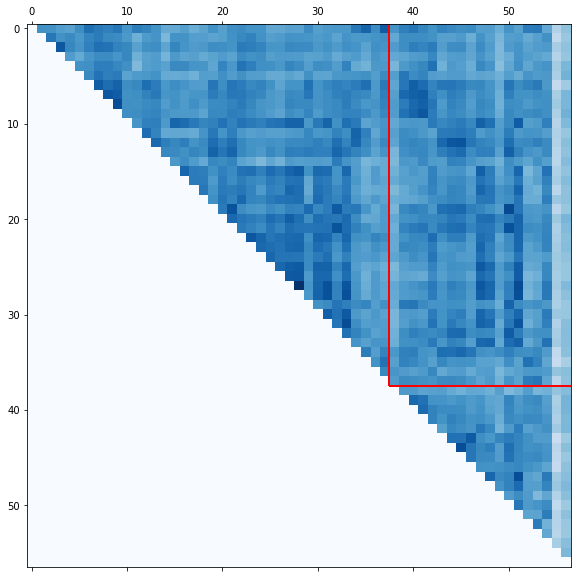

Query 2


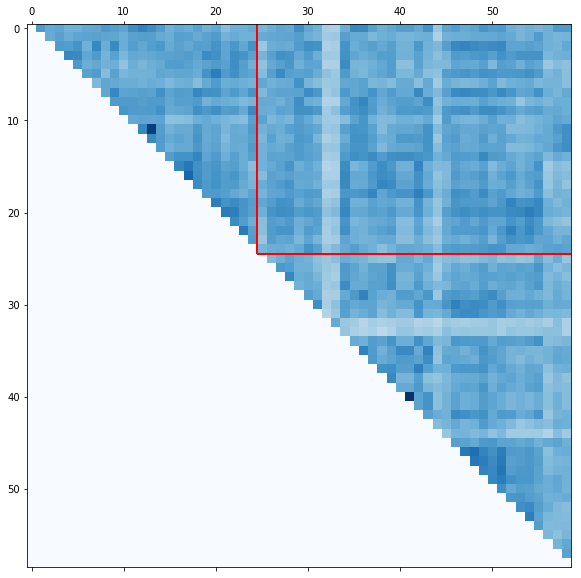

Query 3


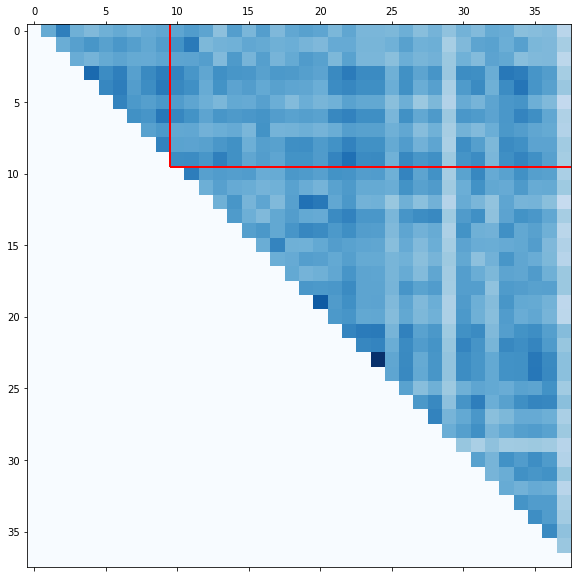

Query 4


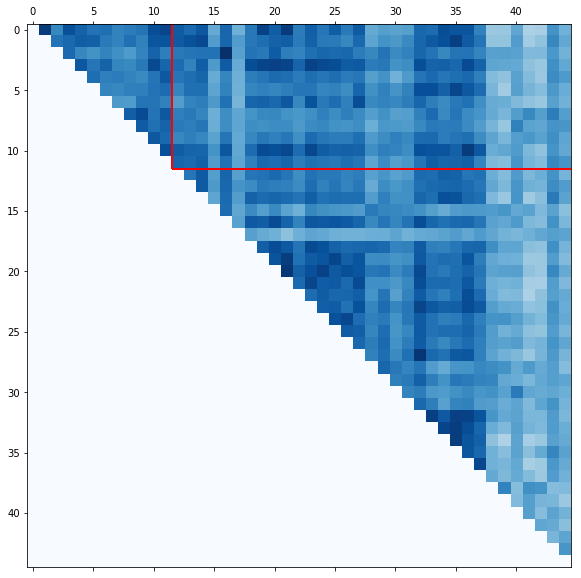

Query 5


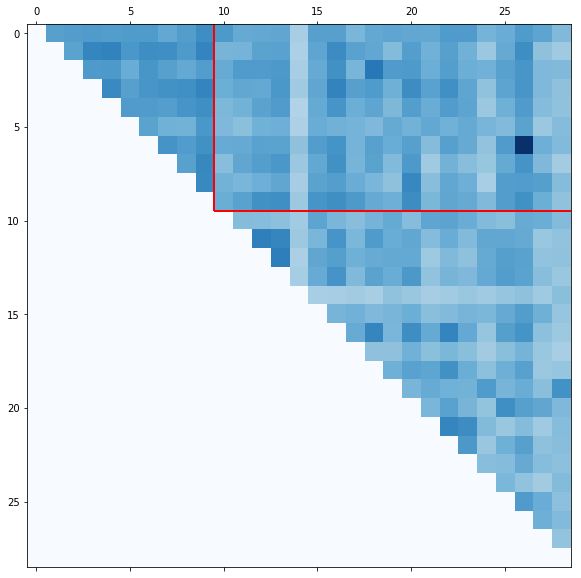

Query 6


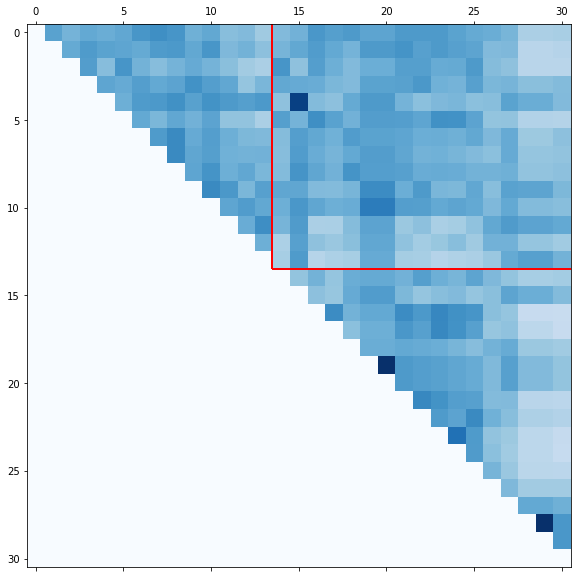

Query 7


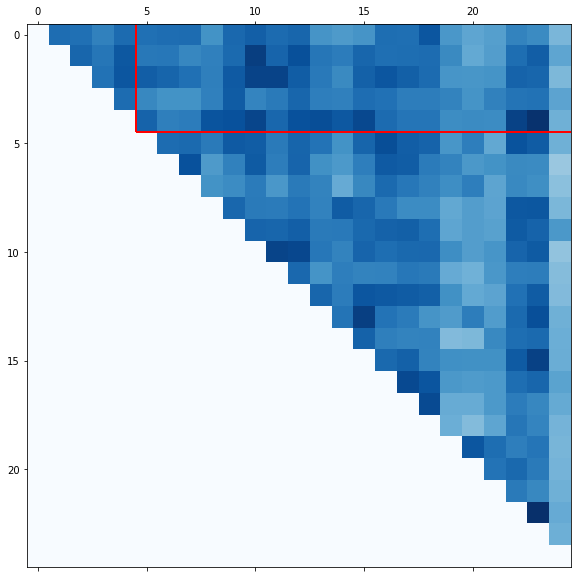

Query 8


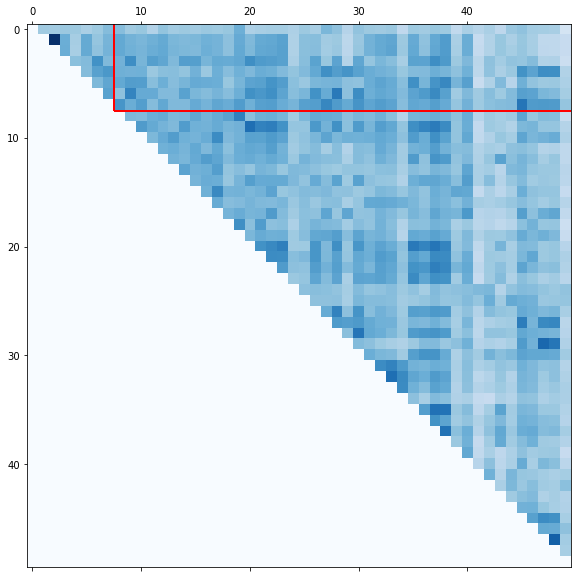

Query 9


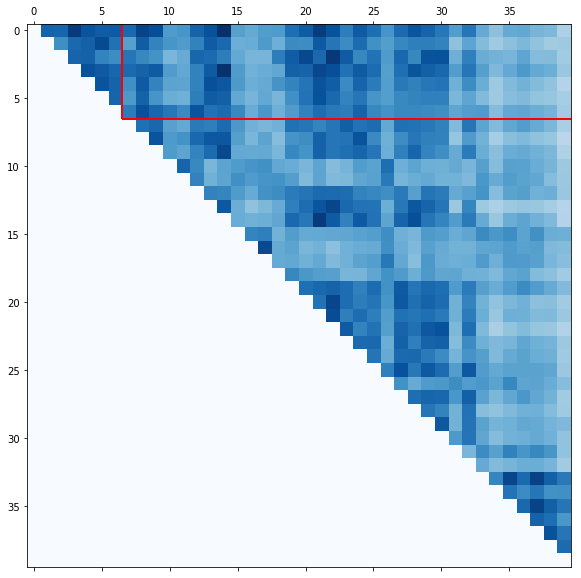

Query 10


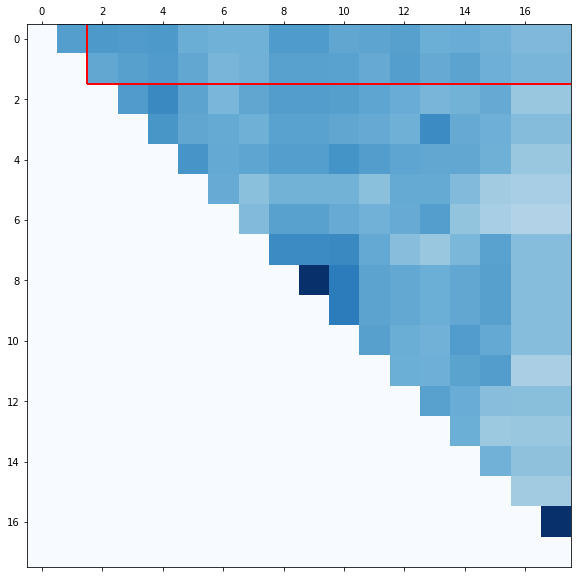

CPU times: user 30.9 s, sys: 2.36 s, total: 33.3 s
Wall time: 30 s


In [31]:
%%time
for query in xrange(1, 11):
    sim_matrix(query, gm.hellinger)

In [32]:
queries = [0]
for i in files_to_tokens('LegalAdhocTask/q*.txt'):
    queries.append(i)

In [51]:
for i in queries[1:]:
    x  = lda_model[dictionary.doc2bow(i)]
    x.sort(key = lambda x: -x[1])
    print lda_model.print_topic(x[0][0]) + '\n'

0.101*"remov" + 0.076*"defect" + 0.046*"comput" + 0.036*"speaker" + 0.025*"centr" + 0.024*"mobil" + 0.021*"repair" + 0.020*"nostat" + 0.017*"replac" + 0.017*"rectifi"

0.010*"recruit" + 0.010*"one" + 0.010*"part" + 0.008*"work" + 0.008*"use" + 0.008*"will" + 0.007*"scr" + 0.007*"also" + 0.006*"test" + 0.006*"assembl"

0.026*"medic" + 0.020*"dr" + 0.019*"injuri" + 0.017*"hospit" + 0.011*"child" + 0.011*"doctor" + 0.009*"left" + 0.009*"treatment" + 0.008*"wound" + 0.008*"right"

0.102*"entri" + 0.068*"account" + 0.042*"sb" + 0.037*"book" + 0.027*"credit" + 0.024*"suspens" + 0.016*"list" + 0.014*"imposit" + 0.012*"delinqu" + 0.010*"vigil"

0.087*"vehicl" + 0.057*"transport" + 0.037*"permit" + 0.035*"motor" + 0.031*"road" + 0.031*"owner" + 0.028*"car" + 0.020*"driver" + 0.020*"rout" + 0.016*"use"

0.200*"court" + 0.076*"high" + 0.027*"judgment" + 0.022*"order" + 0.021*"civil" + 0.017*"bench" + 0.015*"decis" + 0.015*"special" + 0.014*"v" + 0.014*"held"

0.068*"offic" + 0.033*"author" + 0.03

In [ ]:

import math
from six import iteritems
from six.moves import xrange



class Lda(object):

    def __init__(self, corpus):
        self.corpus_size = dictionary.num_docs
        s = 0
        for i in corpus:
            for x in i:
                s = s + x[1]
        s = float(s)    
        self.avgdl = s / self.corpus_size
        self.corpus = corpus
        self.df = dictionary.dfs
        self.idf = {}
        self.initialize()

    def initialize(self):
        for word, freq in iteritems(self.df):
            self.idf[word] = math.log(self.corpus_size - freq + 0.5) - math.log(freq + 0.5)

    def get_score(self, query, index, average_idf):
        score = 0
        index_doc = dict(self.corpus[index])
        
        for word,freq in query:
            if word not in index_doc:
                continue
            idf = self.idf[word] if self.idf[word] >= 0 else EPSILON * average_idf
            score += freq*((idf * index_doc[word] * (PARAM_K1 + 1)
                      / (index_doc[word] + PARAM_K1 * (1 - PARAM_B + PARAM_B * doc_len[index] / self.avgdl))))
        return score

    def get_scores(self, query, average_idf):
        scores = []
        for index in xrange(self.corpus_size):
            score = self.get_score(query, index, average_idf)
            scores.append(score)
        return scores

